#**Note**
This is our ***3rd*** notebook. Here is our how notebooks are divided:
1. **Nadeen_Ali_Bioinfo_Preprocessing.ipynb**
2. **Nadeen_Ali_Bioinfo_MOFA_Object.ipynb**
3. (we are here) **Nadeen_Ali_Bioinfo_Data_Integration.ipynb**

#**MOFA Data Integration**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.chdir('../')

In [3]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 200

In [4]:
pip install mofax

In [5]:
import mofax as mfx

In [6]:
# loading the mofa model (created in 2nd notebook)
m = mfx.mofa_model('/content/bioinfo_mofa_model.hdf5')

In [7]:
print(f'Cells: {m.shape[0]}') # num. of samples (patients)
print(f'Features: {m.shape[1]}') # sum of num. of features (genes)
print(f'Groups of cells: {", ".join(m.groups)}') # sample groups
print(f'Views: {", ".join(m.views)}') # data types used

Cells: 205
Features: 20180
Groups of cells: group0
Views: view0, view1


In [8]:
# HDF5 group
print('HDF5 group: \n', m.weights)

# np.ndarray
print('\nnp.ndarray: \n', m.get_weights()[:3, :5])

# pd.DataFrame
print('\npd.DataFrame: \n', m.get_weights(df = True).iloc[:3, :5])

HDF5 group: 
 <HDF5 group "/expectations/W" (2 members)>

np.ndarray: 
 [[ 0.1543952   0.07997365 -0.0056292   0.25535916 -0.09797285]
 [-0.12110613  0.23825055  0.15096214  0.08845683  0.51826442]
 [ 0.16032378  0.13330402  0.07143902  0.00420588  0.00649249]]

pd.DataFrame: 
                  Factor1   Factor2   Factor3   Factor4   Factor5
feature0_view0  0.154395  0.079974 -0.005629  0.255359 -0.097973
feature1_view0 -0.121106  0.238251  0.150962  0.088457  0.518264
feature2_view0  0.160324  0.133304  0.071439  0.004206  0.006492


In [9]:
import pandas as pd

In [10]:
rna_df = pd.read_csv('/content/rna_csv.csv')
rna_df.set_index('sample_id', inplace = True)
rna_df.shape

(205, 19112)

In [11]:
mut_df = pd.read_csv('/content/mut_csv.csv')
mut_df.set_index('sample_id', inplace = True)
mut_df.shape

(205, 1068)

#**Mapping Feature Names to Gene Names**

In [12]:
# checking which view is which df
weights = m.get_weights(df = True)
view_sizes = {}

for view in ['view0', 'view1']:
    view_mask = weights.index.str.endswith(f'_{view}')
    view_weights = weights.loc[view_mask]
    view_sizes[view] = view_weights.shape[0]

print(view_sizes)
# view0 = rna, view1 = mut

{'view0': 19112, 'view1': 1068}


#**General Top Features**

In [15]:
def geneMapping2(rna_df, mut_df):
    feature_map = {}

    # Map view0 (RNA)
    for i, gene in enumerate(rna_df.columns):
        feature_map[f'feature{i}_view0'] = gene

    # Map view1 (Mutation)
    for i, gene in enumerate(mut_df.columns):
        feature_map[f'feature{i}_view1'] = gene

    return feature_map

In [16]:
gene_map = geneMapping2(rna_df, mut_df)

#**Plotting Factors' Top Features**

In [17]:
import matplotlib.pyplot as plt

In [18]:
def weightsPlot(model, view, df, top_n = 10):
    weights_df = model.get_weights(df = True)

    view_mask = weights_df.index.str.endswith(f'_{view}')
    view_weights = weights_df.loc[view_mask].copy()
    view_weights.index = (
        view_weights.index.str.replace(f'_{view}', '', regex = False)
                          .str.replace('feature', '', regex = False)
                          .astype(int)
    )

    for factor in weights_df.columns:
        top = view_weights[factor].abs().sort_values(ascending=False).head(top_n)
        genes = df.columns[top.index]
        values = view_weights.loc[top.index, factor]

        plt.figure(figsize=(10, 5))
        plt.barh(genes[::-1], values[::-1])
        plt.xlabel('Weight')
        plt.title(f'{factor} — Top {top_n} Features ({view})')
        plt.tight_layout()
        plt.show()
        print('\n')

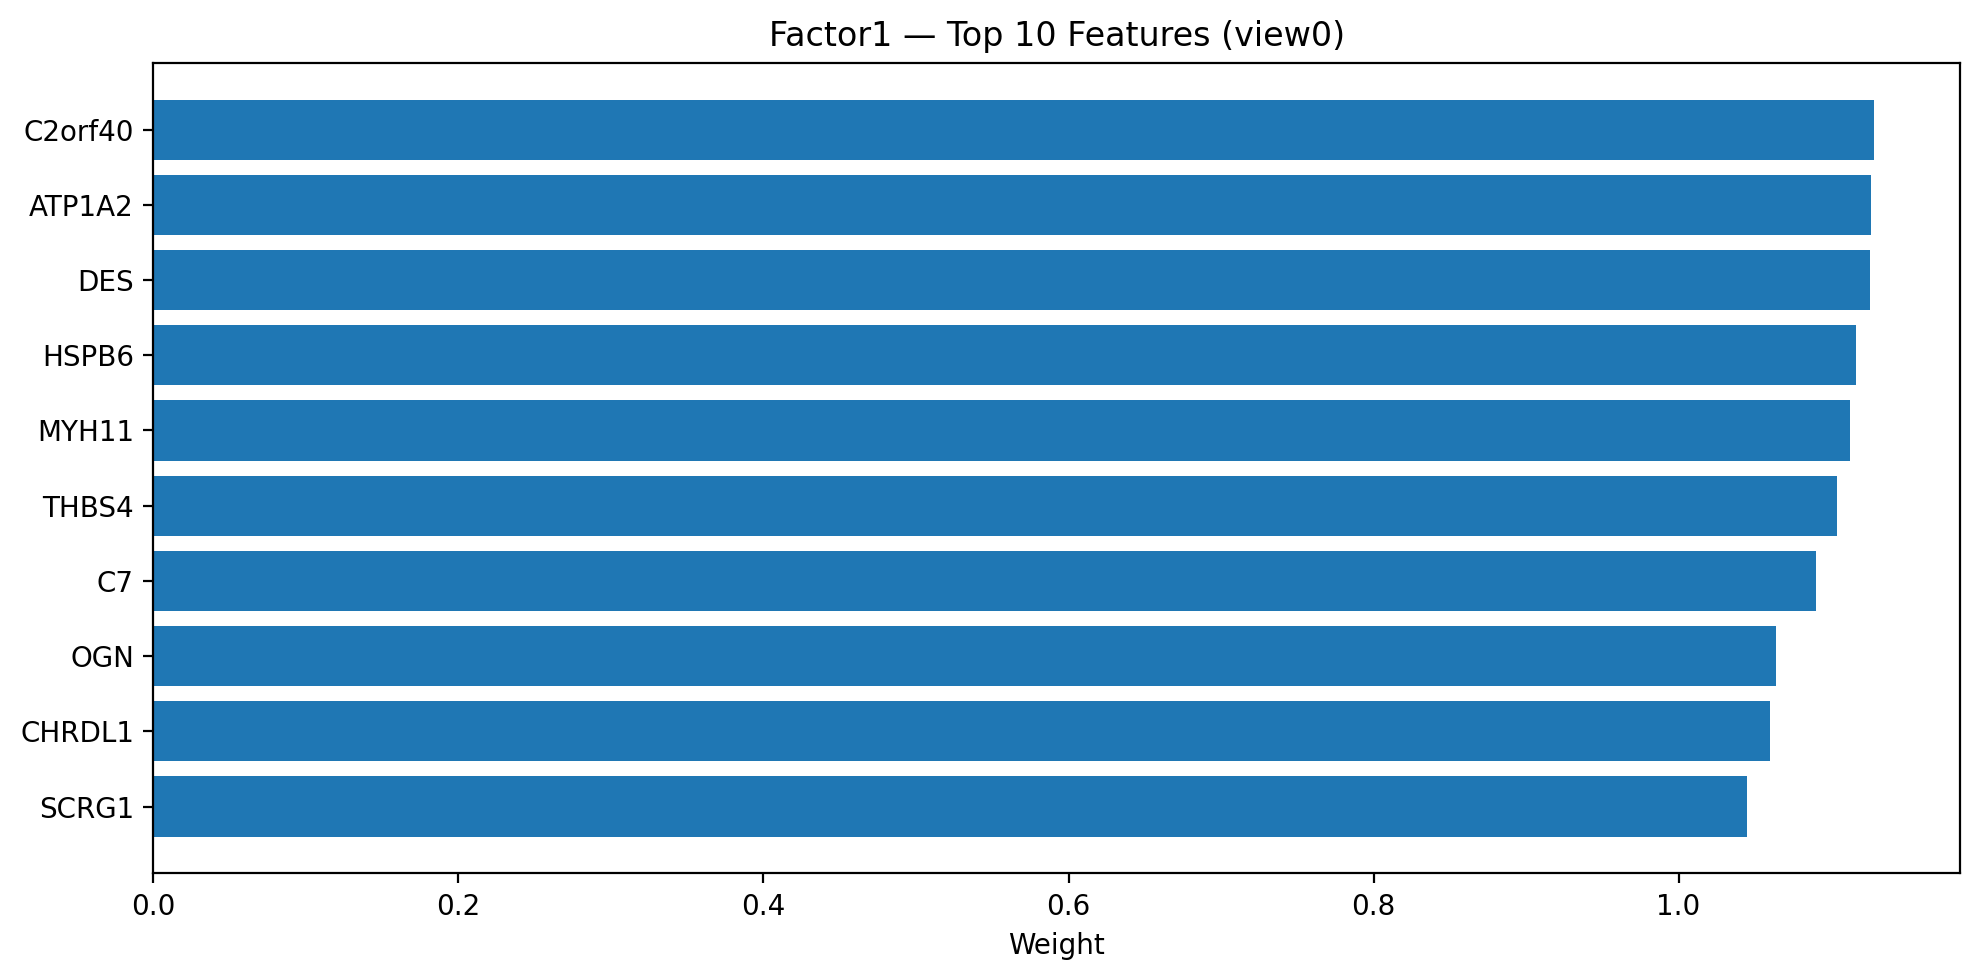

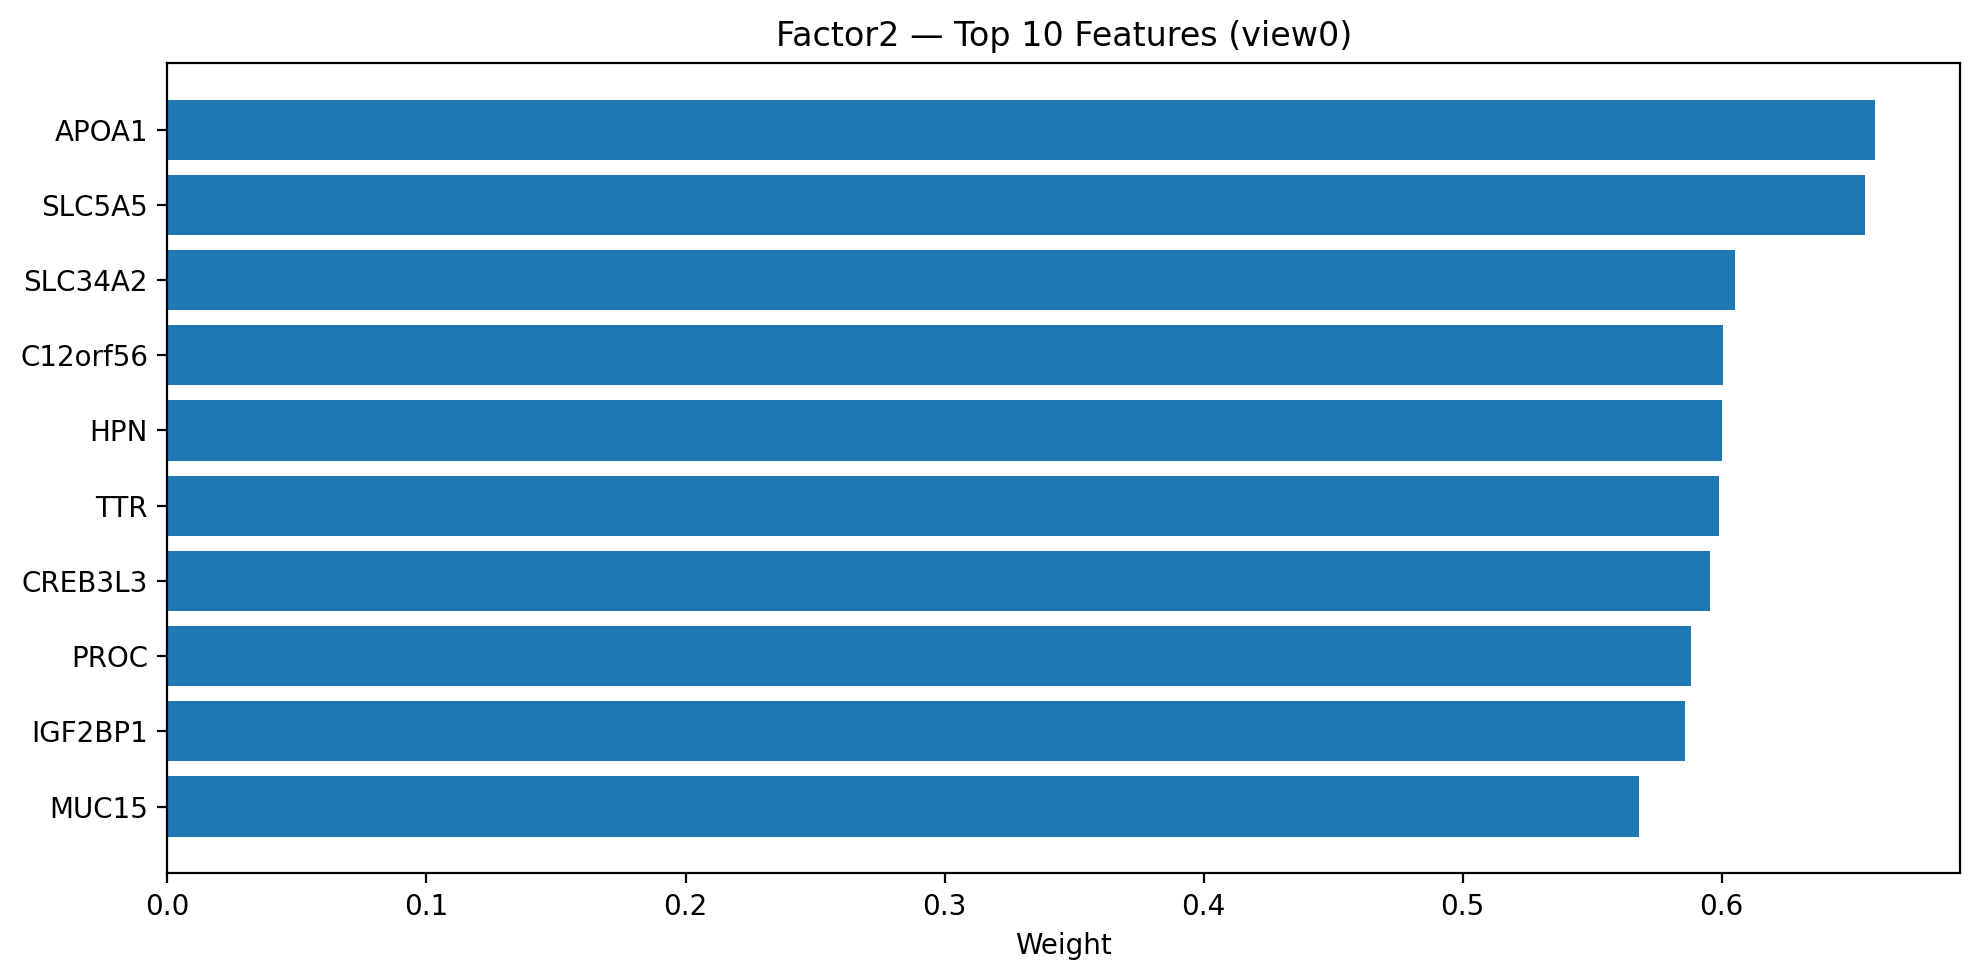

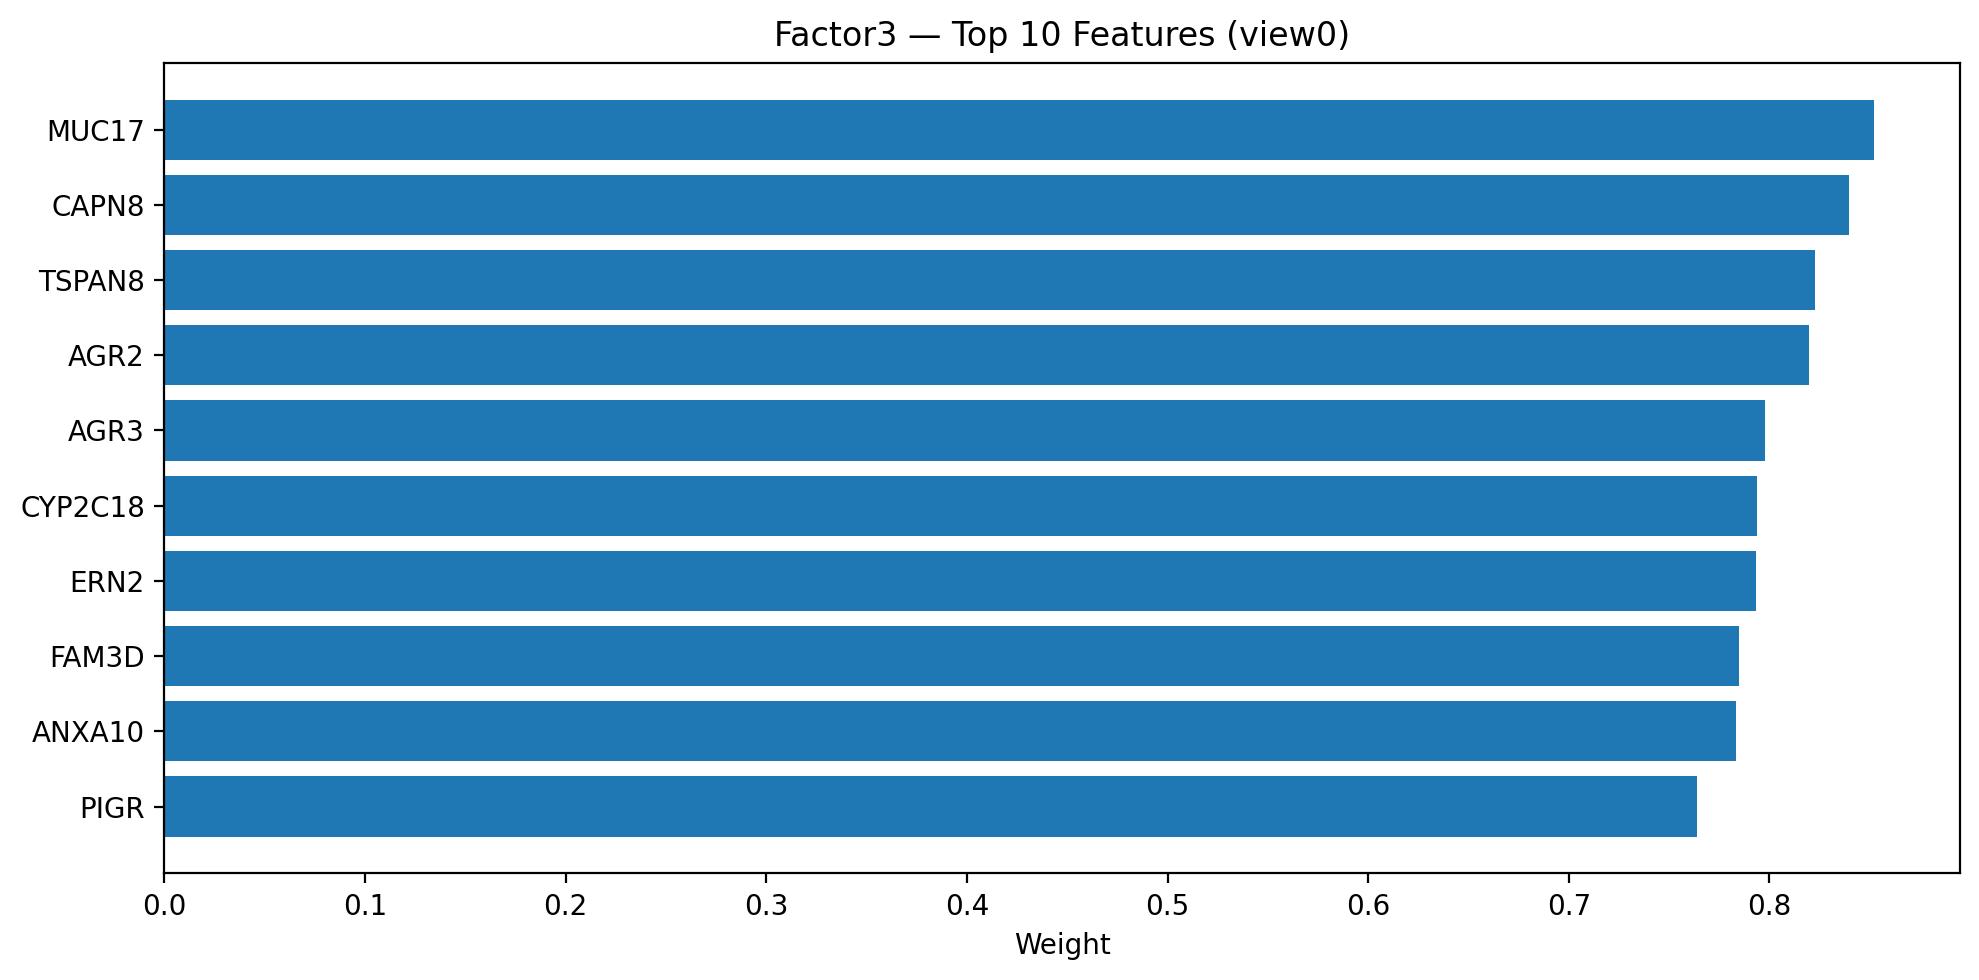

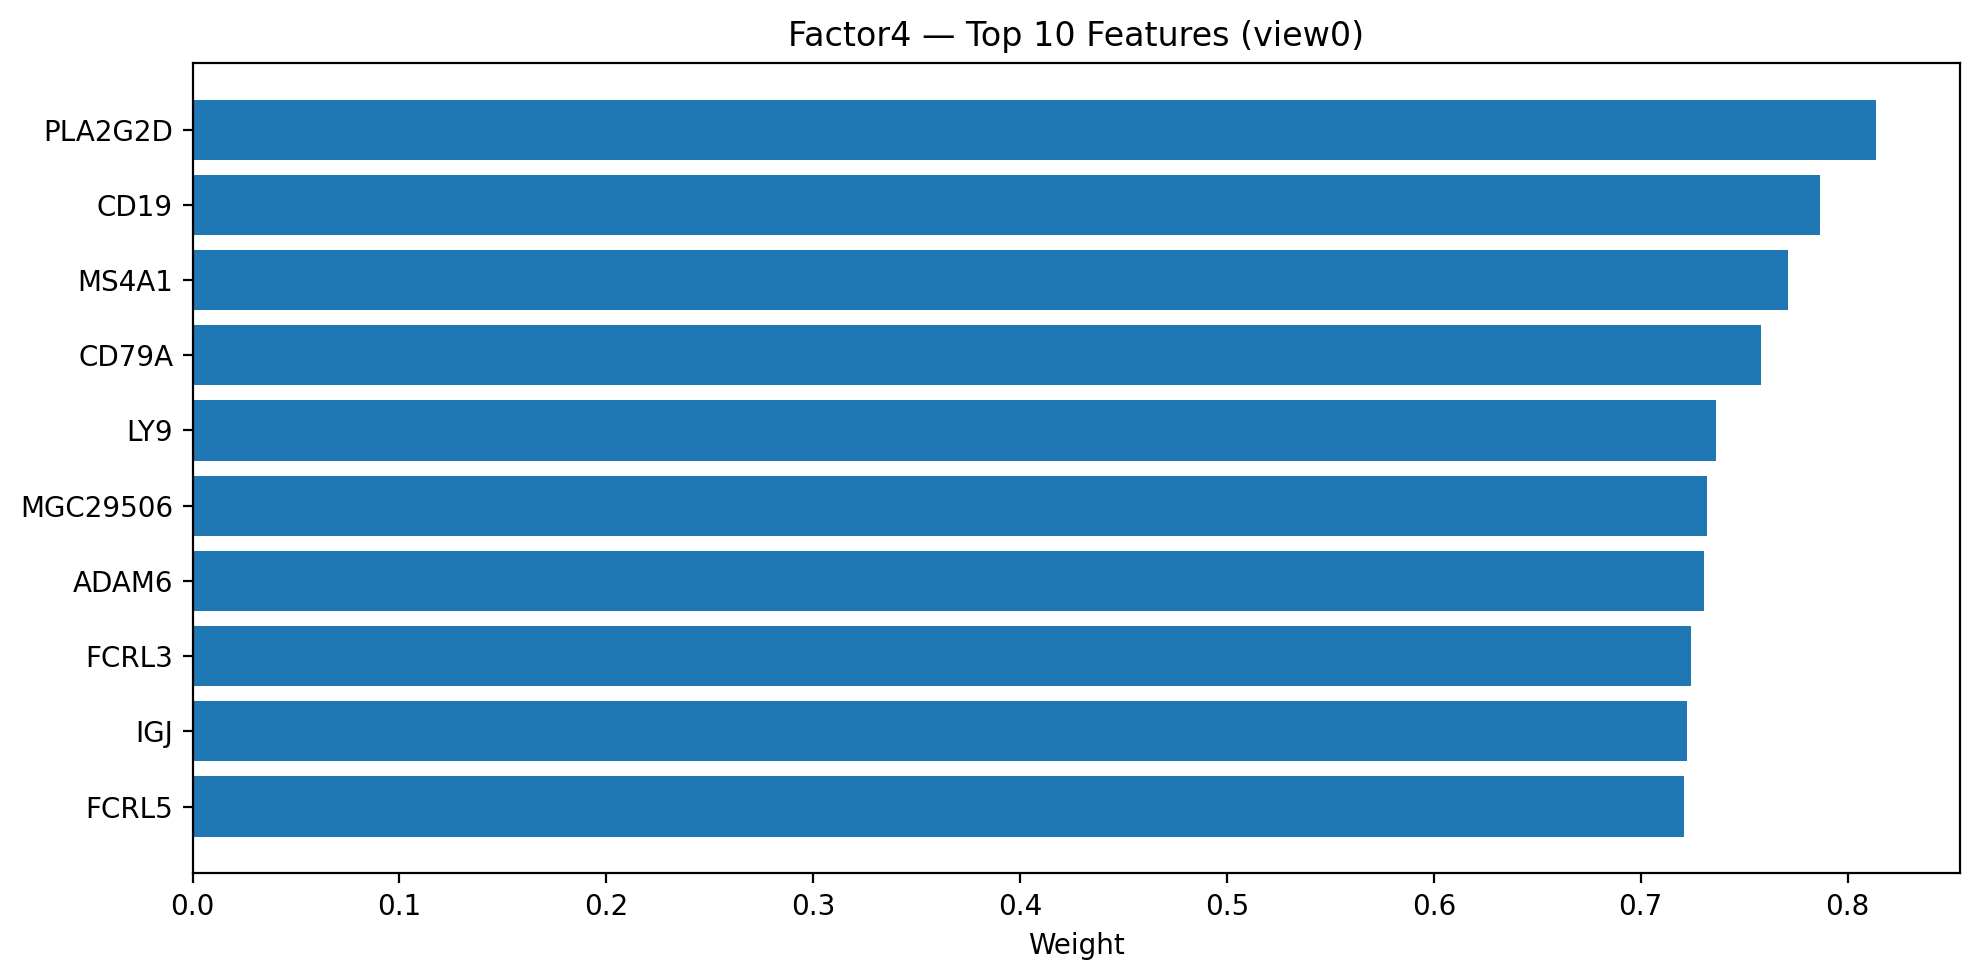

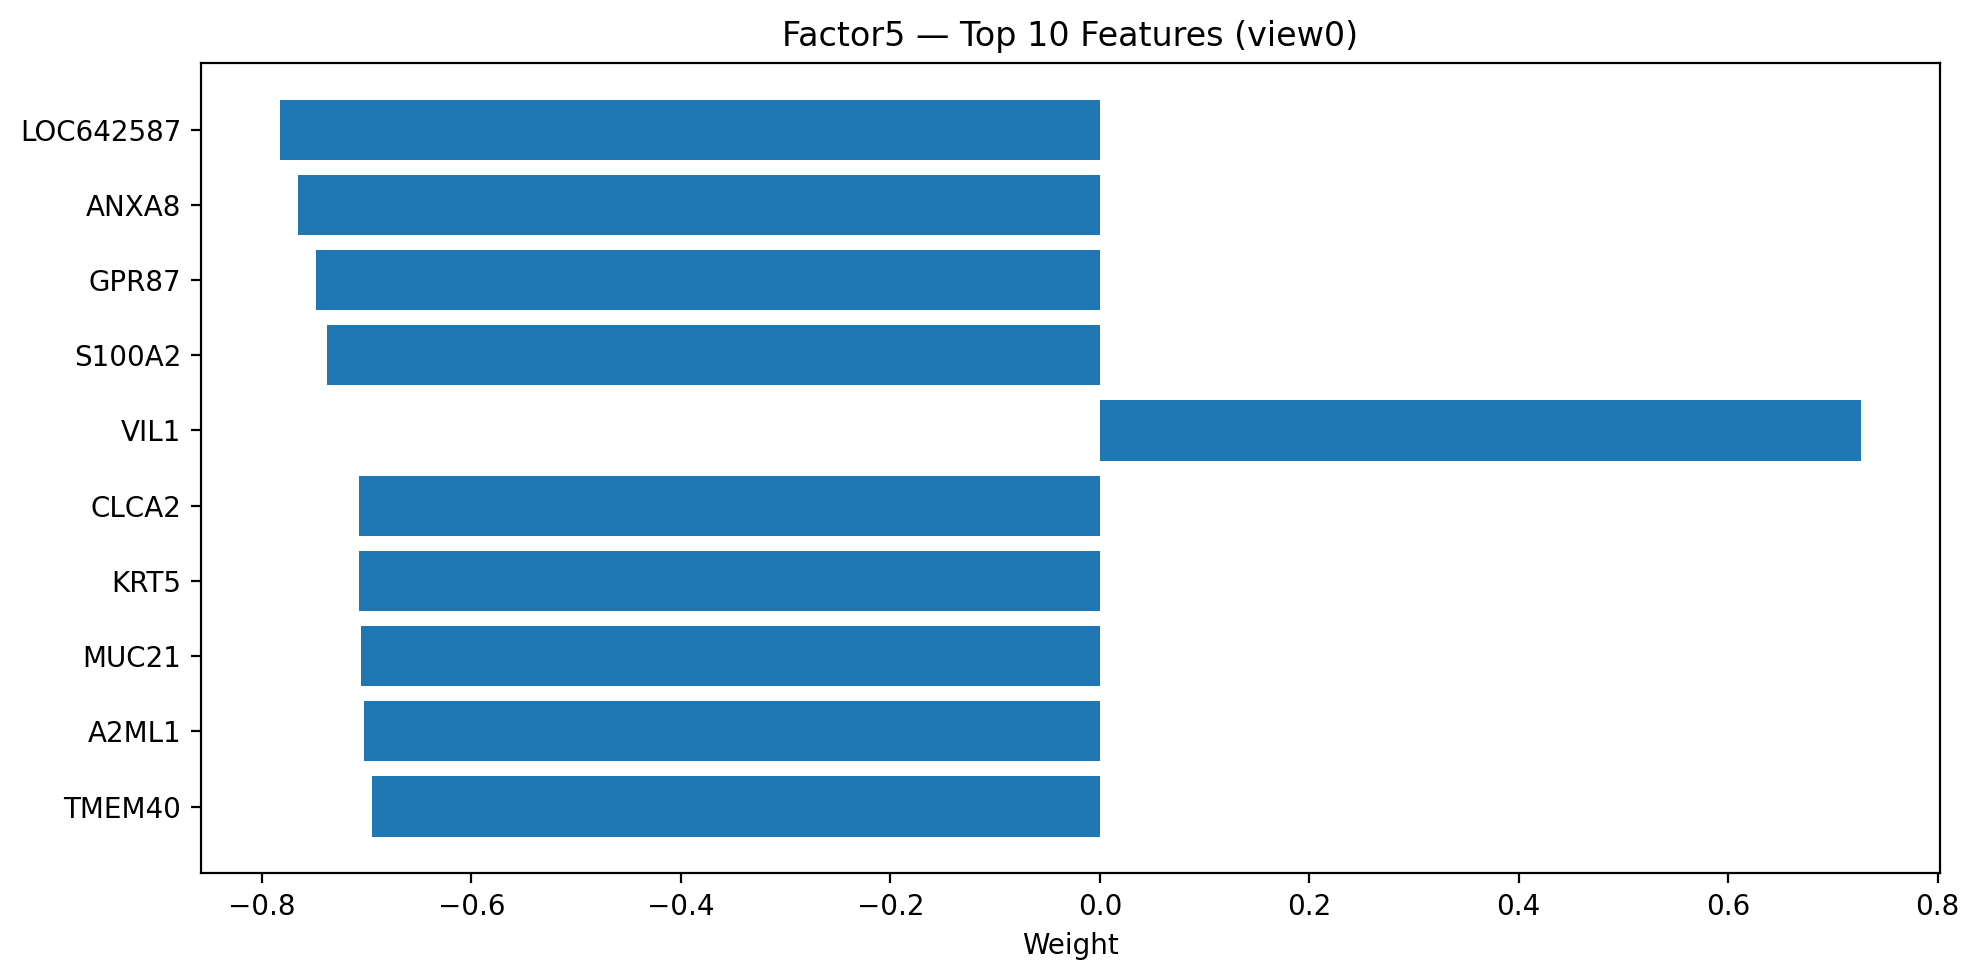

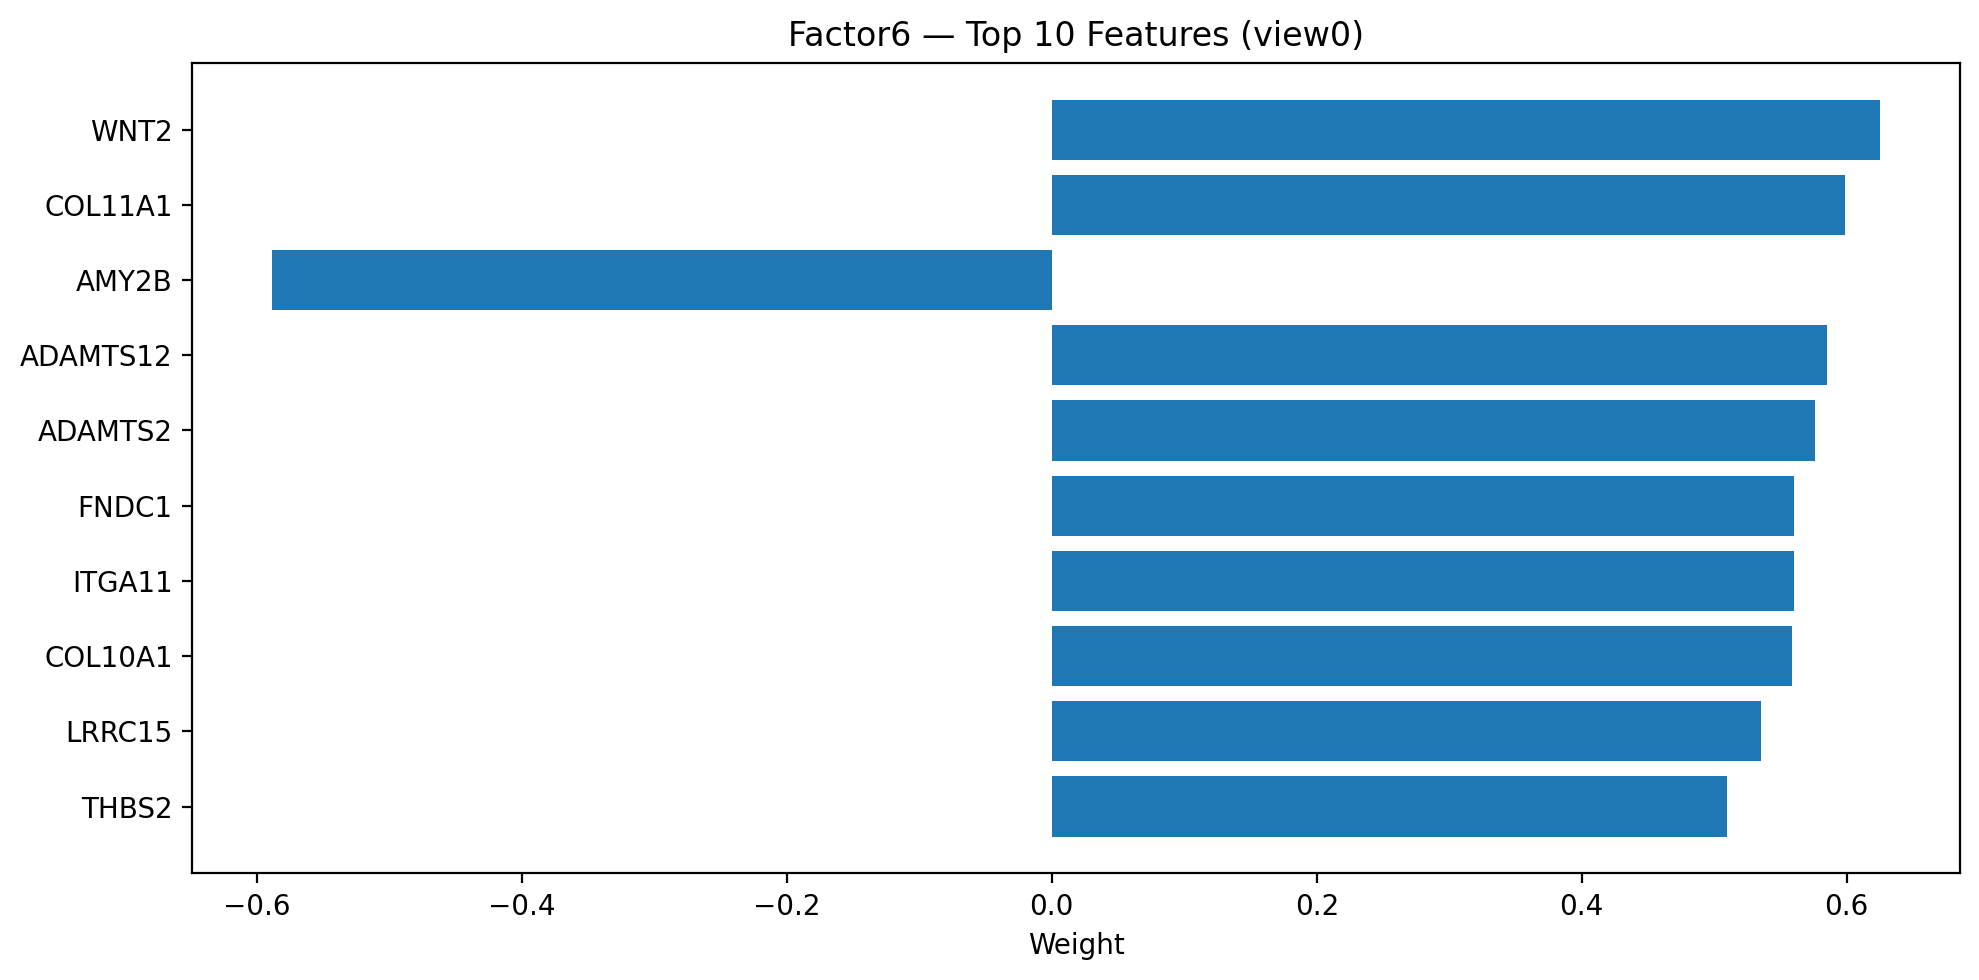

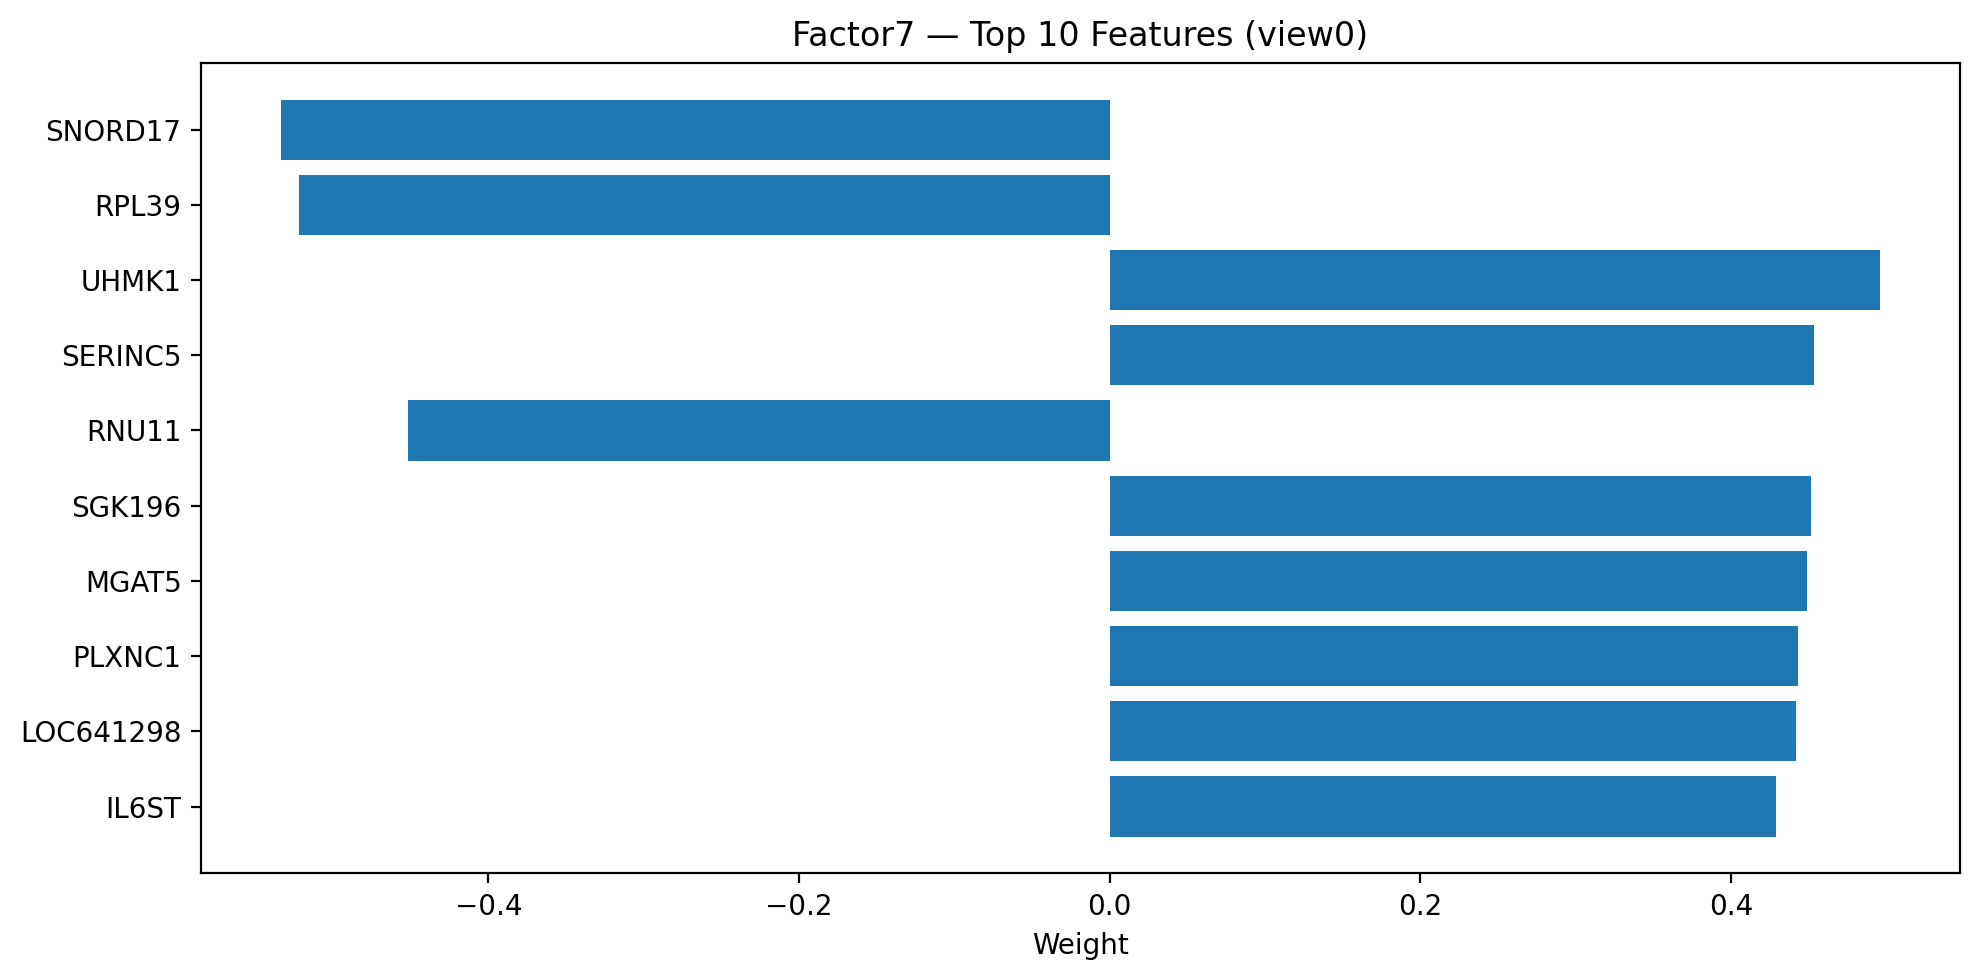

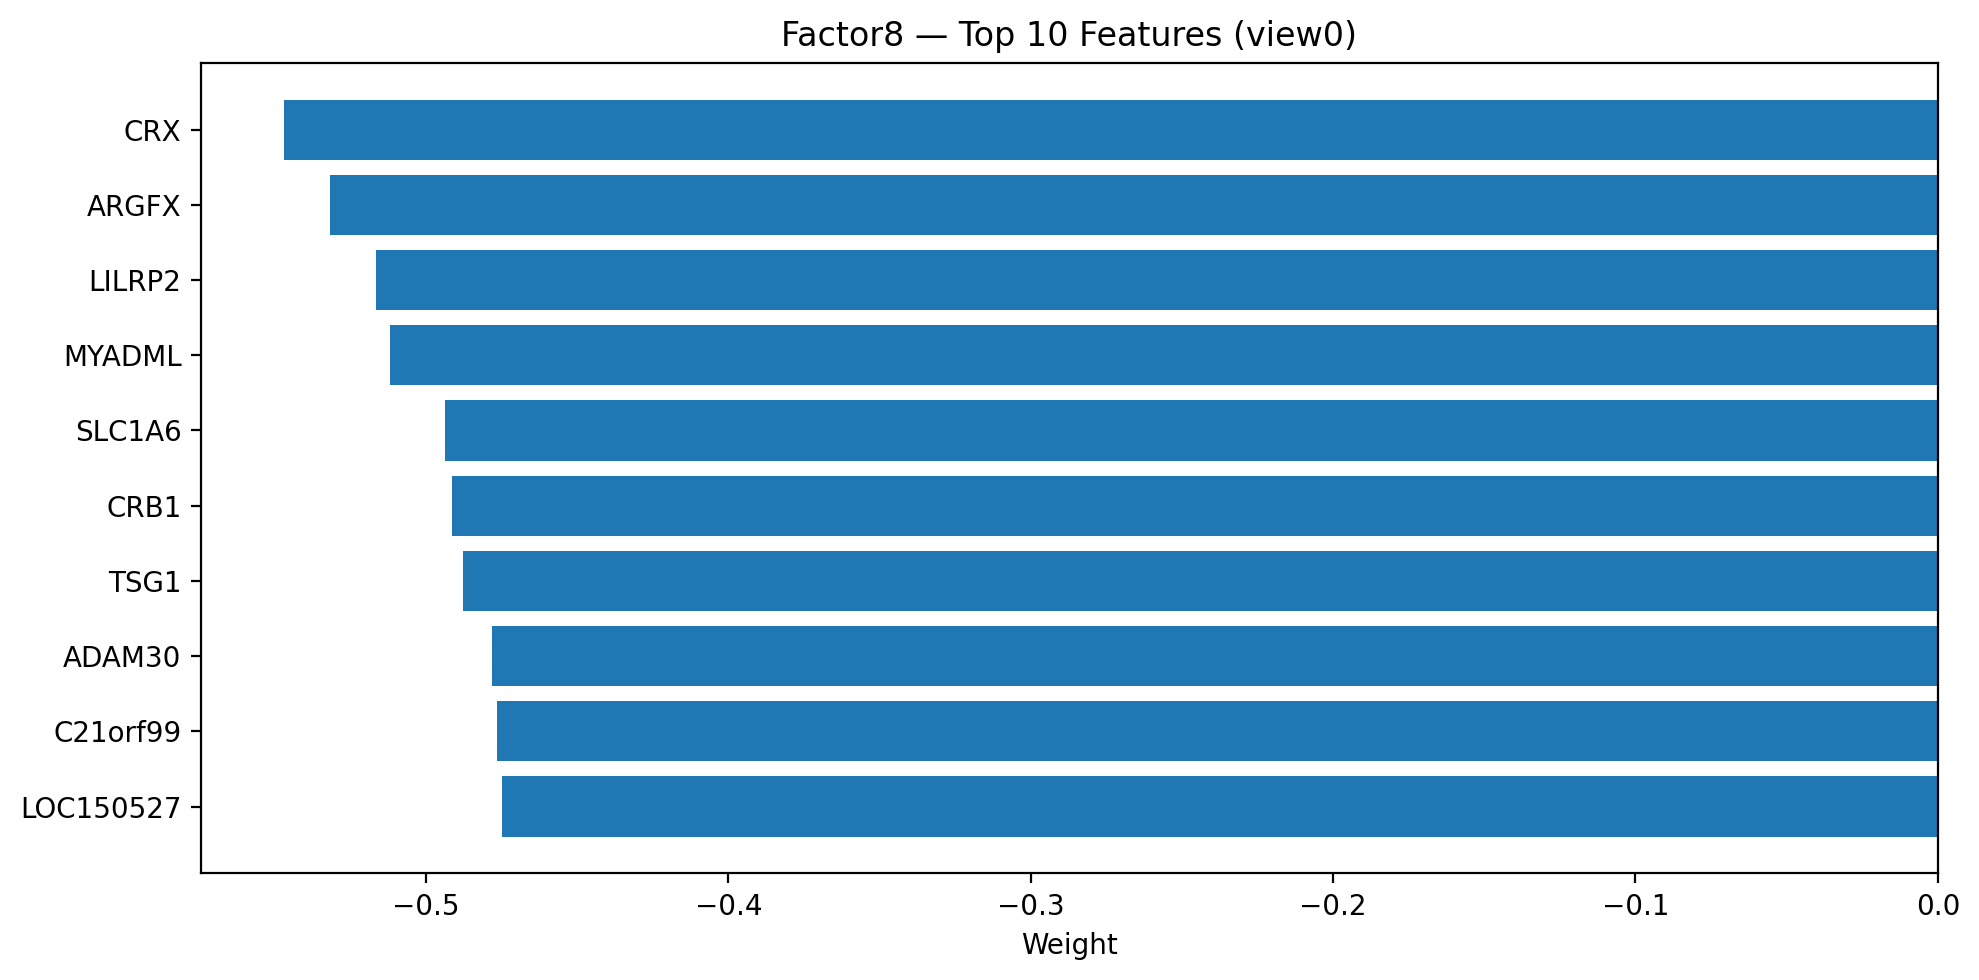

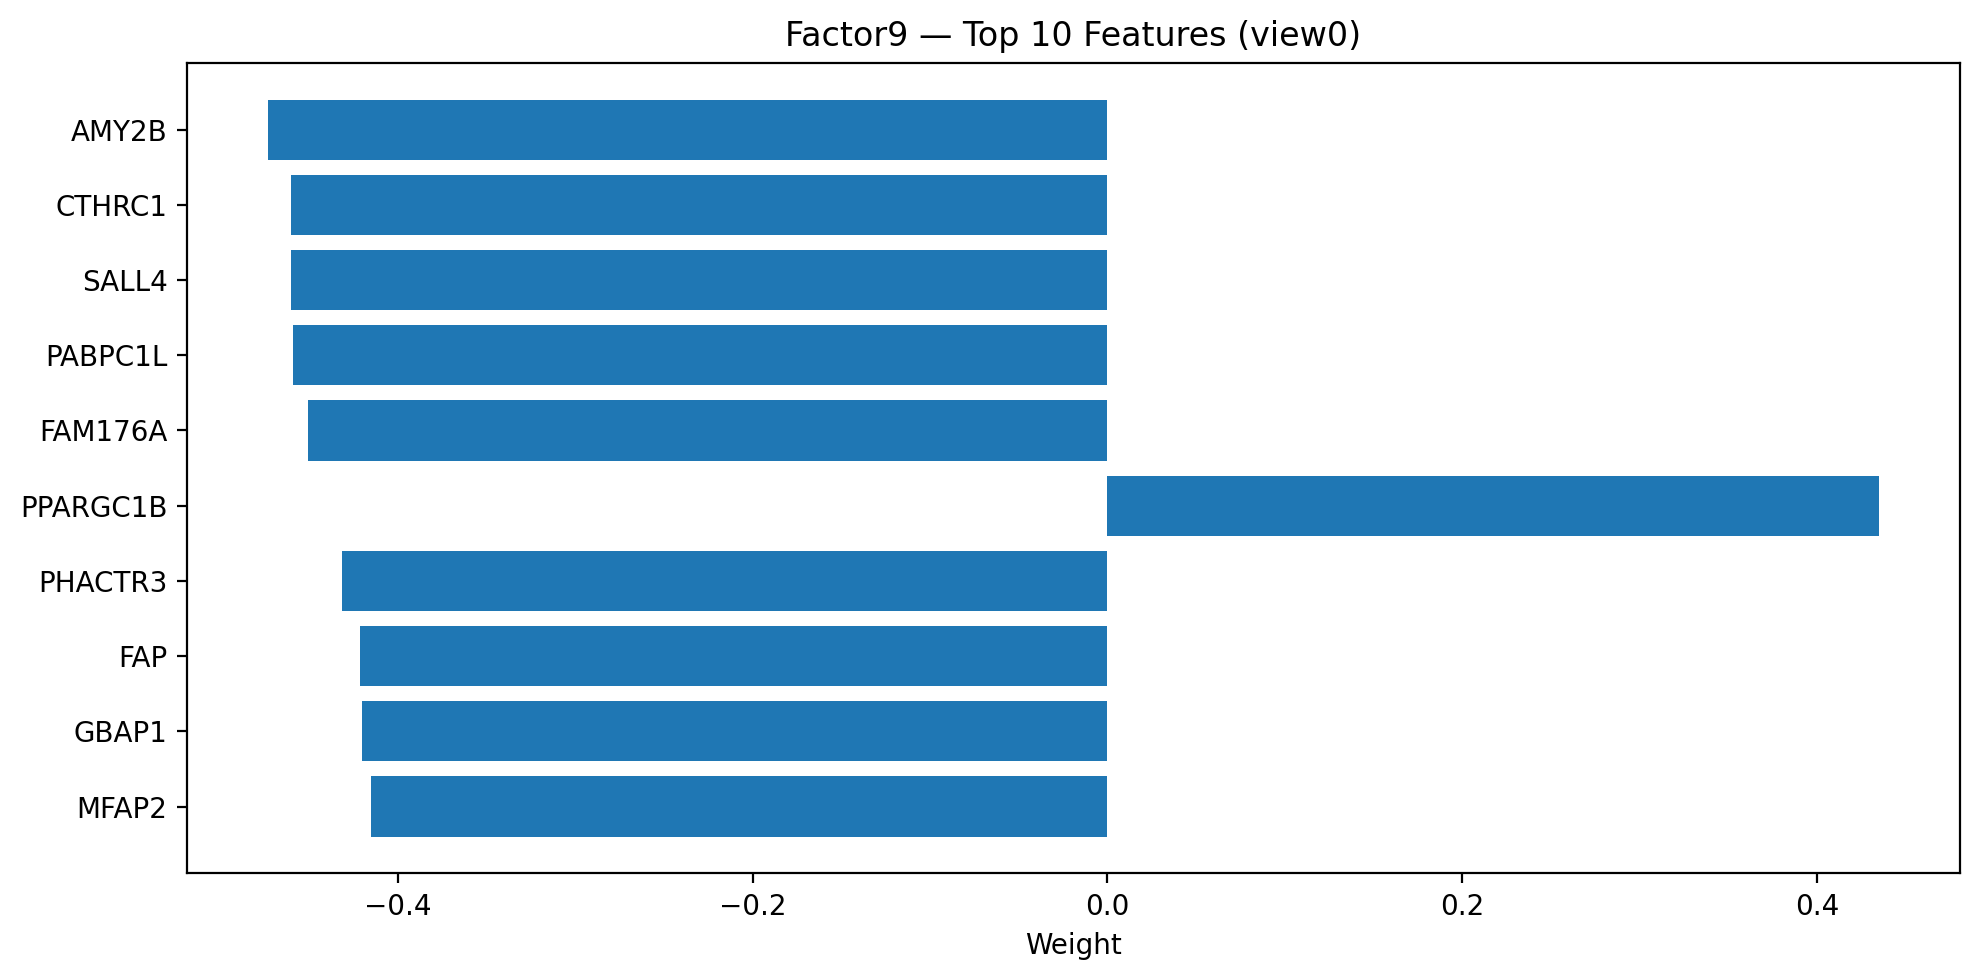

In [19]:
weightsPlot(m, 'view0', rna_df)

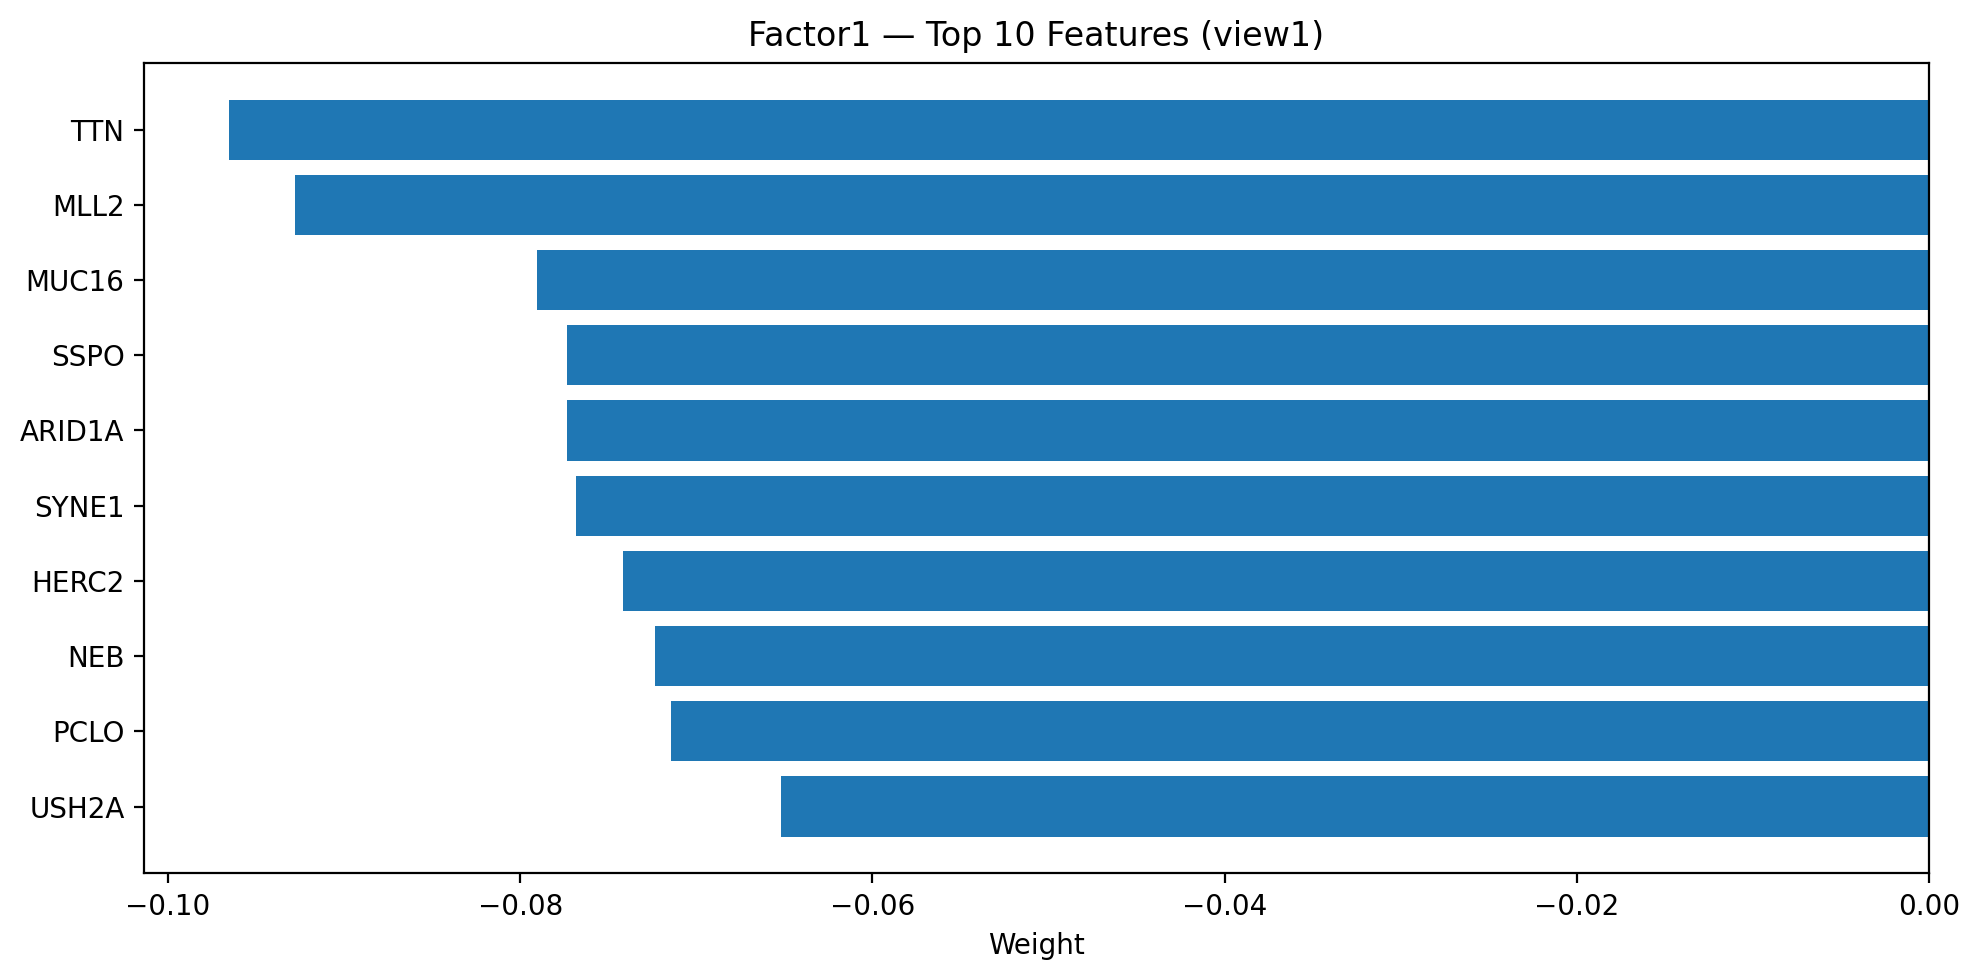

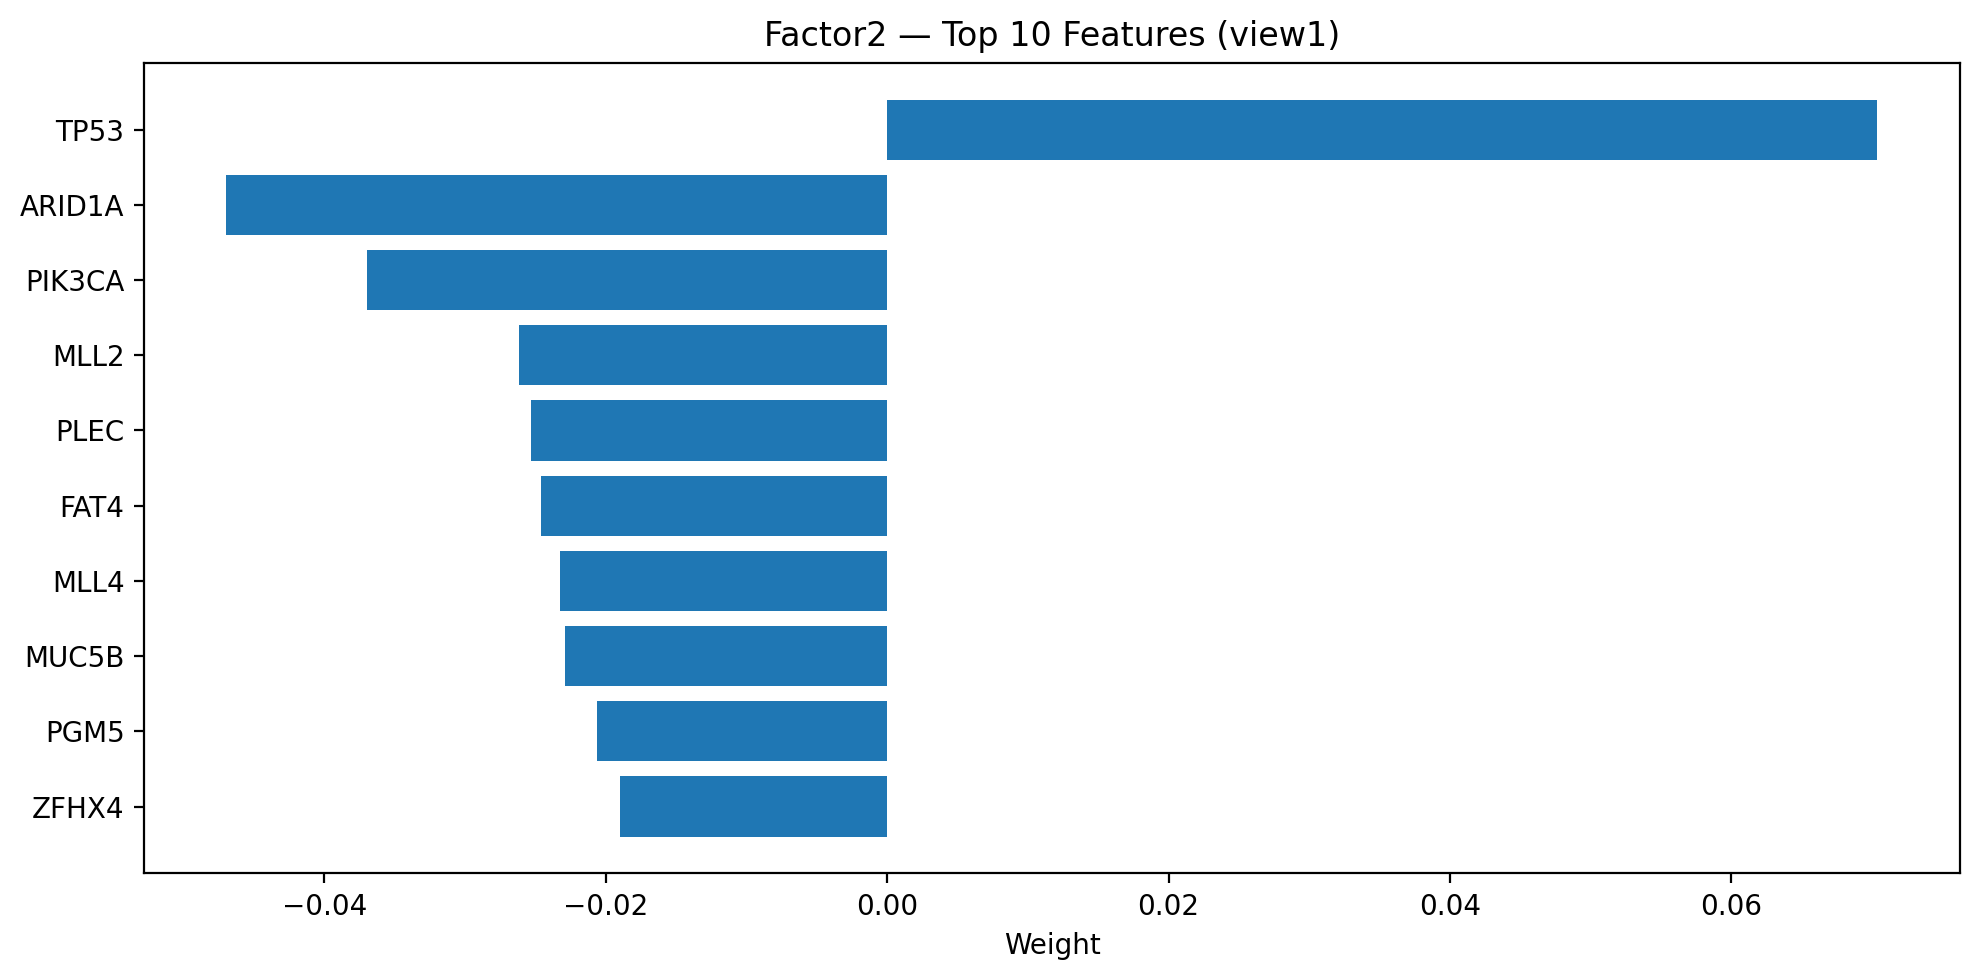

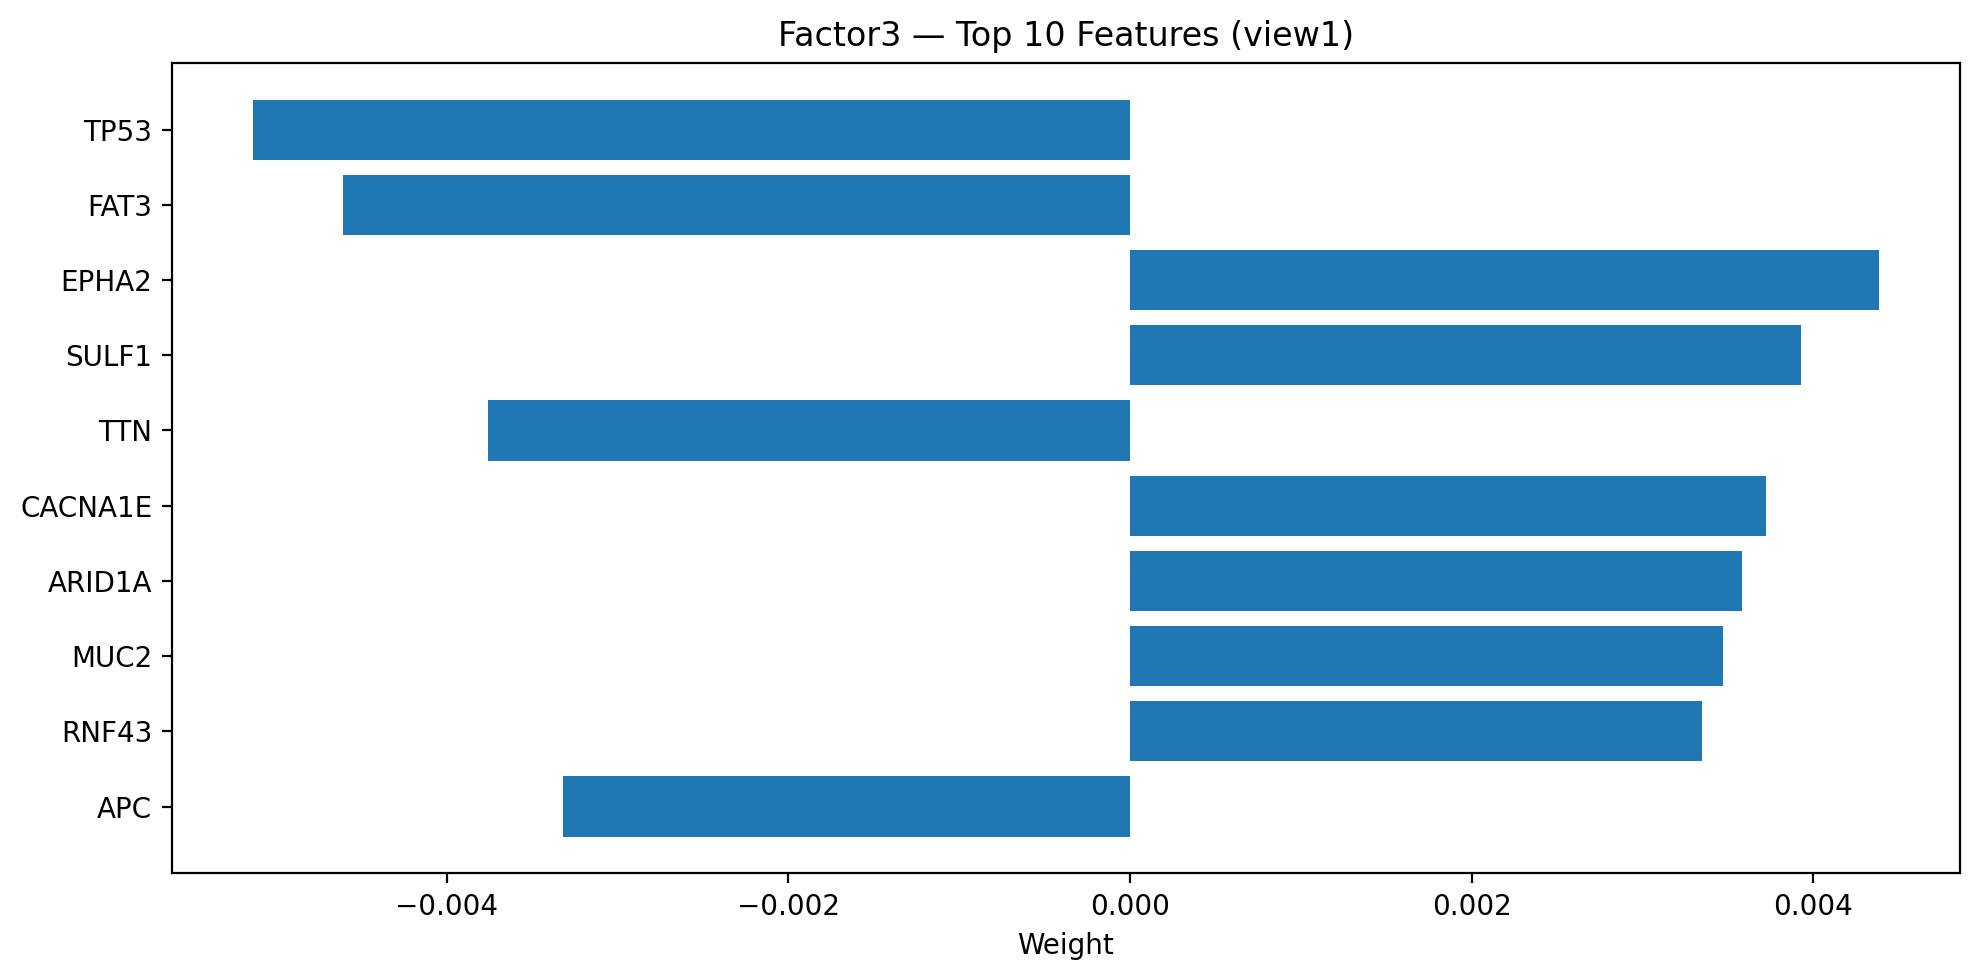

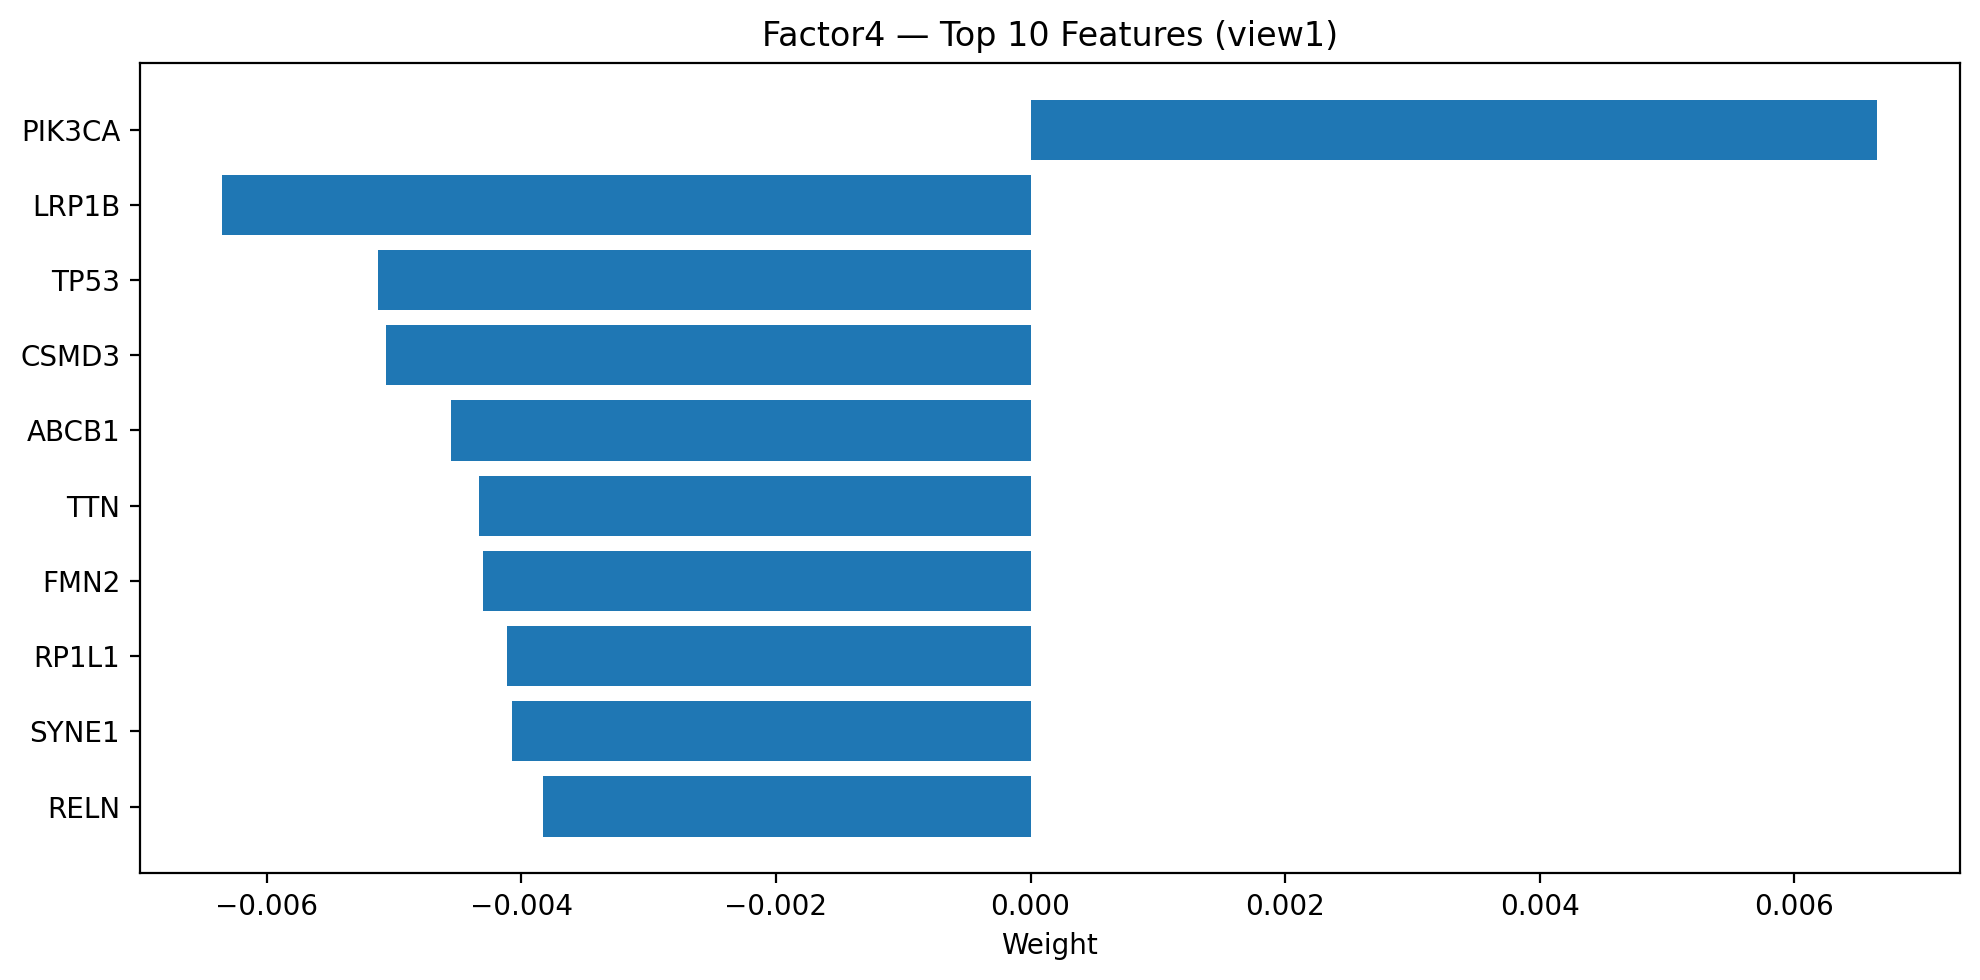

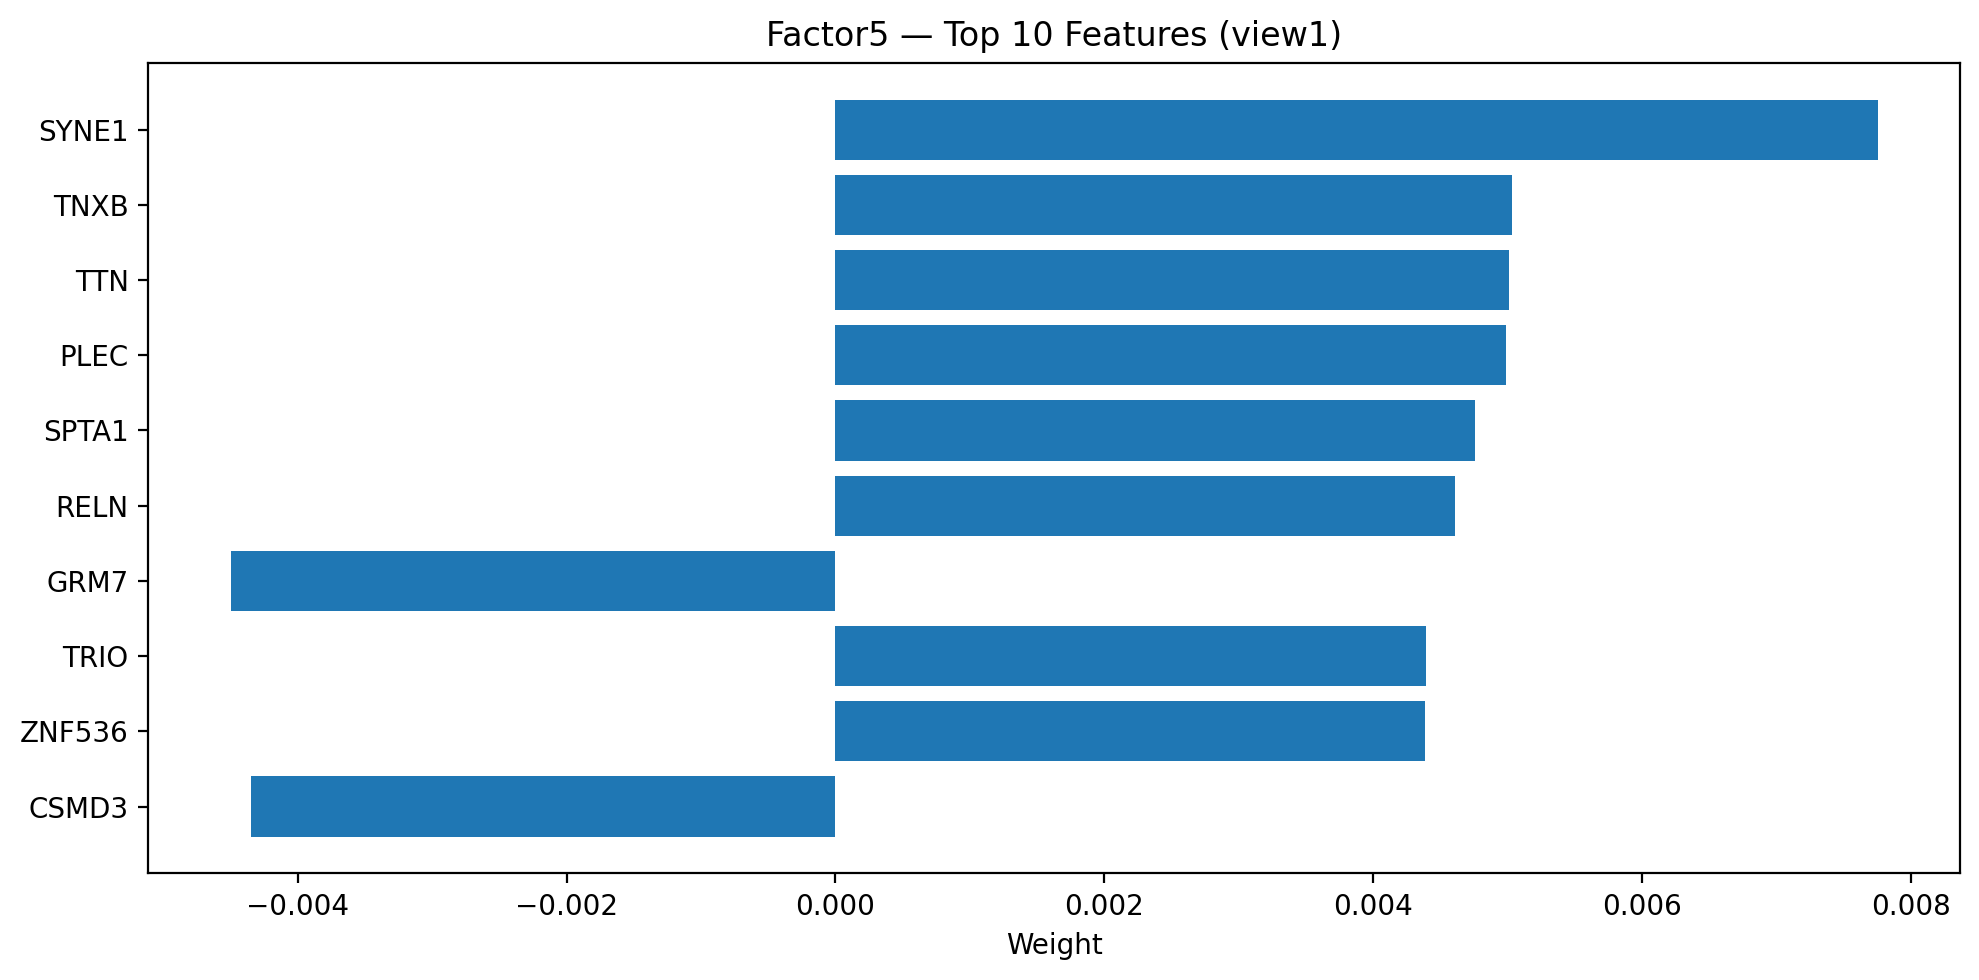

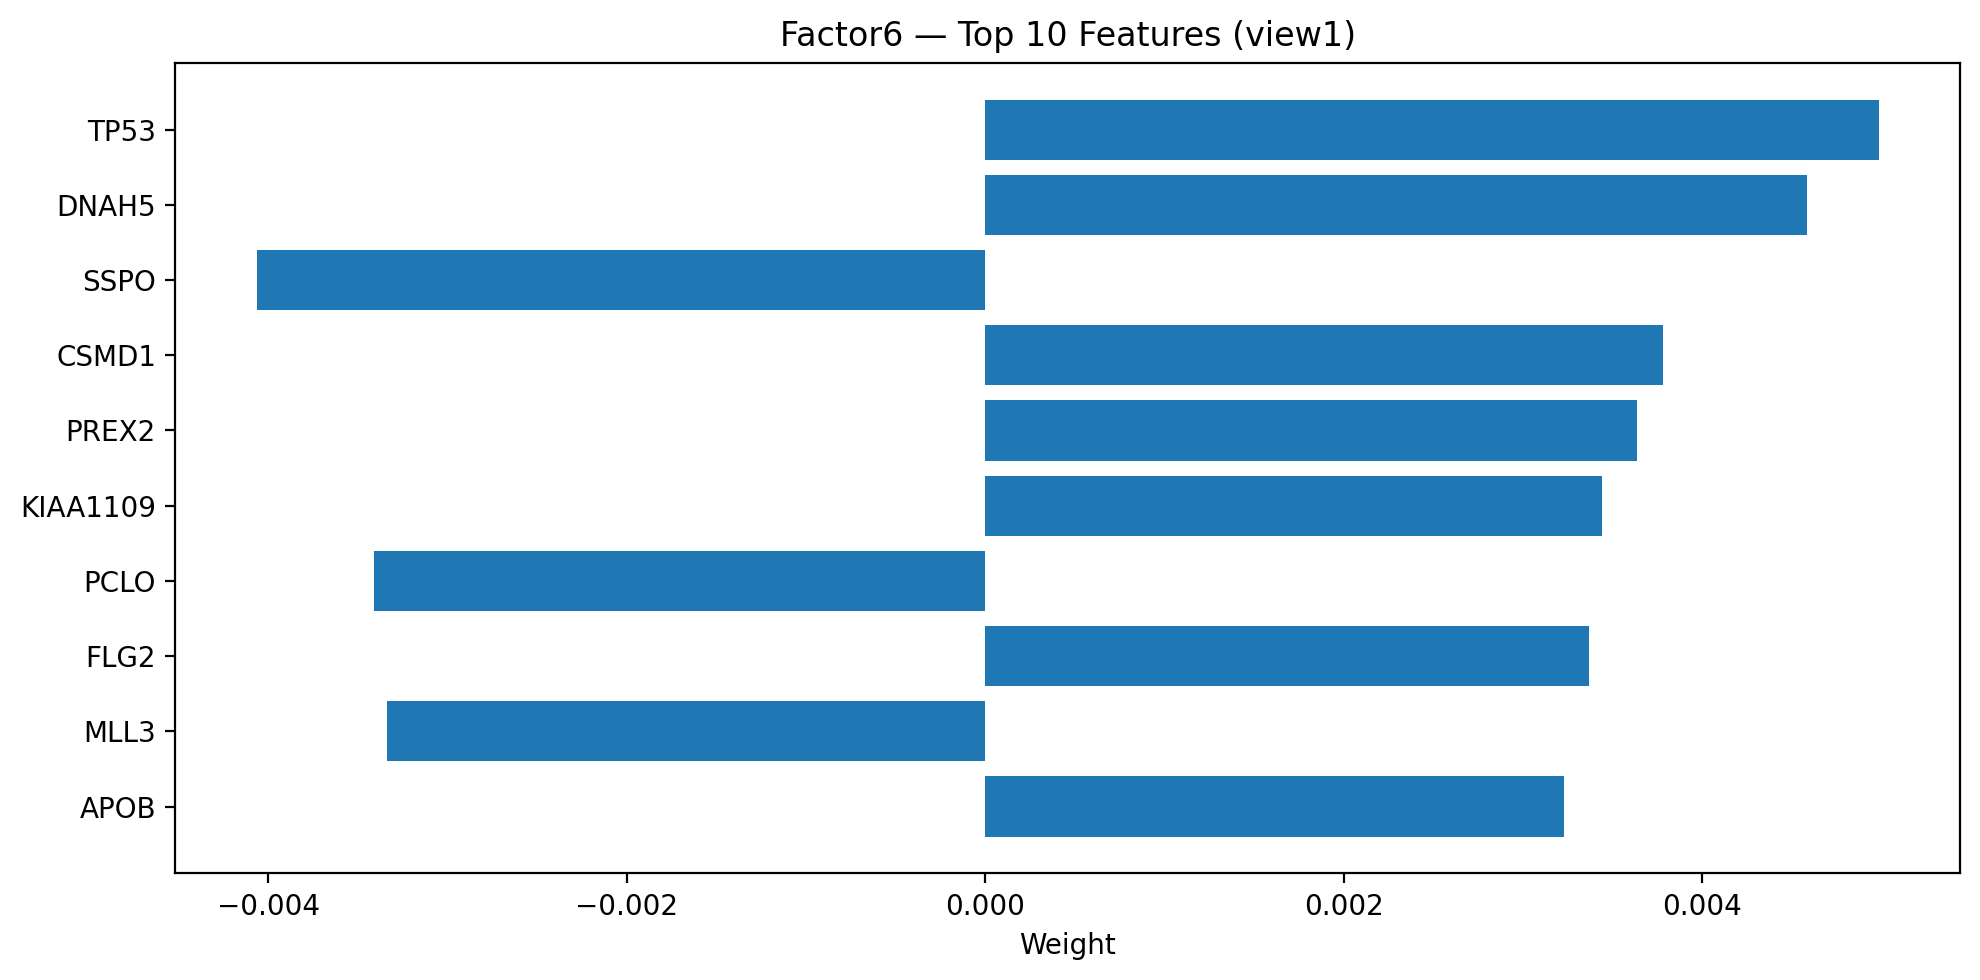

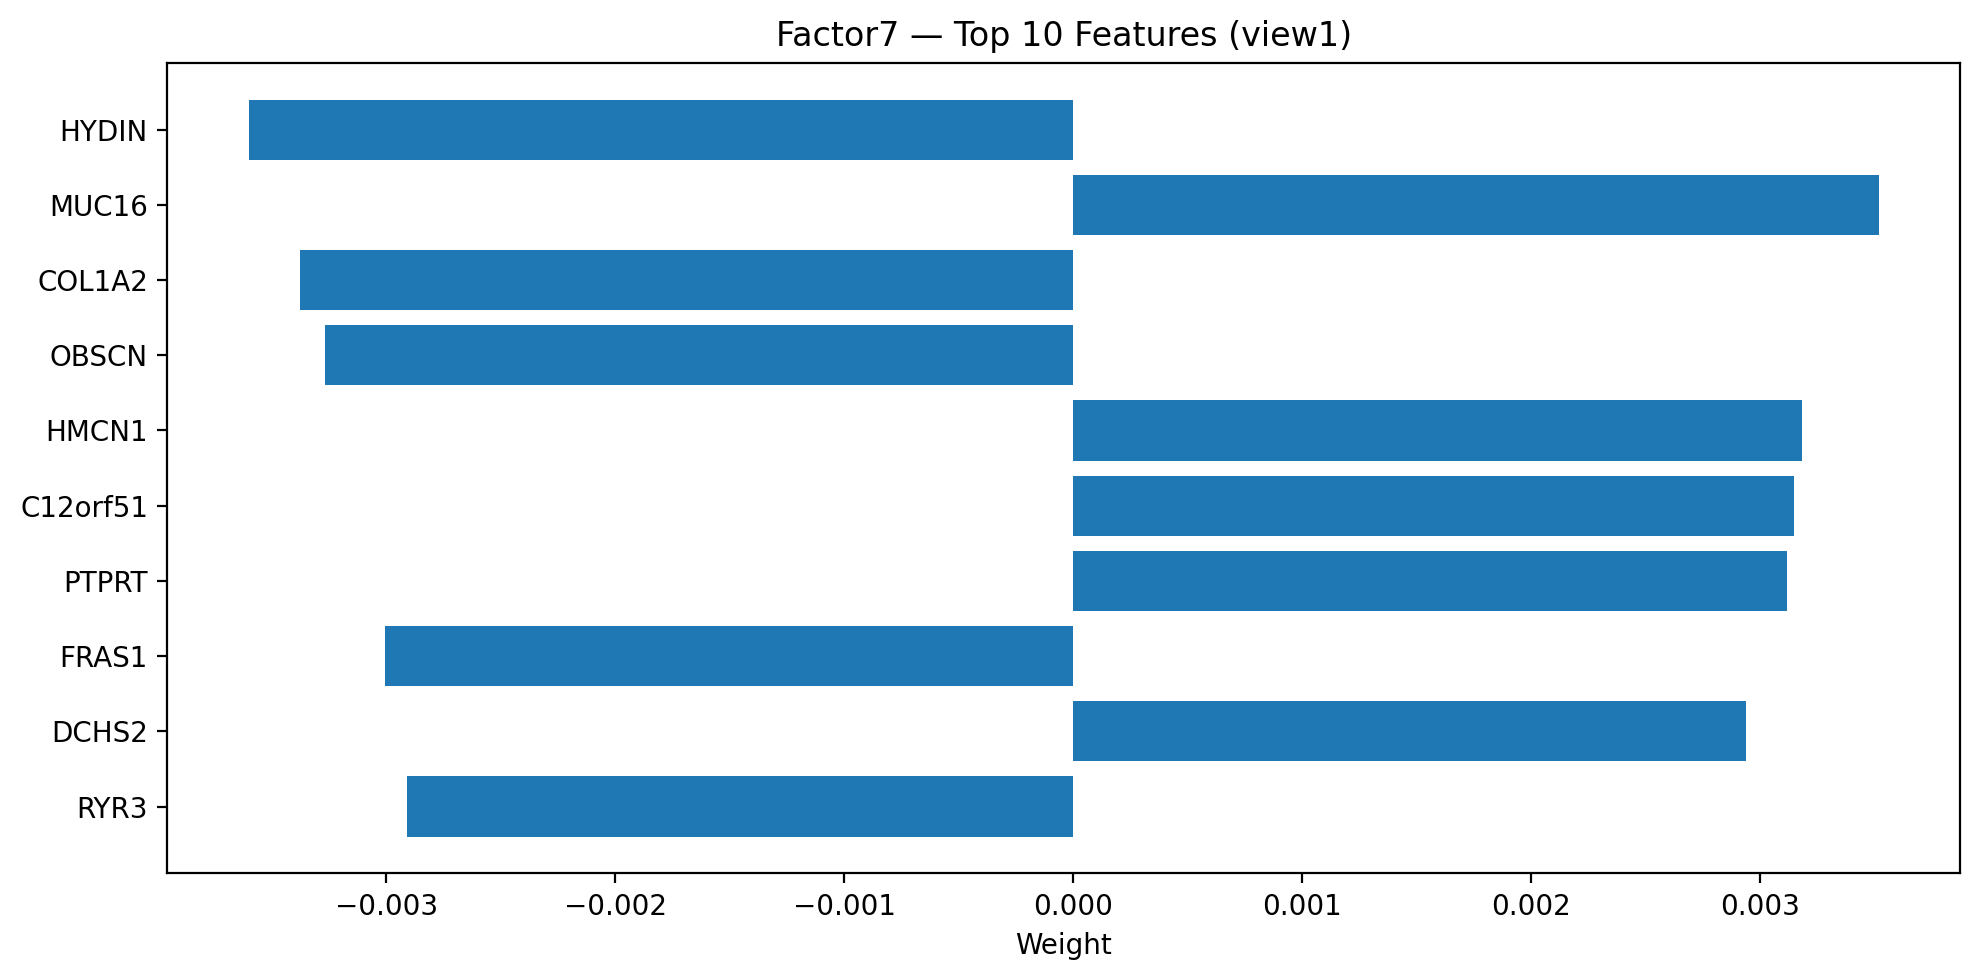

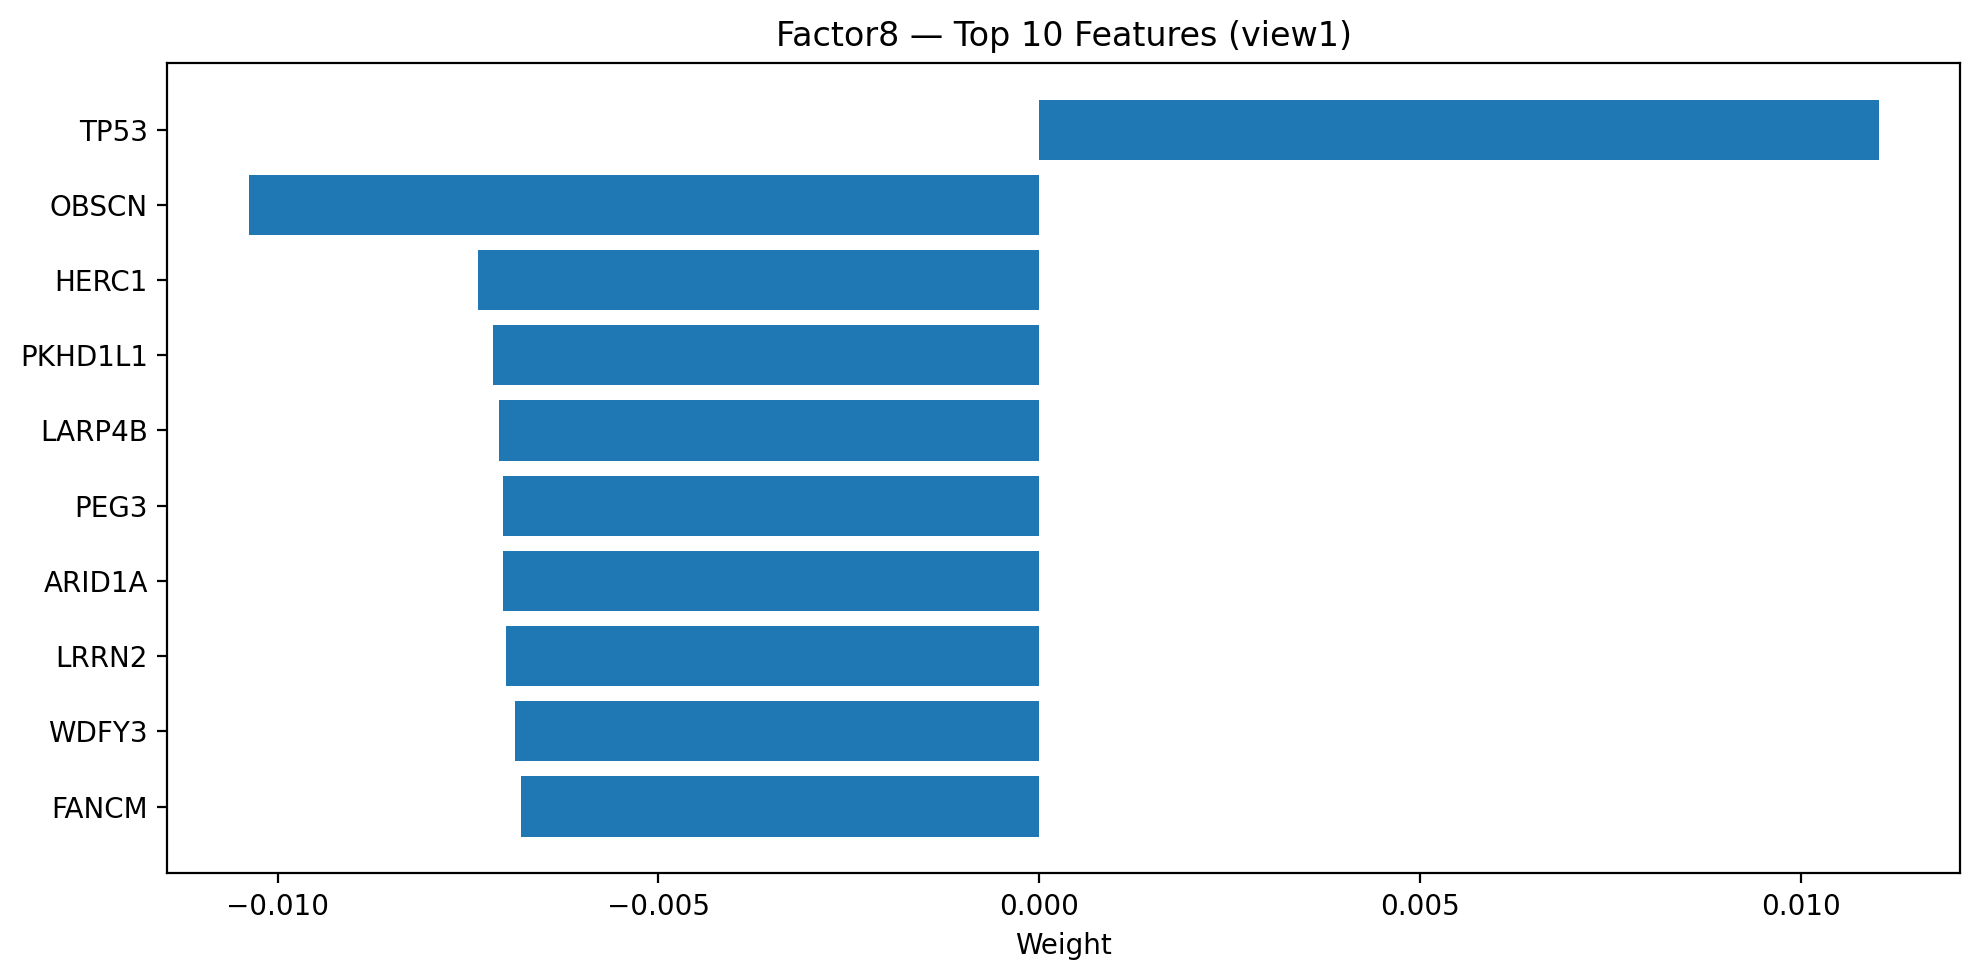

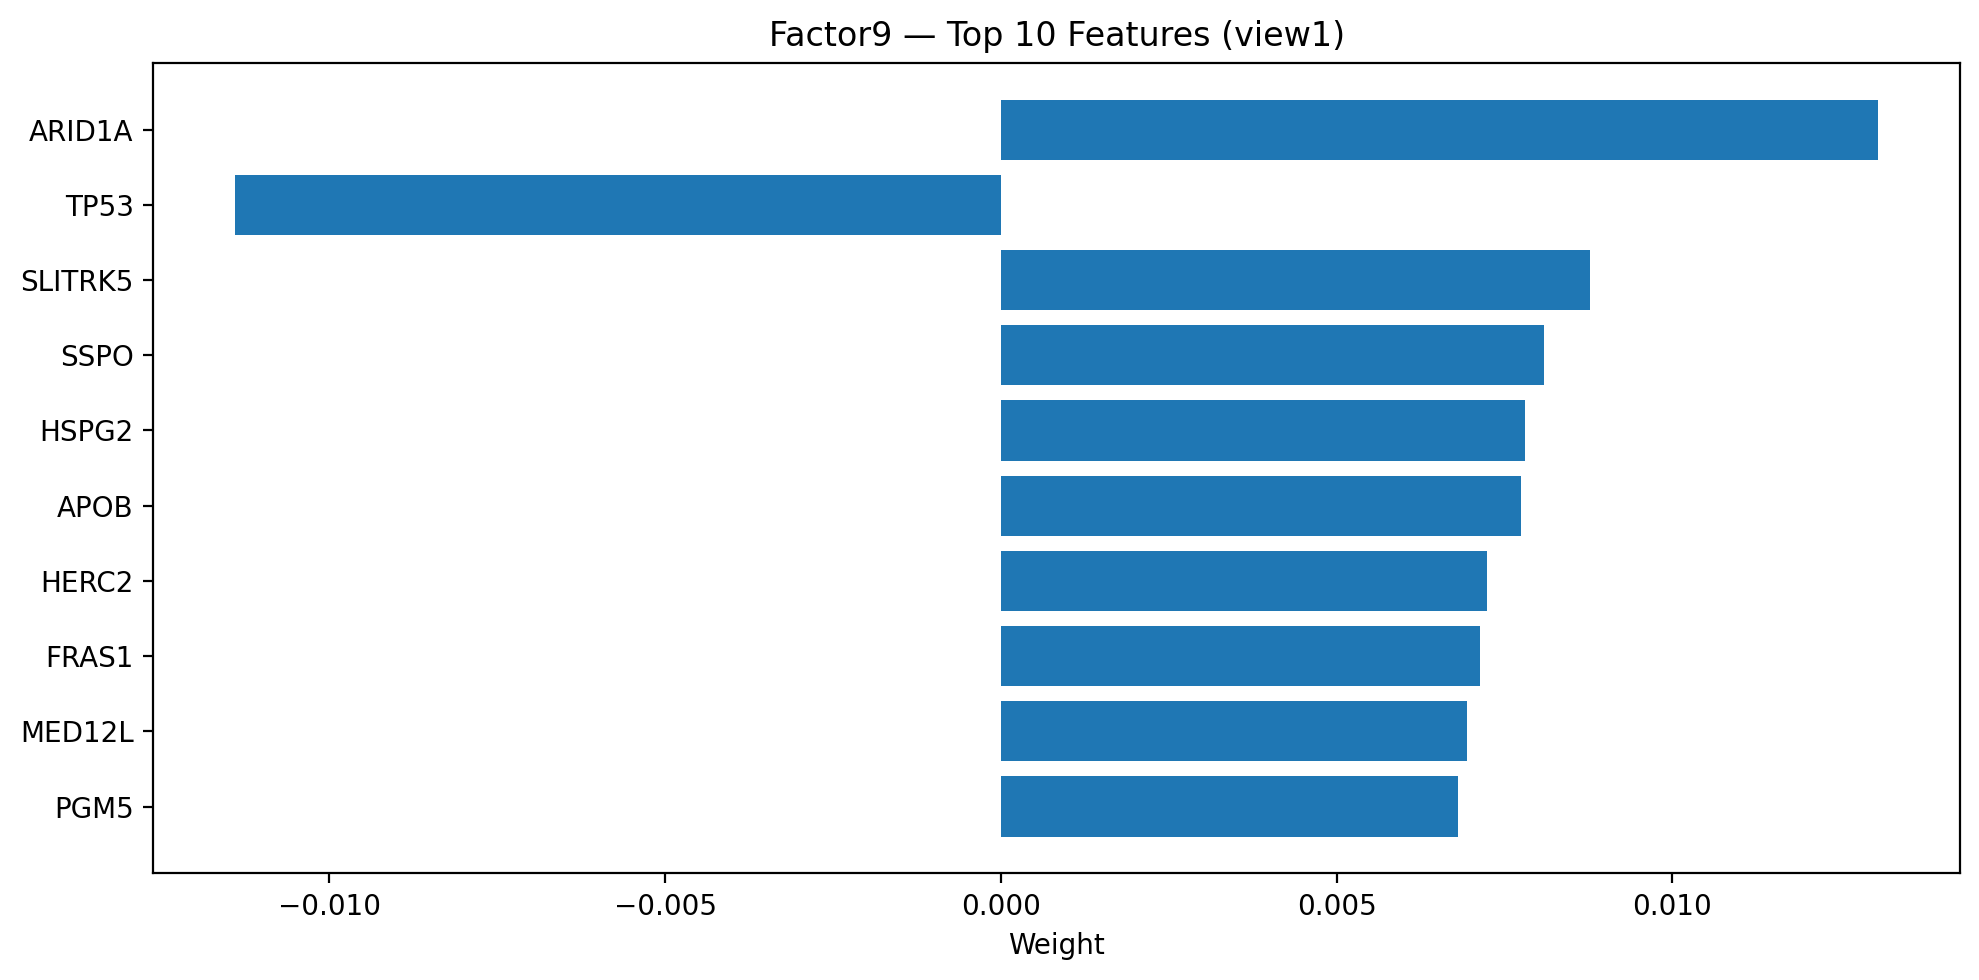

In [20]:
weightsPlot(m, 'view1', mut_df)

#**Plotting Weights, Both Views**

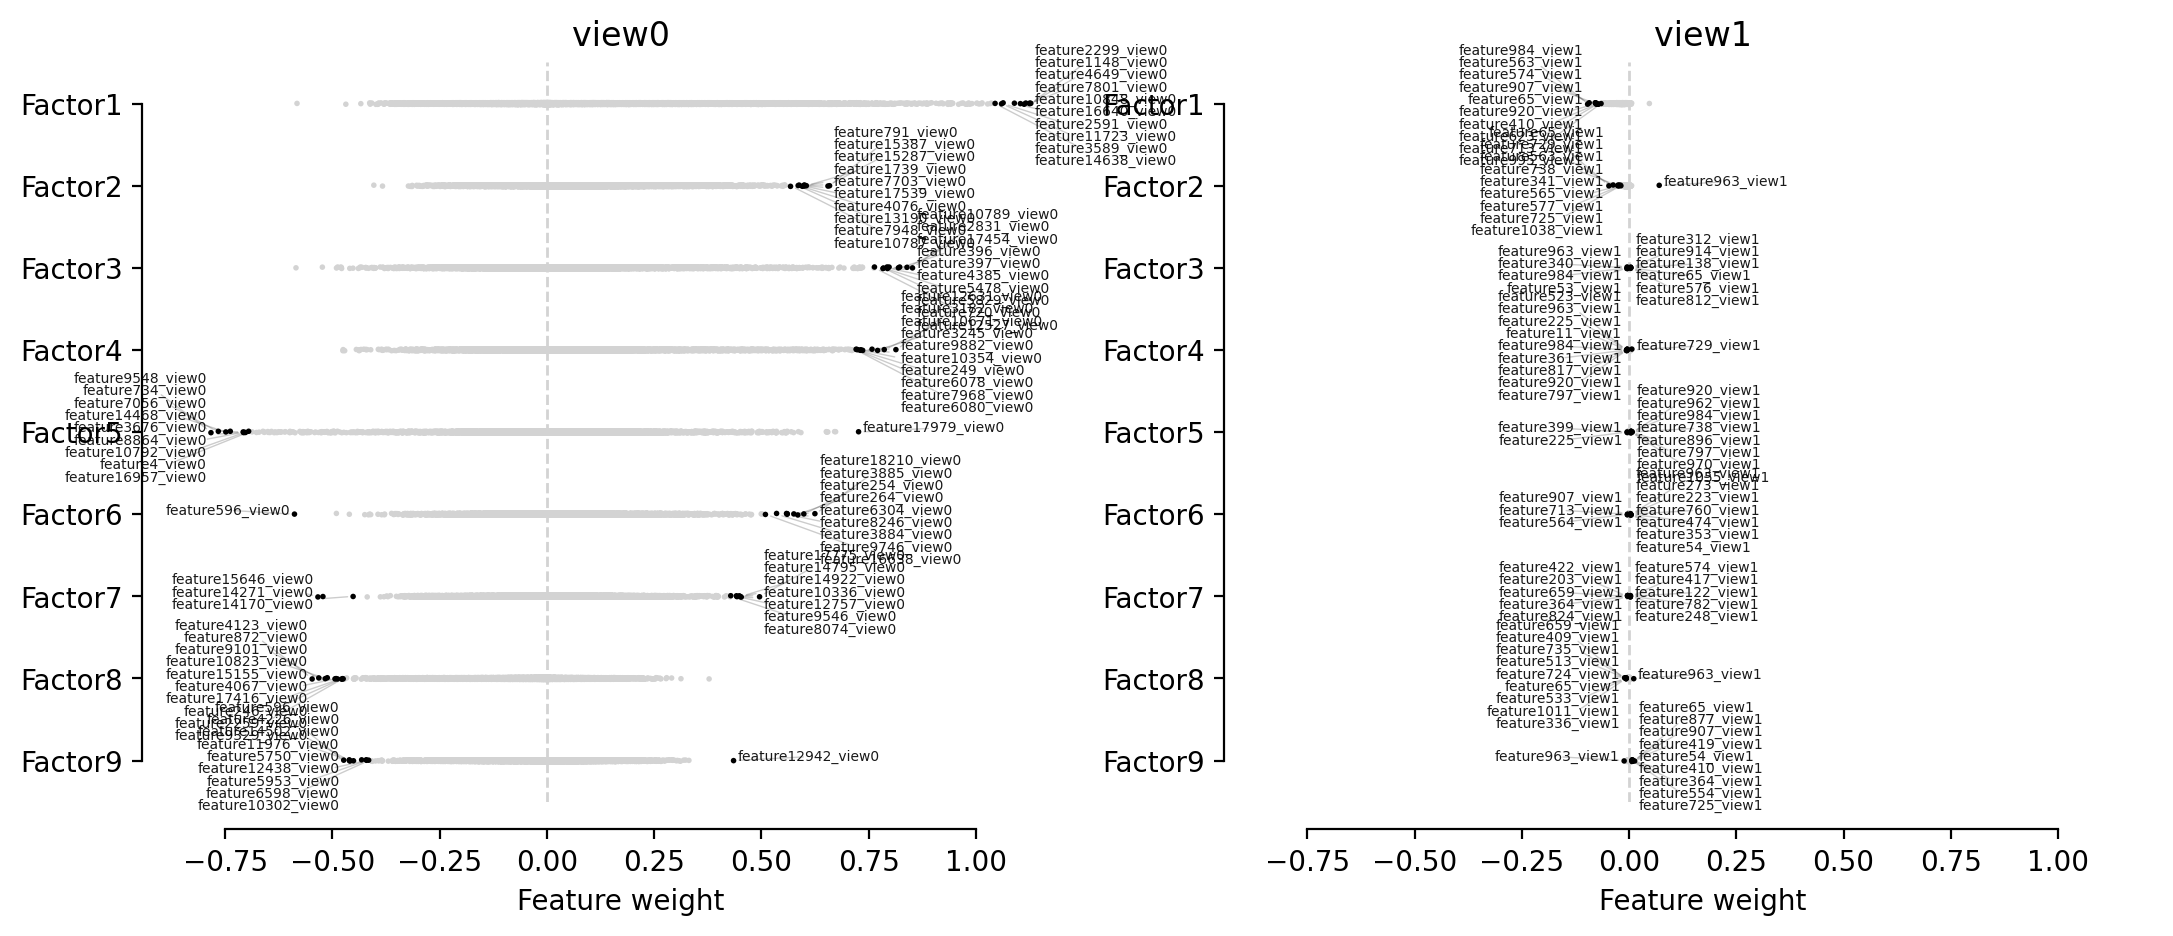

In [21]:
ax = mfx.plot_weights(m, n_features = 10)

#**Weights Ranked**

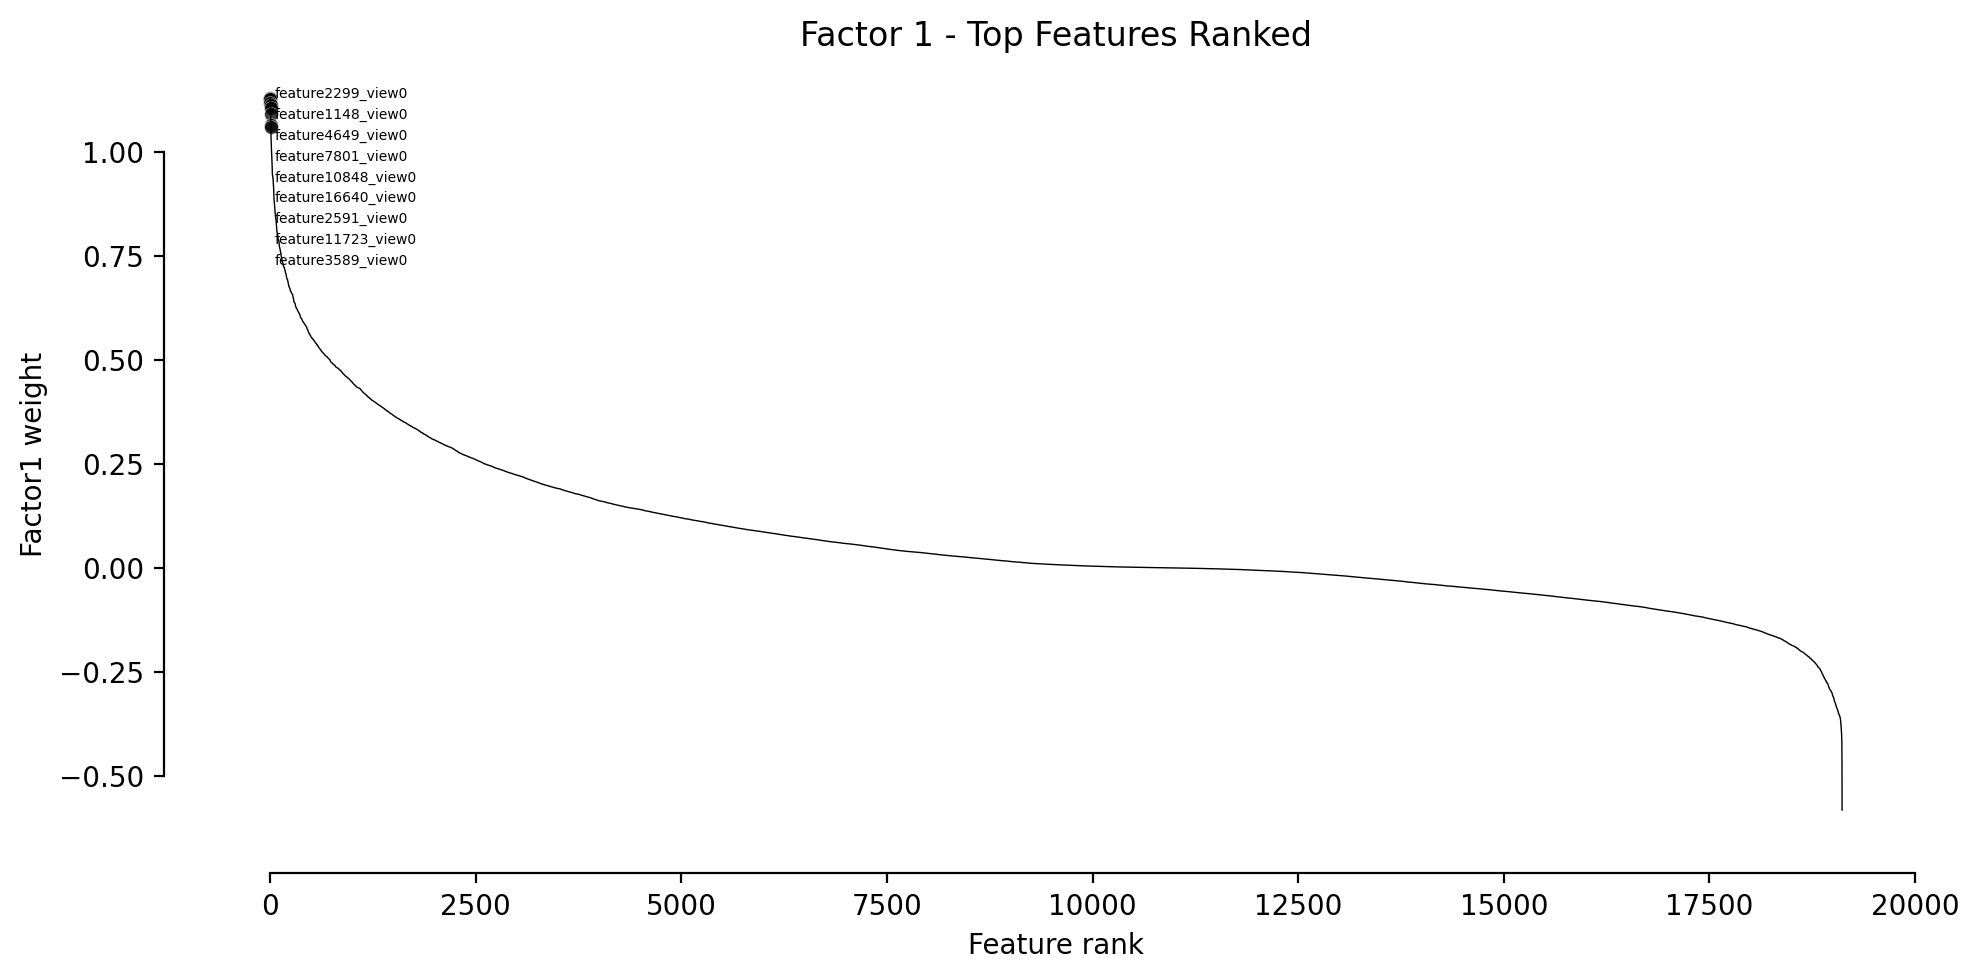

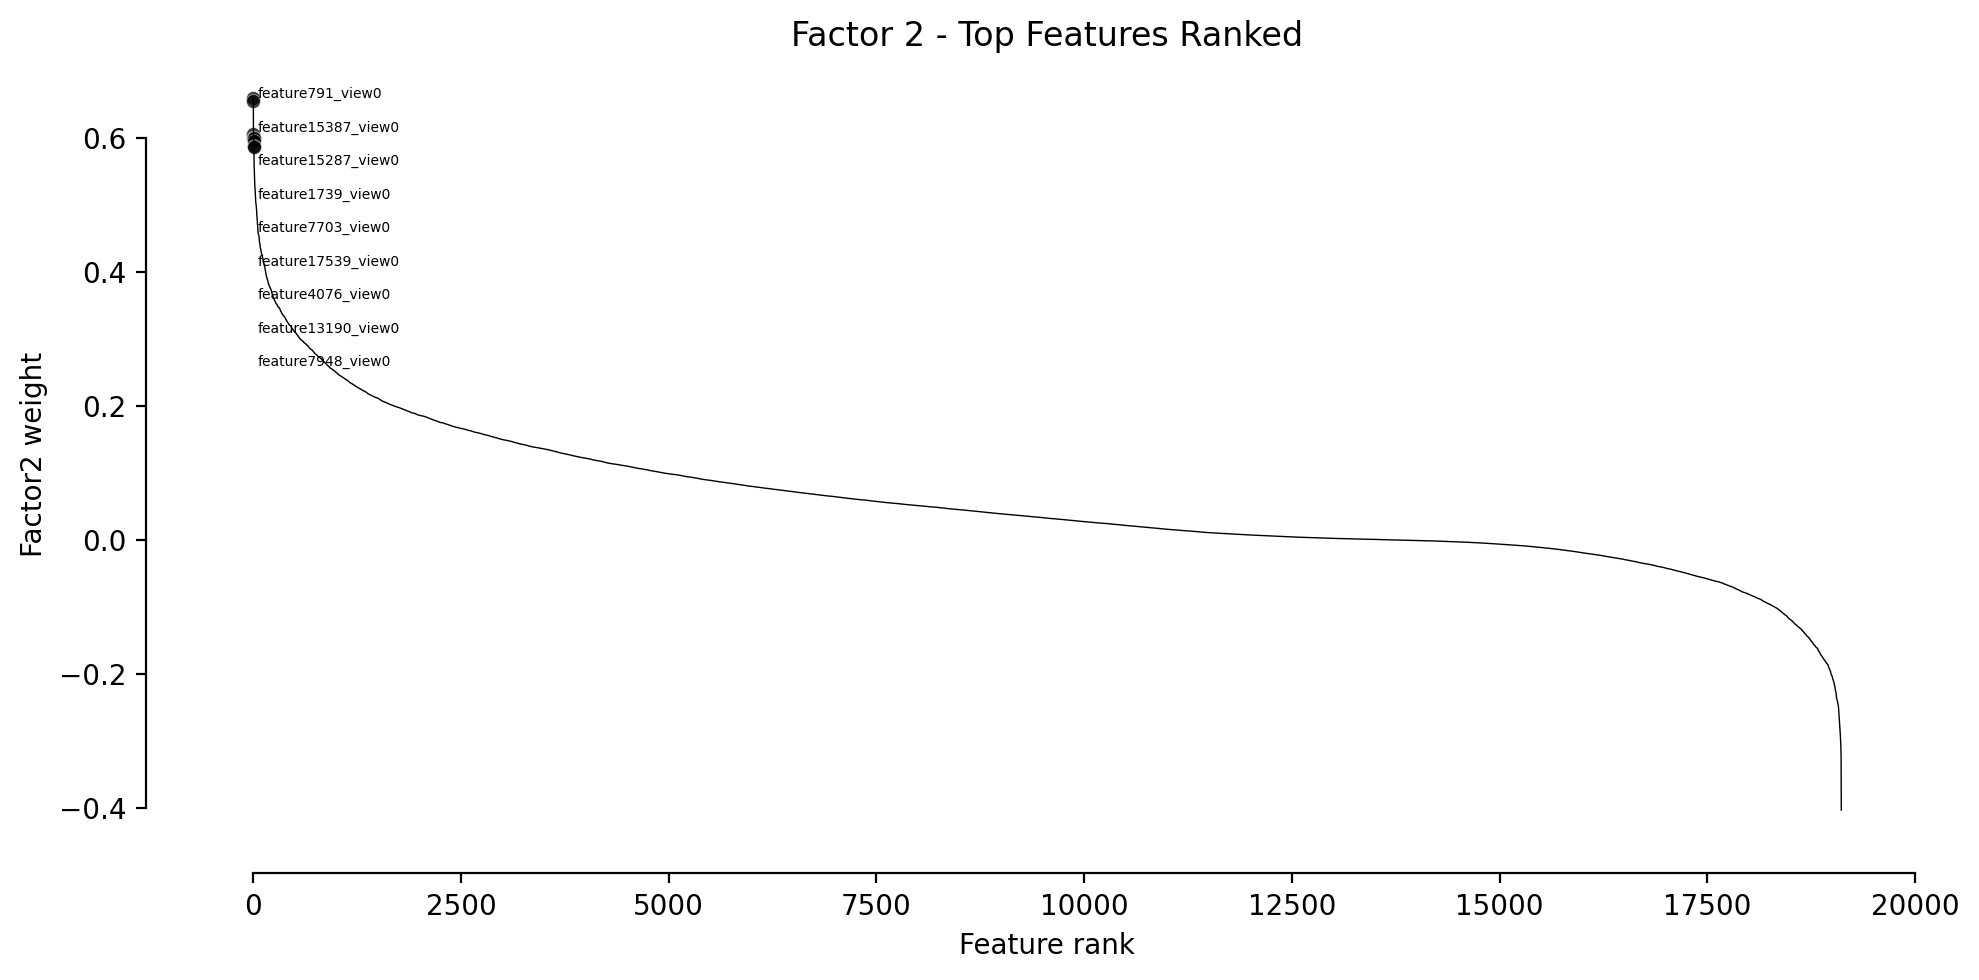

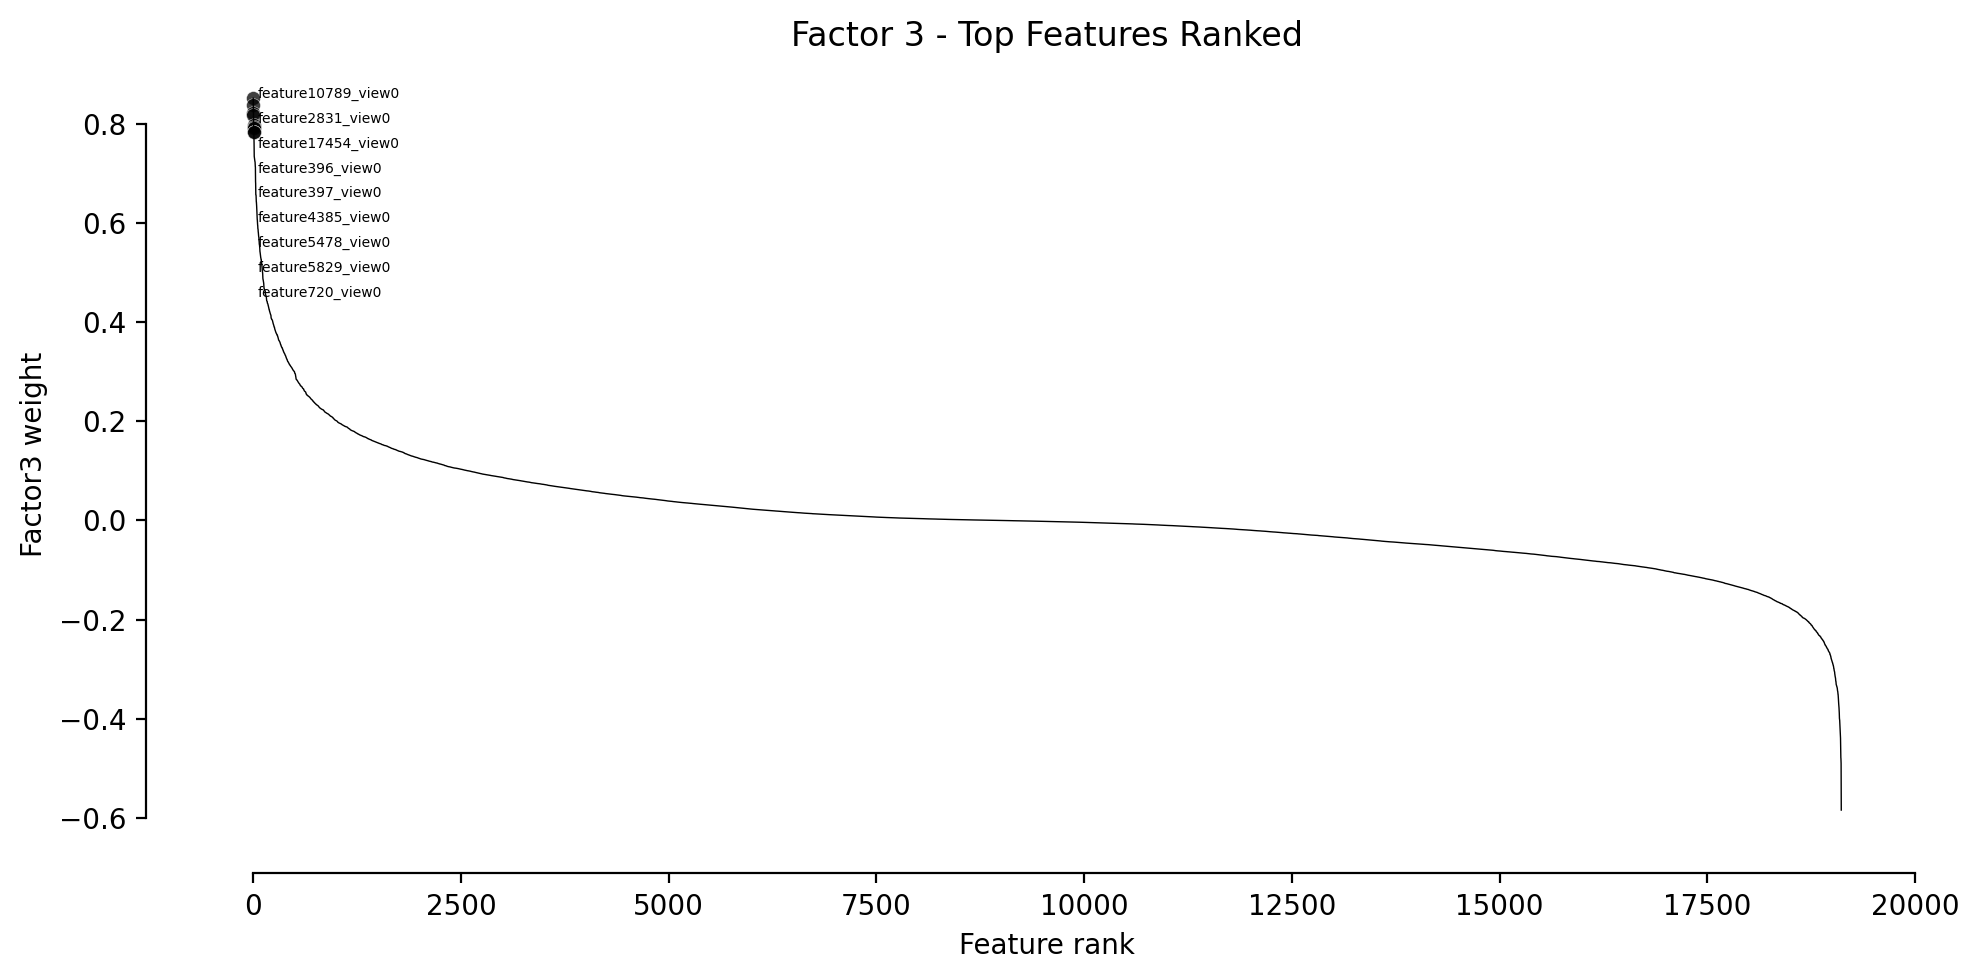

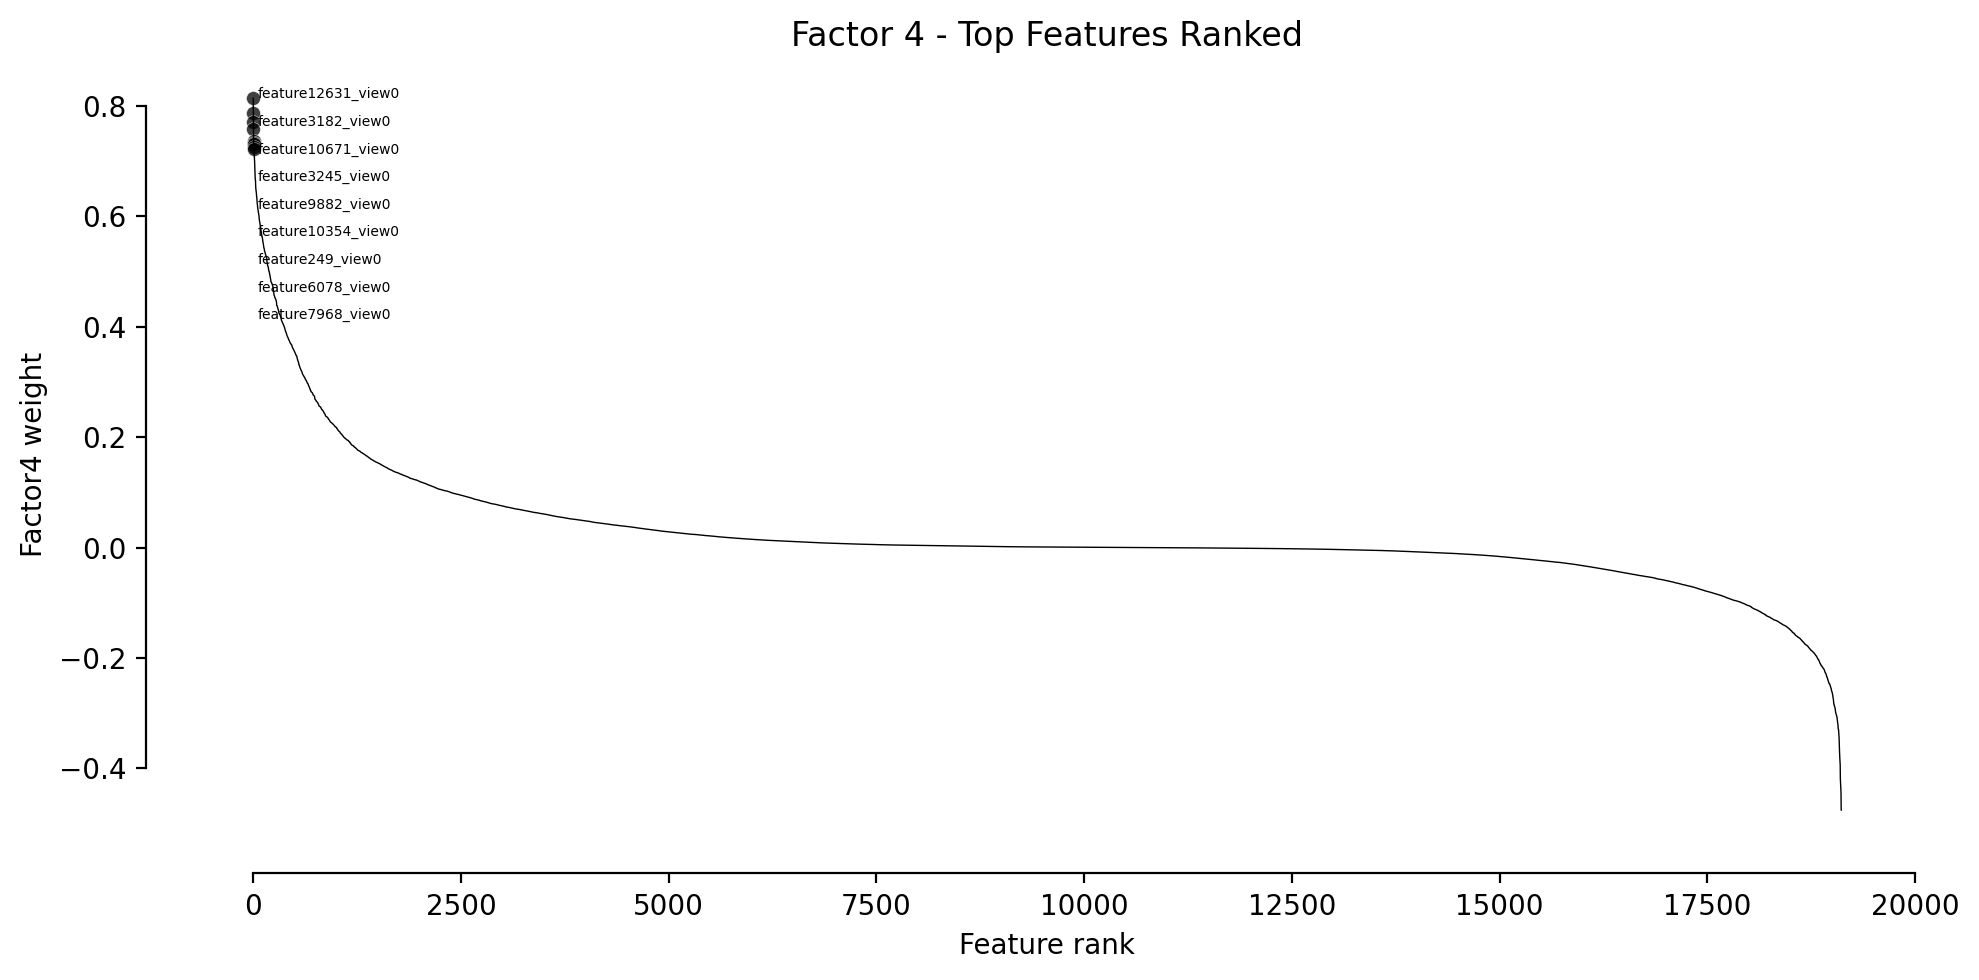

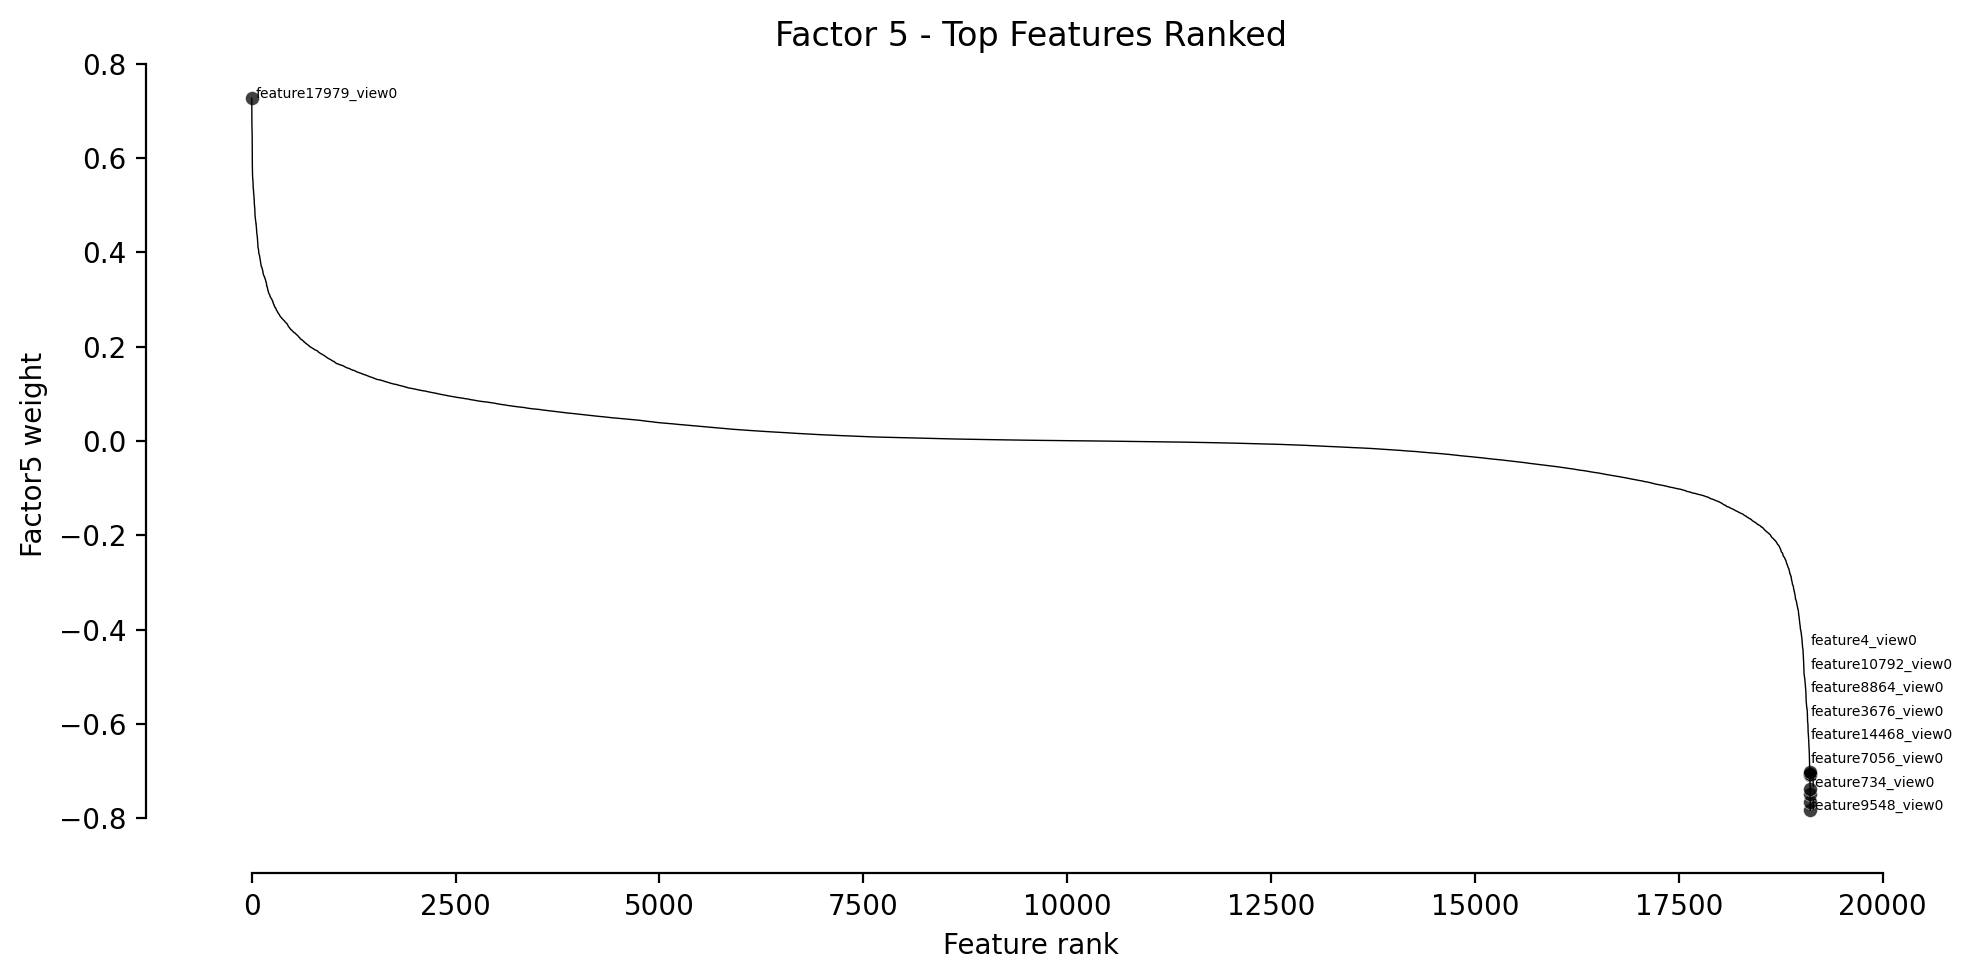

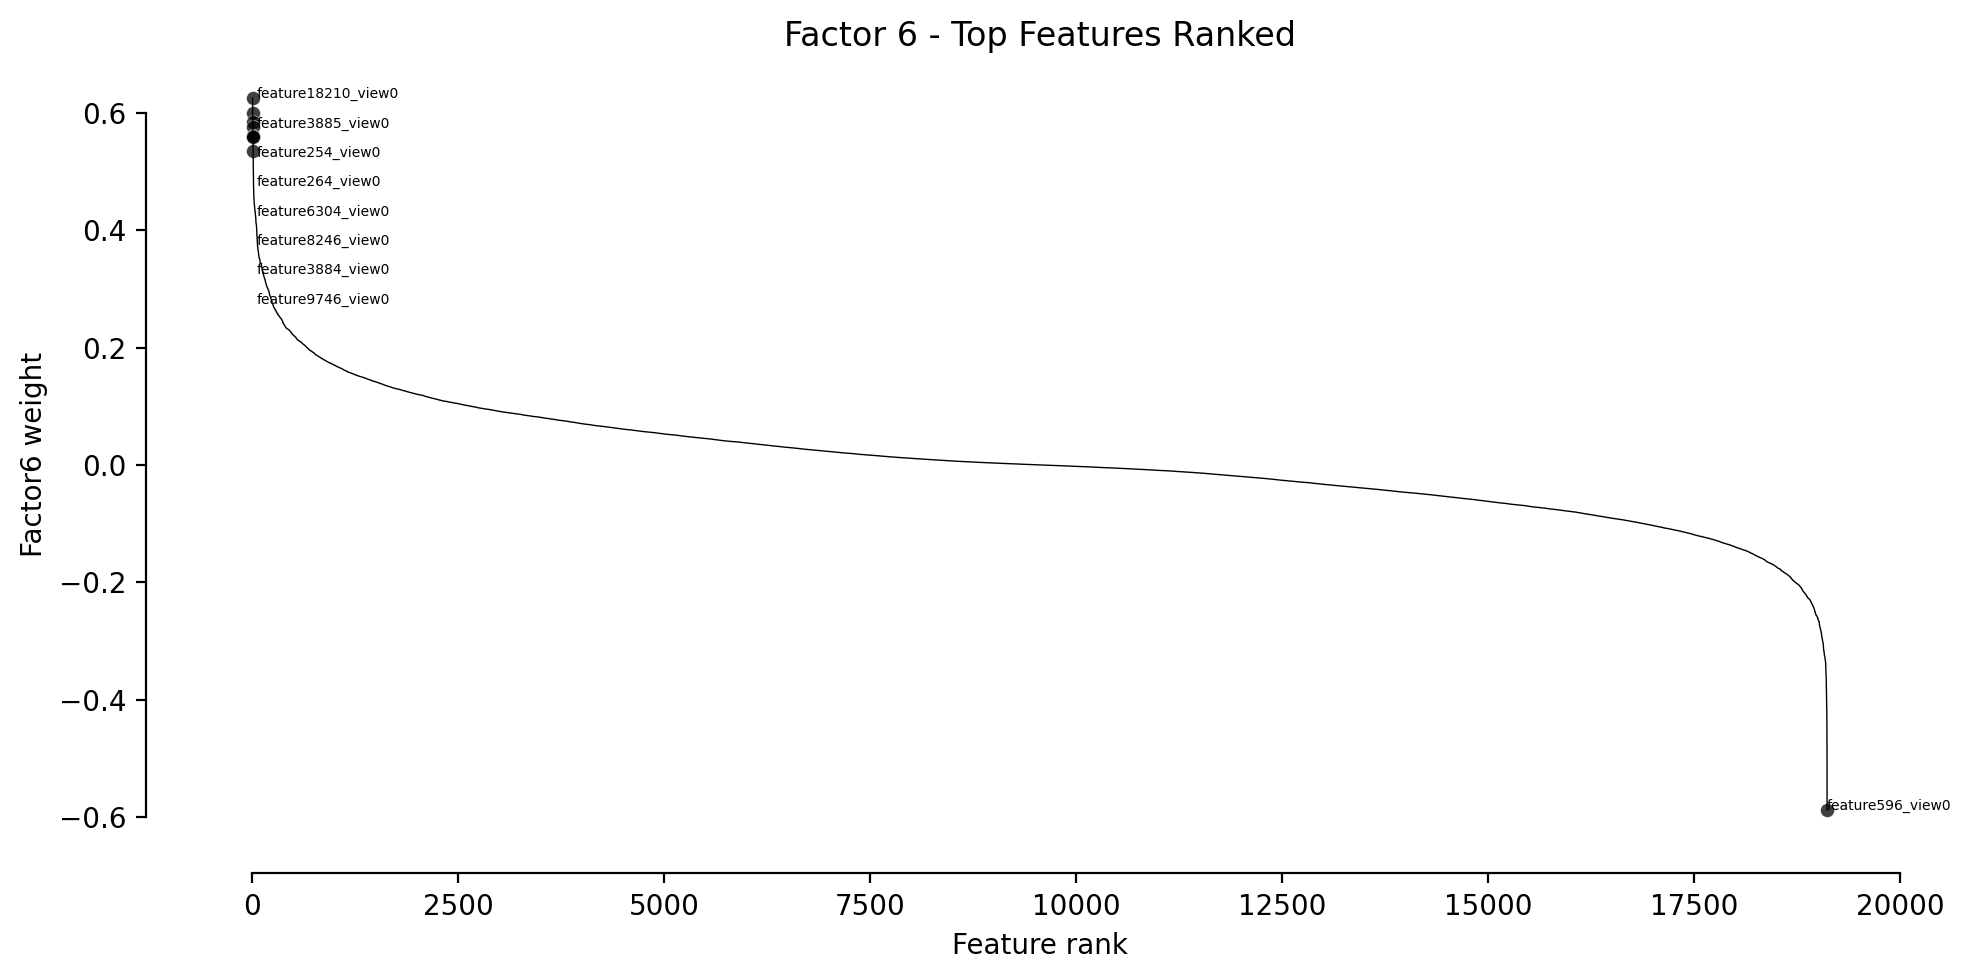

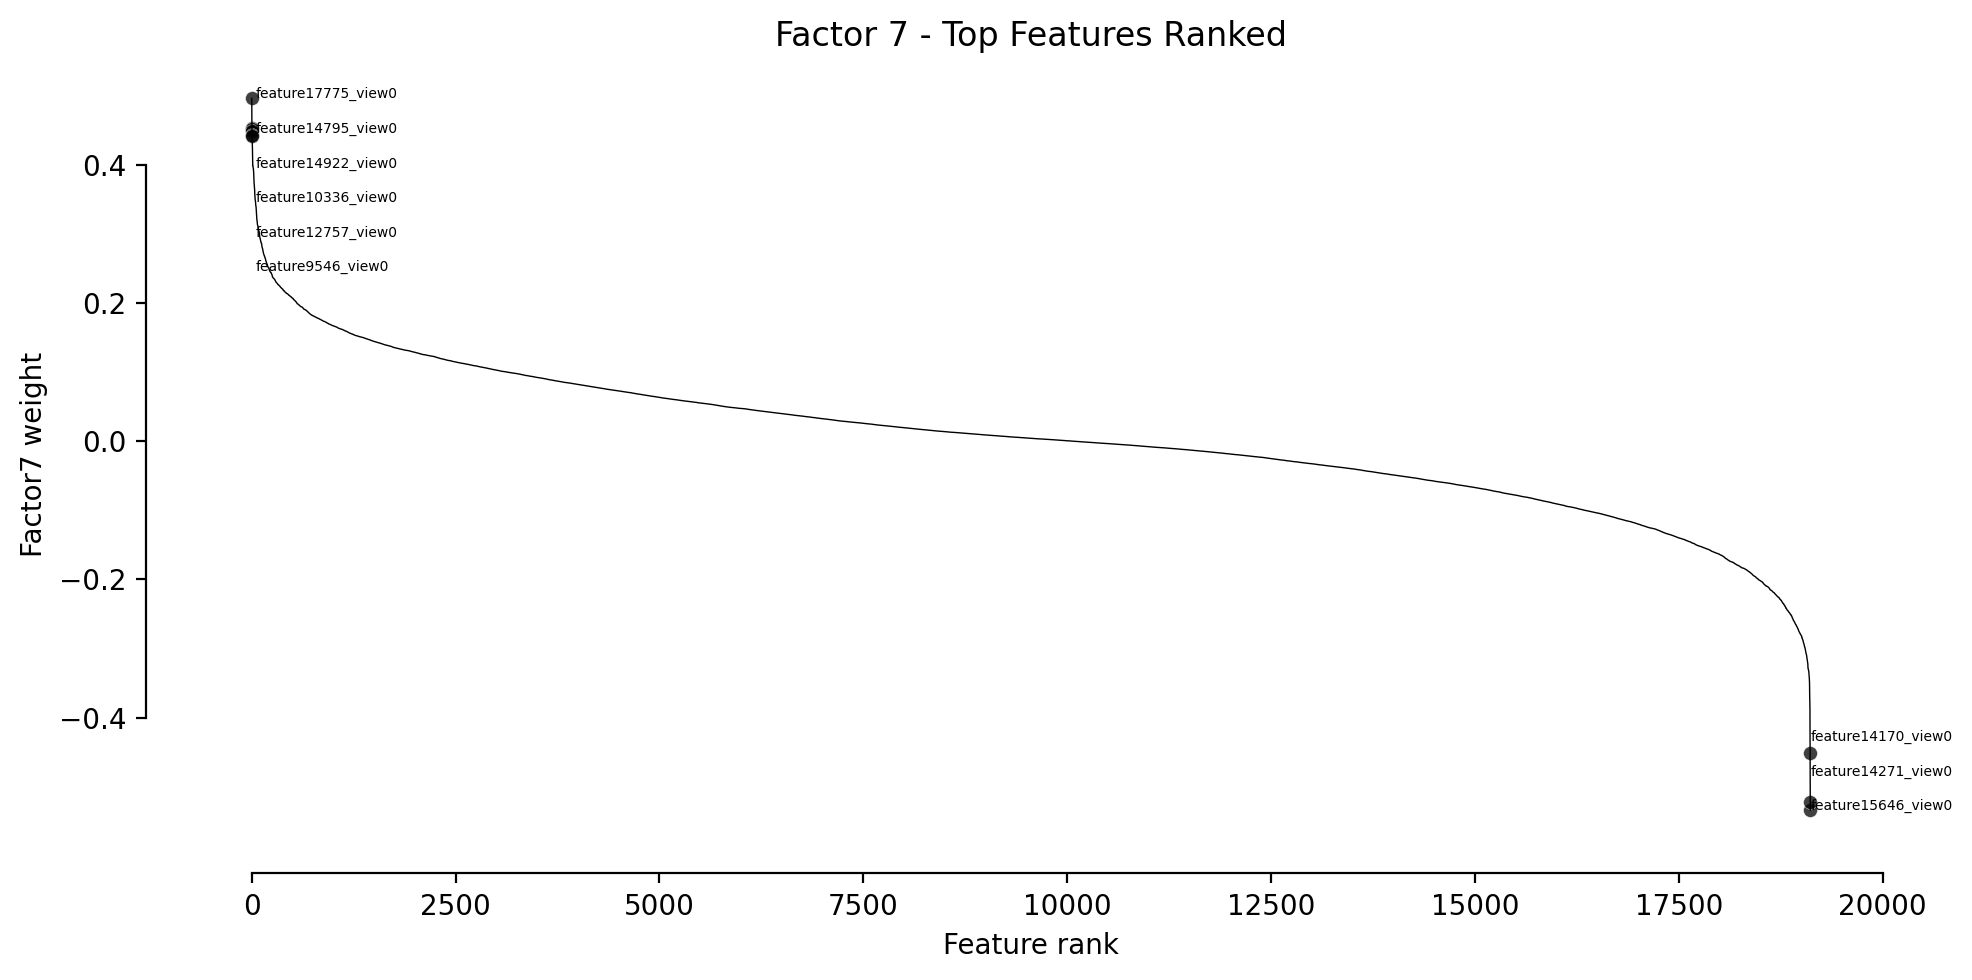

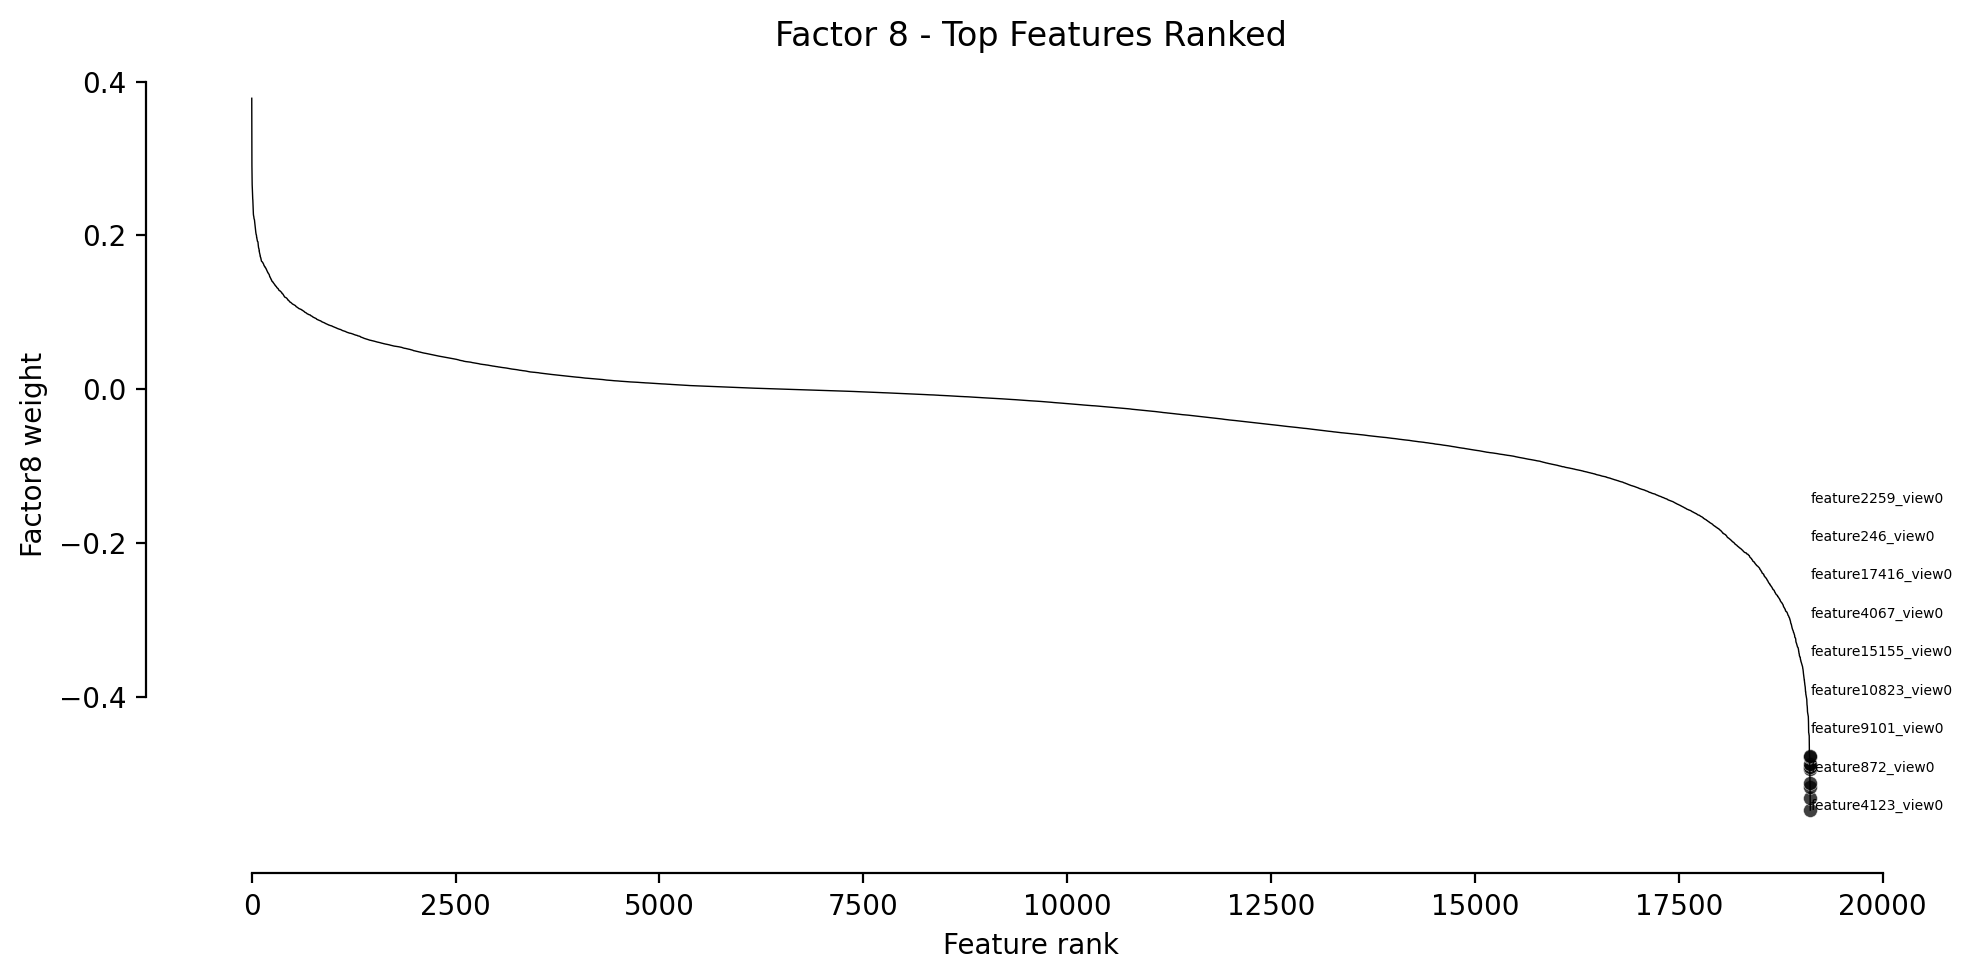

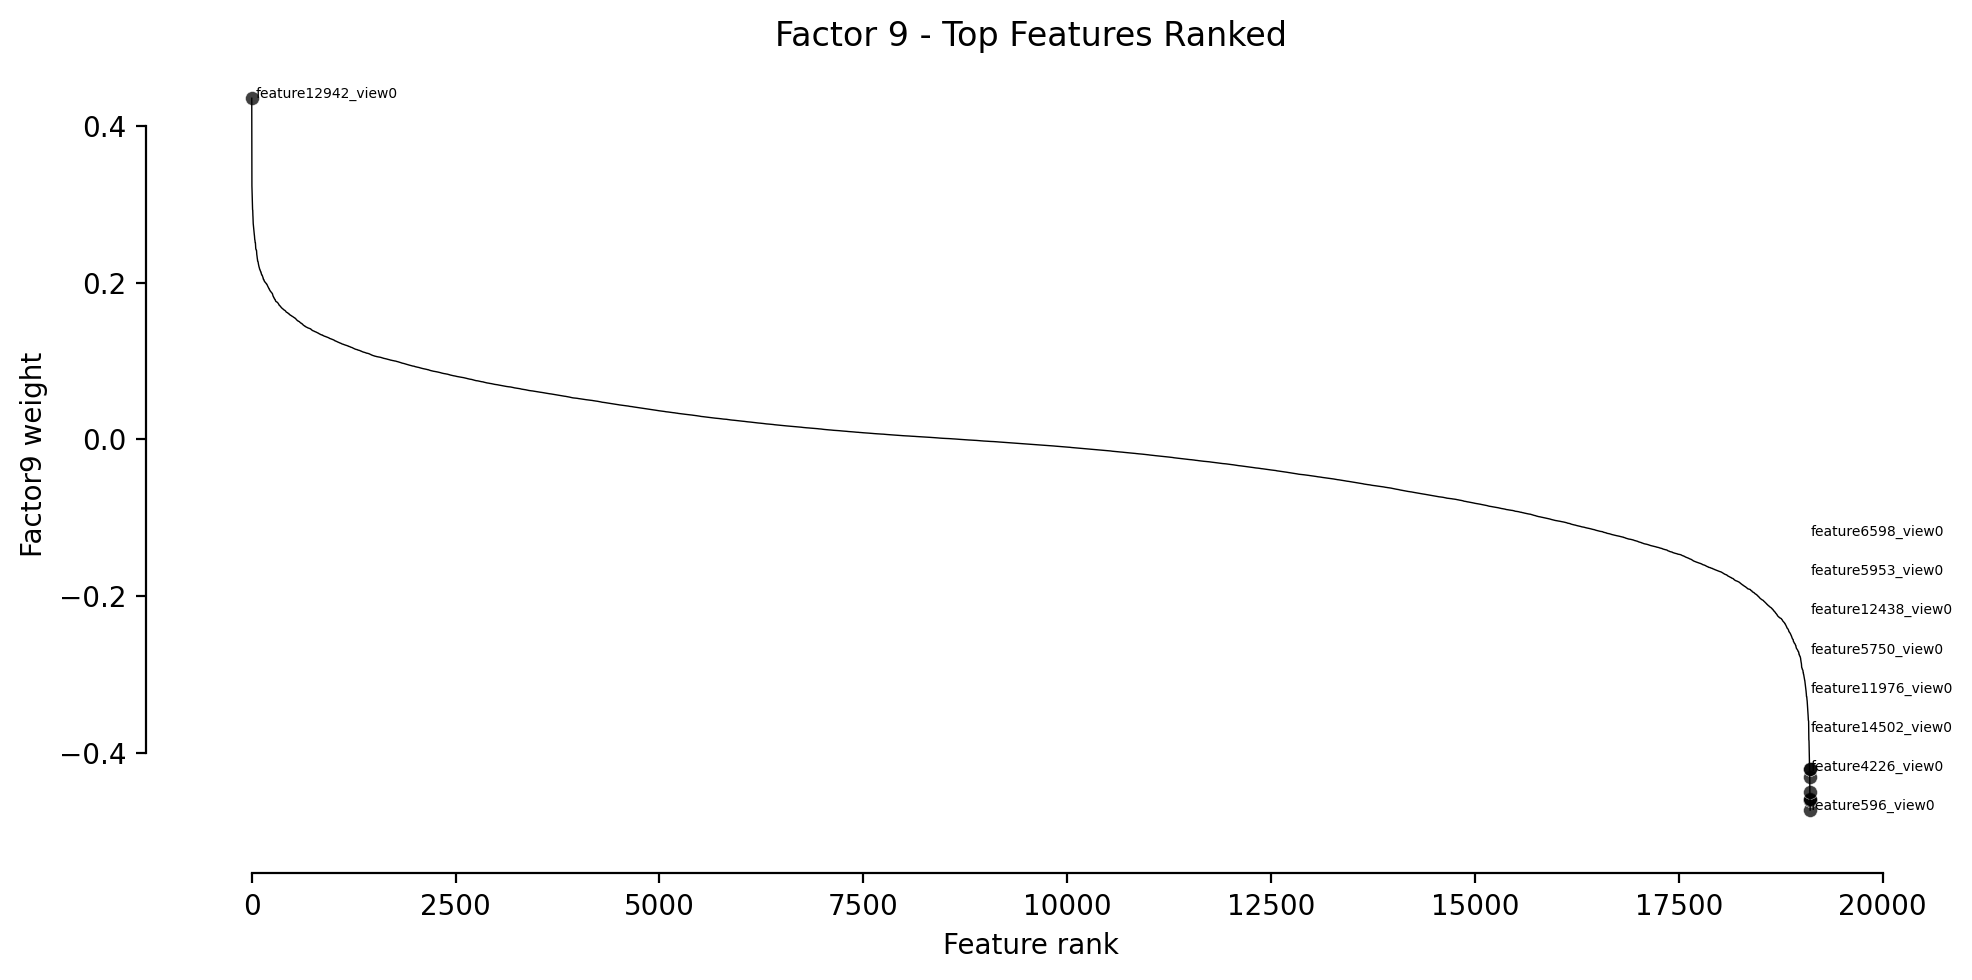

In [22]:
for factor in range(m.get_weights().shape[1]):
  fig, ax = plt.subplots(figsize = (10, 5))
  ax = mfx.plot_weights_ranked(
      m,
      factor = factor,
      n_features = 10,
      y_repel_coef = 0.05,
      x_rank_offset = 50,
      ax = ax
  )

  ax.set_title(f'Factor {factor + 1} - Top Features Ranked')
  fig.tight_layout()
  plt.show()
  print('\n')

#**Variance Explained**

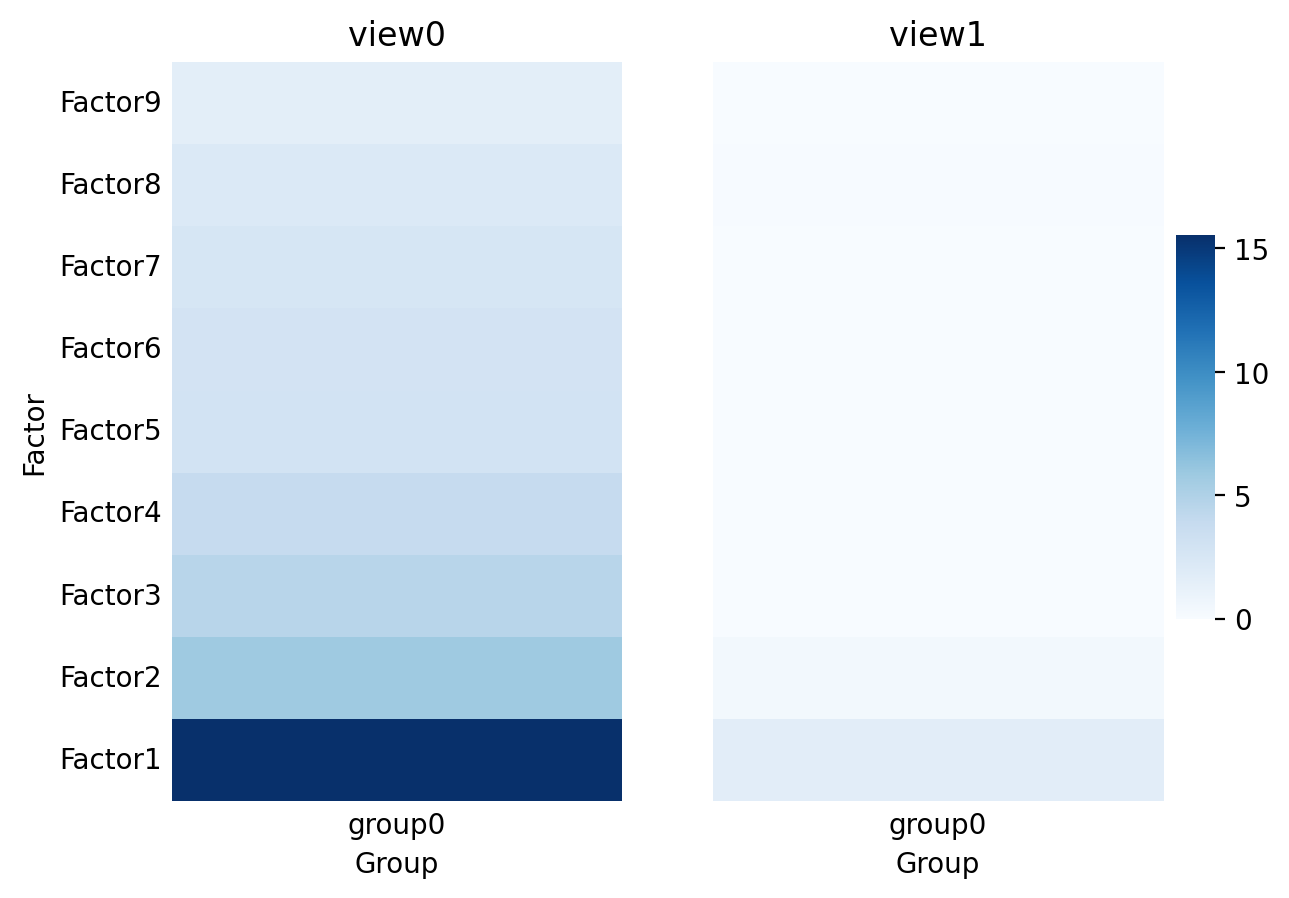

In [23]:
mfx.plot_r2(m, factors = list(range(10)), cmap = 'Blues')

In [24]:
# Mutation View is super weak :(
# Factor 1 is VERY strong in RNA view !! driving its results
# - factors 2 & 3 kind of follow through

#**Factor Correlation**

<Axes: >

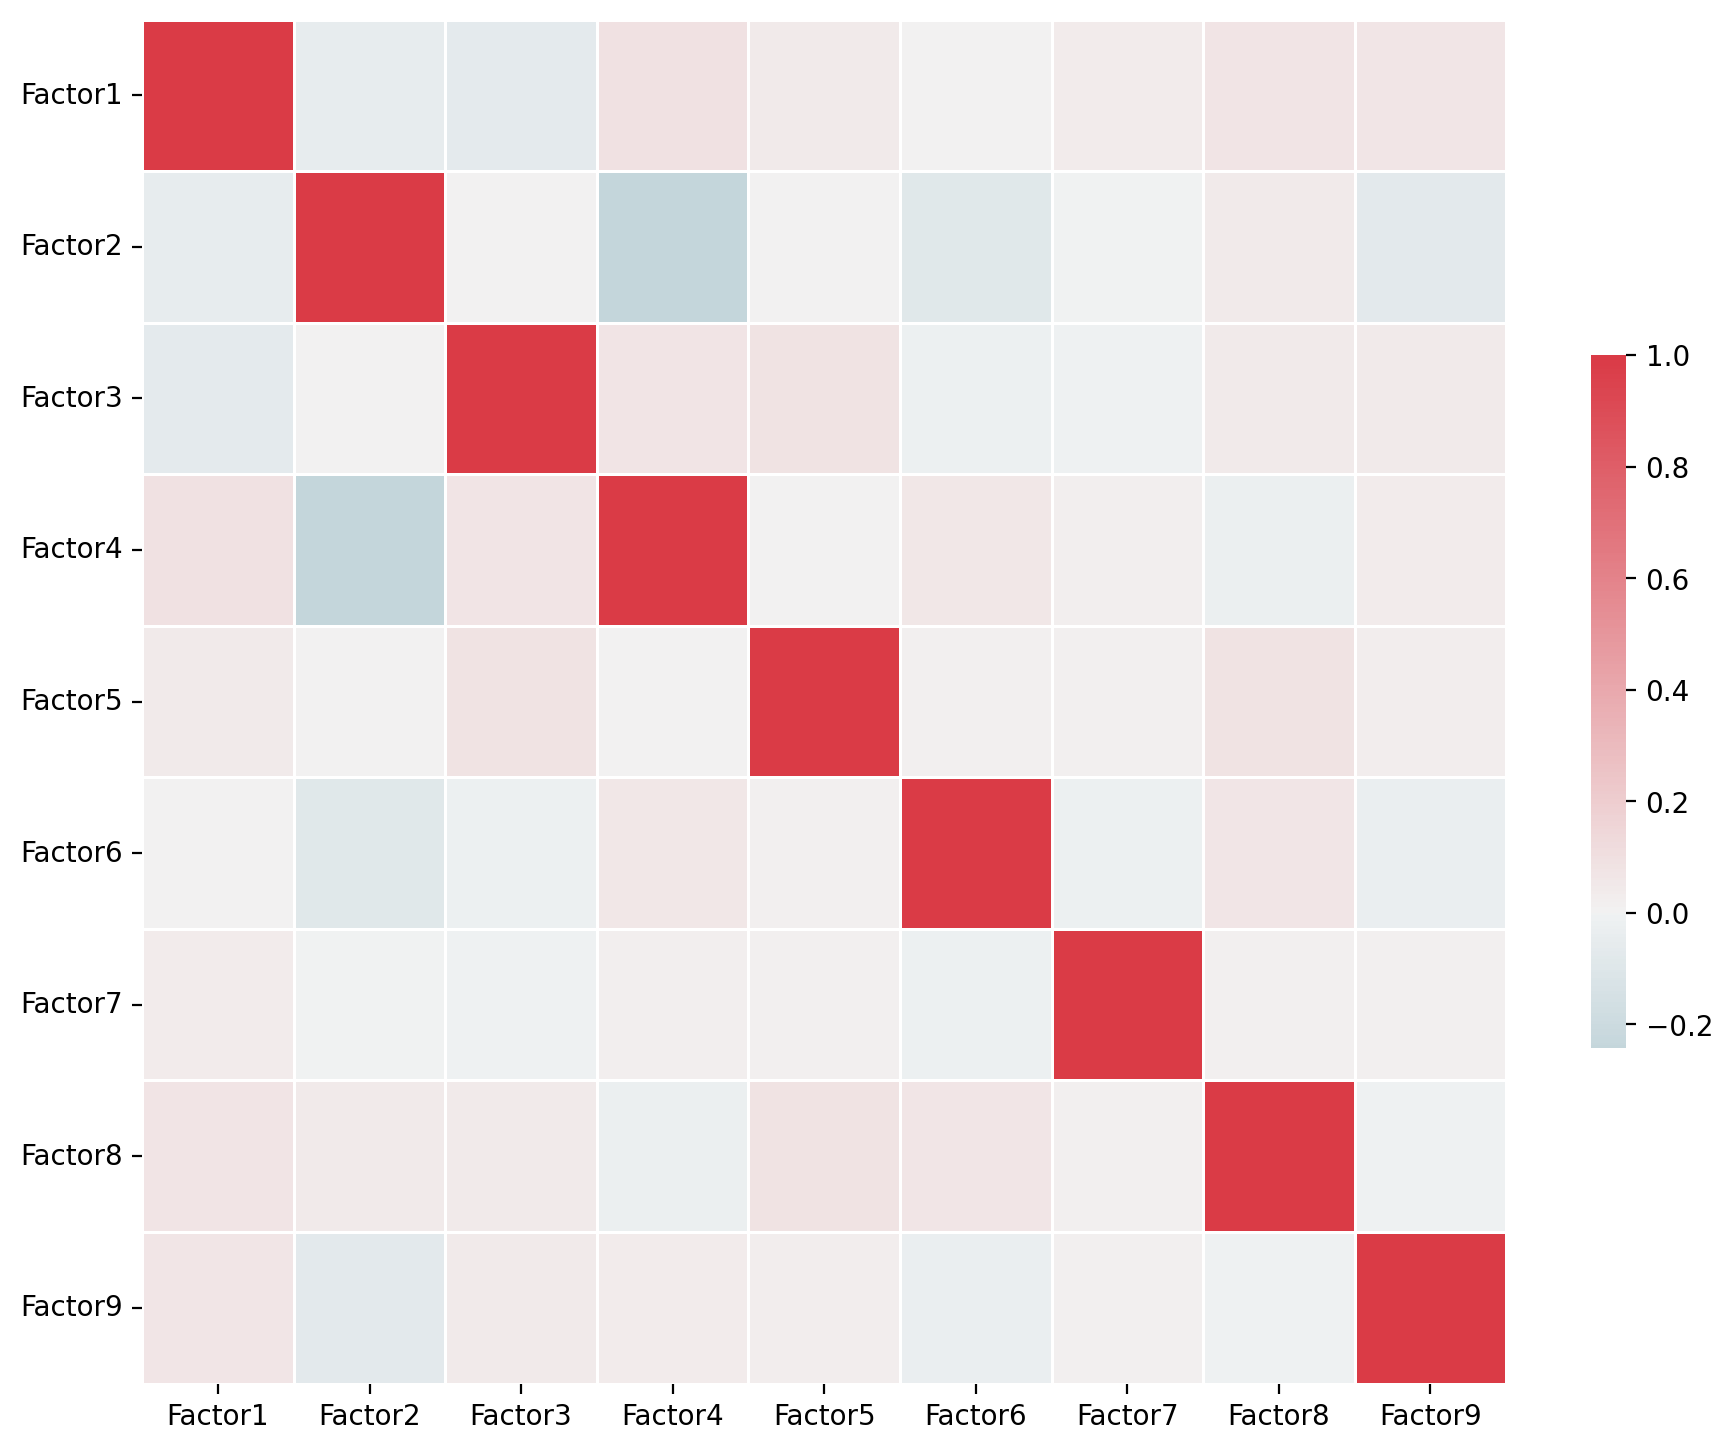

In [25]:
mfx.plot_weights_correlation(m)

In [26]:
# factors are mostlyyyy uncorrelated, thus showing independence
# - so eahc factoor gives unique bio ingo (no overlap)

#**Factors and Features Heatmap**

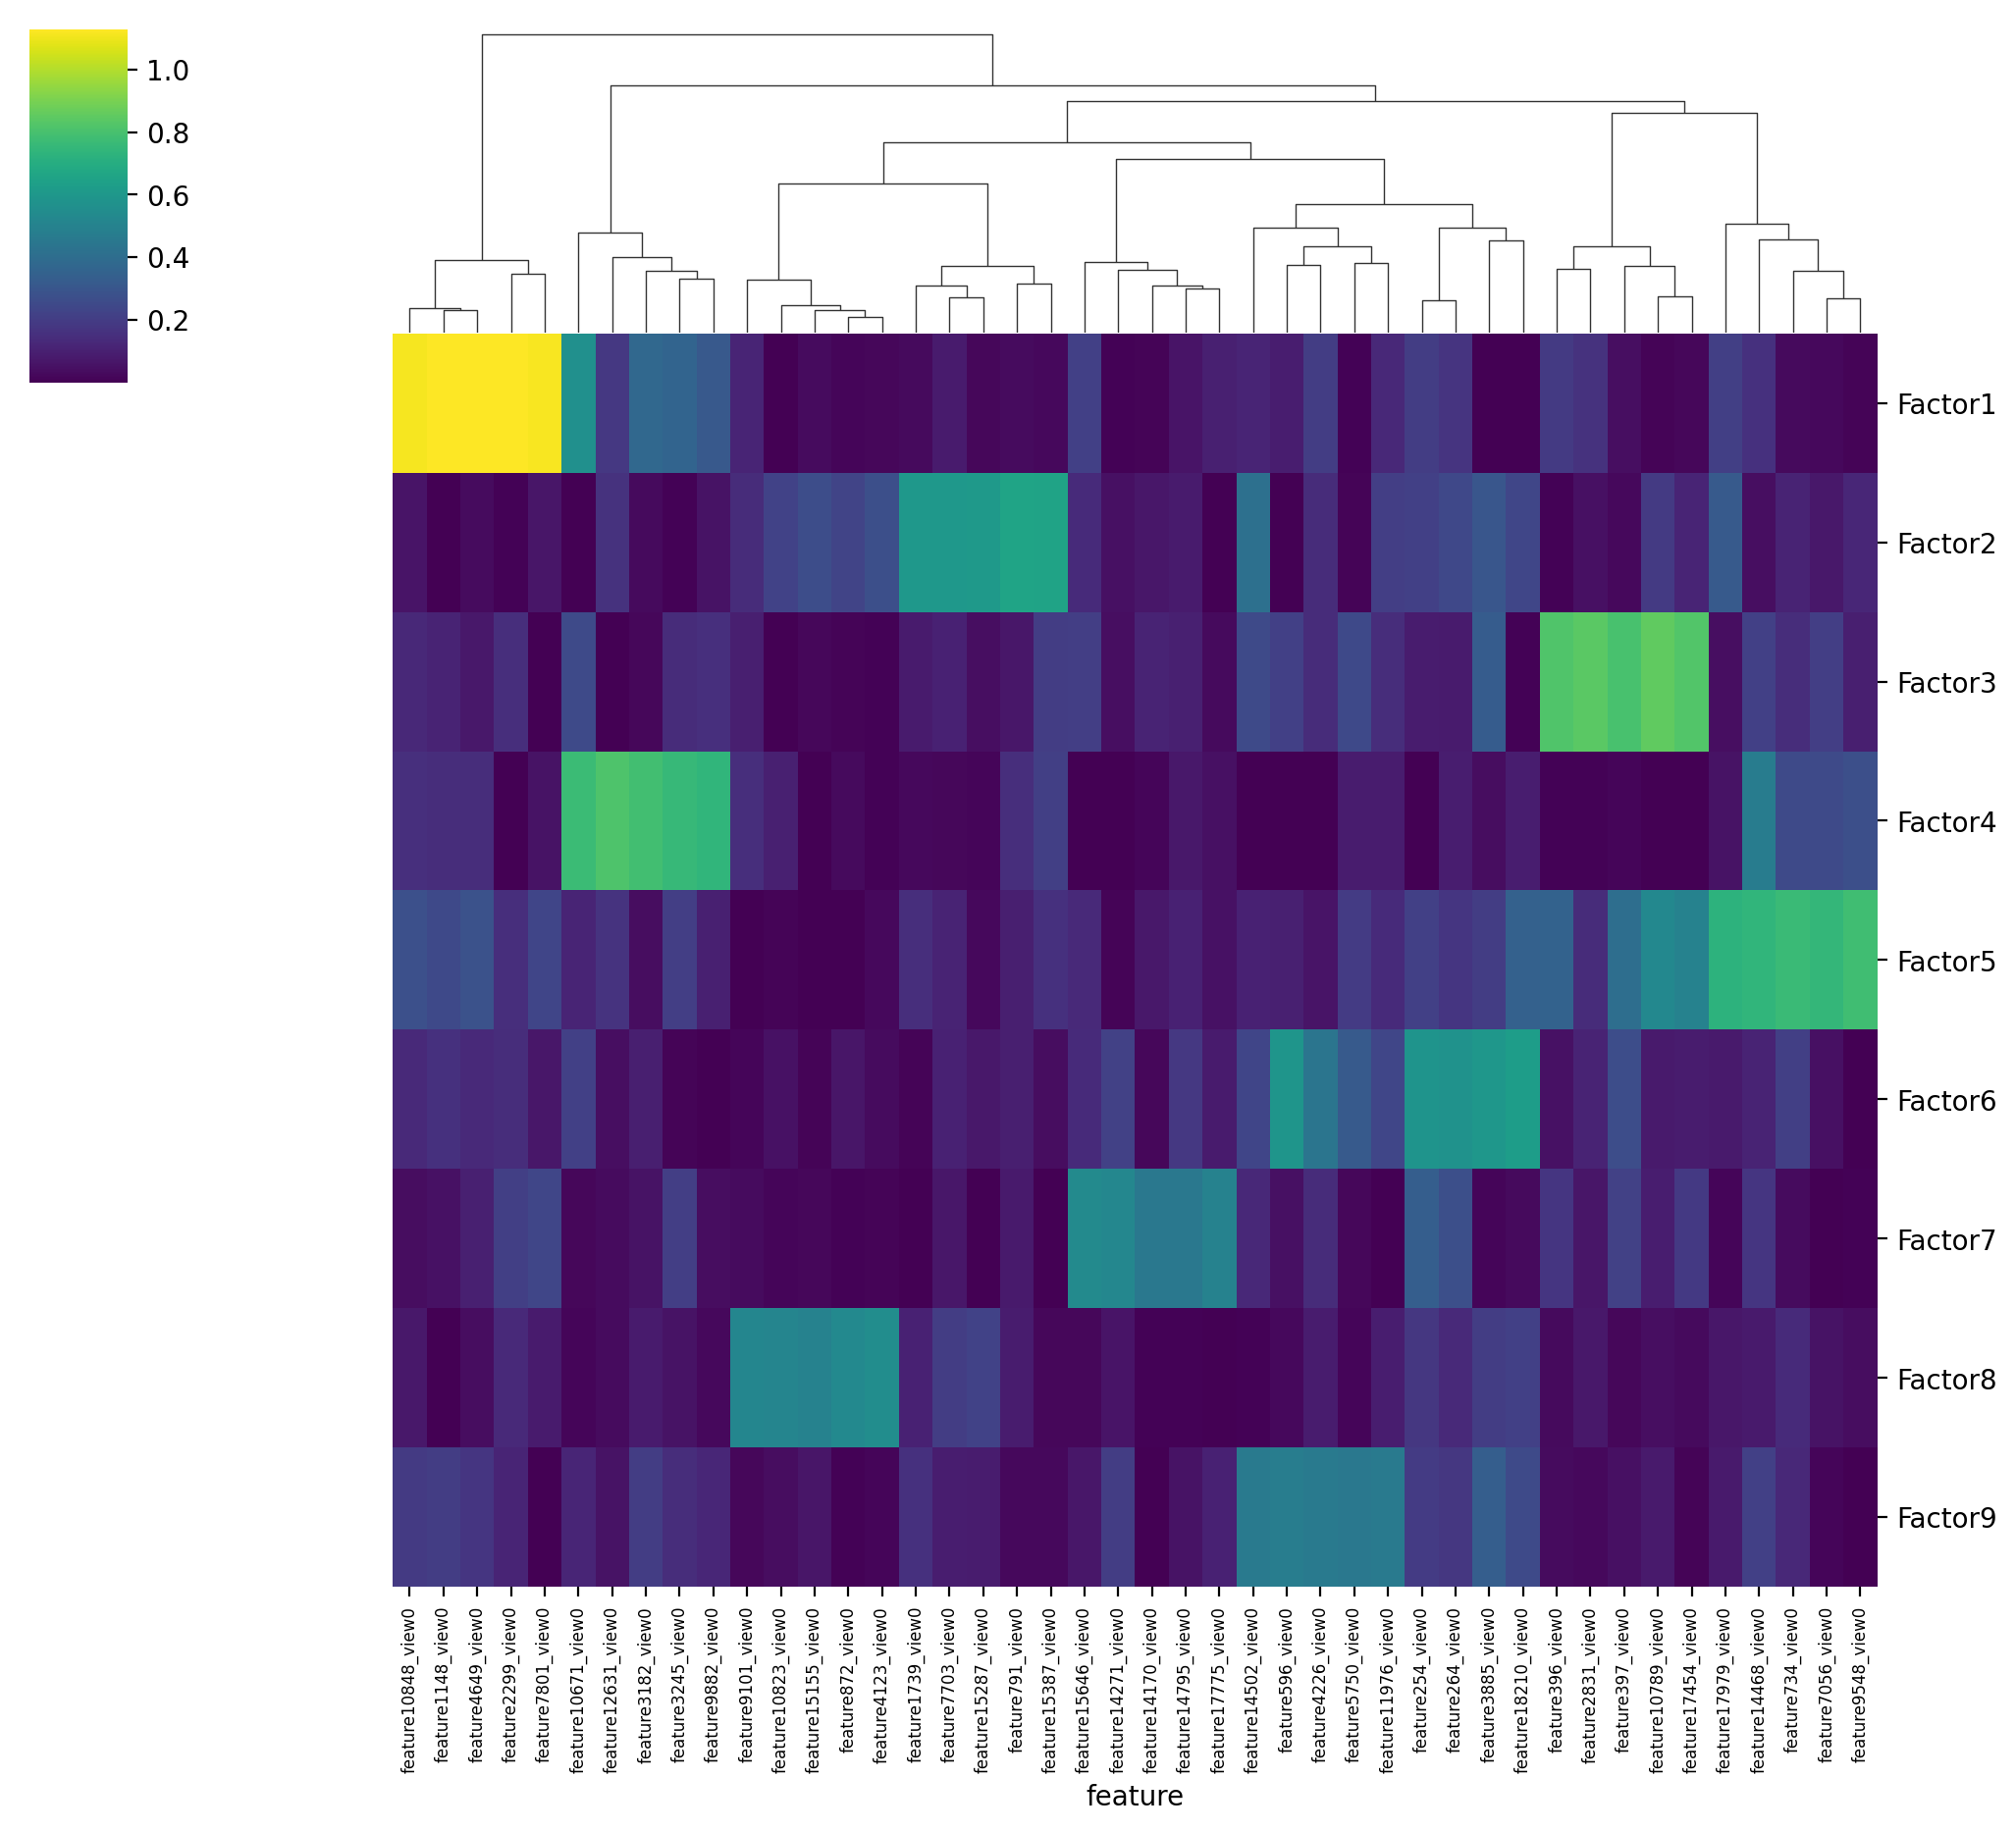

In [27]:
mfx.plot_weights_heatmap(
    m, n_features = 5,
    factors = range(0, 9),
    xticklabels_size = 6, w_abs = True,
    cmap = 'viridis',
    cluster_factors = False)

In [28]:
# very strong !!
factor1_genes = [
    'feature10848_view0',
    'feature1148_view0',
    'feature4649_view0',
    'feature2299_view0',
    'feature7801_view0'
]

print([gene_map[f] for f in factor1_genes])

['MYH11', 'ATP1A2', 'DES', 'C2orf40', 'HSPB6']


In [29]:
# potentially good :)
factor2_genes = [
    'feature1173_view0',
    'feature7703_view0',
    'feature15287_view0',
    'feature791_view0',
    'feature15387_view0'
]

print([gene_map[f] for f in factor2_genes])

['ATP5G2', 'HPN', 'SLC34A2', 'APOA1', 'SLC5A5']


In [30]:
# quite strong !
factor3_genes = [
    'feature396_view0',
    'feature2831_view0',
    'feature397_view0',
    'feature10789_view0',
    'feature17454_view0'
]

print([gene_map[f] for f in factor3_genes])

['AGR2', 'CAPN8', 'AGR3', 'MUC17', 'TSPAN8']


In [31]:
# quite strong !
factor4_genes = [
    'feature10671_view0',
    'feature12631_view0',
    'feature3182_view0',
    'feature3245_view0',
    'feature9882_view0'
]

print([gene_map[f] for f in factor4_genes])

['MS4A1', 'PLA2G2D', 'CD19', 'CD79A', 'LY9']


In [32]:
# could be strong !
factor5_genes = [
    'feature17979_view0',
    'feature14468_view0',
    'feature734_view0',
    'feature7056_view0',
    'feature9548_view0'
]

print([gene_map[f] for f in factor5_genes])

['VIL1', 'S100A2', 'ANXA8', 'GPR87', 'LOC642587']


In [33]:
# potentially good :)
factor6_genes = [
    'feature596_view0',
    'feature254_view0',
    'feature264_view0',
    'feature3885_view0',
    'feature18210_view0'
]

print([gene_map[f] for f in factor6_genes])

['AMY2B', 'ADAMTS12', 'ADAMTS2', 'COL11A1', 'WNT2']


In [34]:
# could drop..
factor7_genes = [
    'feature15646_view0',
    'feature14271_view0',
    'feature17775_view0'
]

print([gene_map[f] for f in factor7_genes])

['SNORD17', 'RPL39', 'UHMK1']


In [35]:
# could drop..
factor8_genes = [
    'feature101_view0',
    'feature10823_view0',
    'feature15155_view0',
    'feature872_view0',
    'feature4123_view0',
]

print([gene_map[f] for f in factor8_genes])

['ABLIM1', 'MYADML', 'SLC1A6', 'ARGFX', 'CRX']


#**Weight Dotplot - RNA View**

<Axes: title={'center': 'view0'}, xlabel='factor', ylabel='feature'>

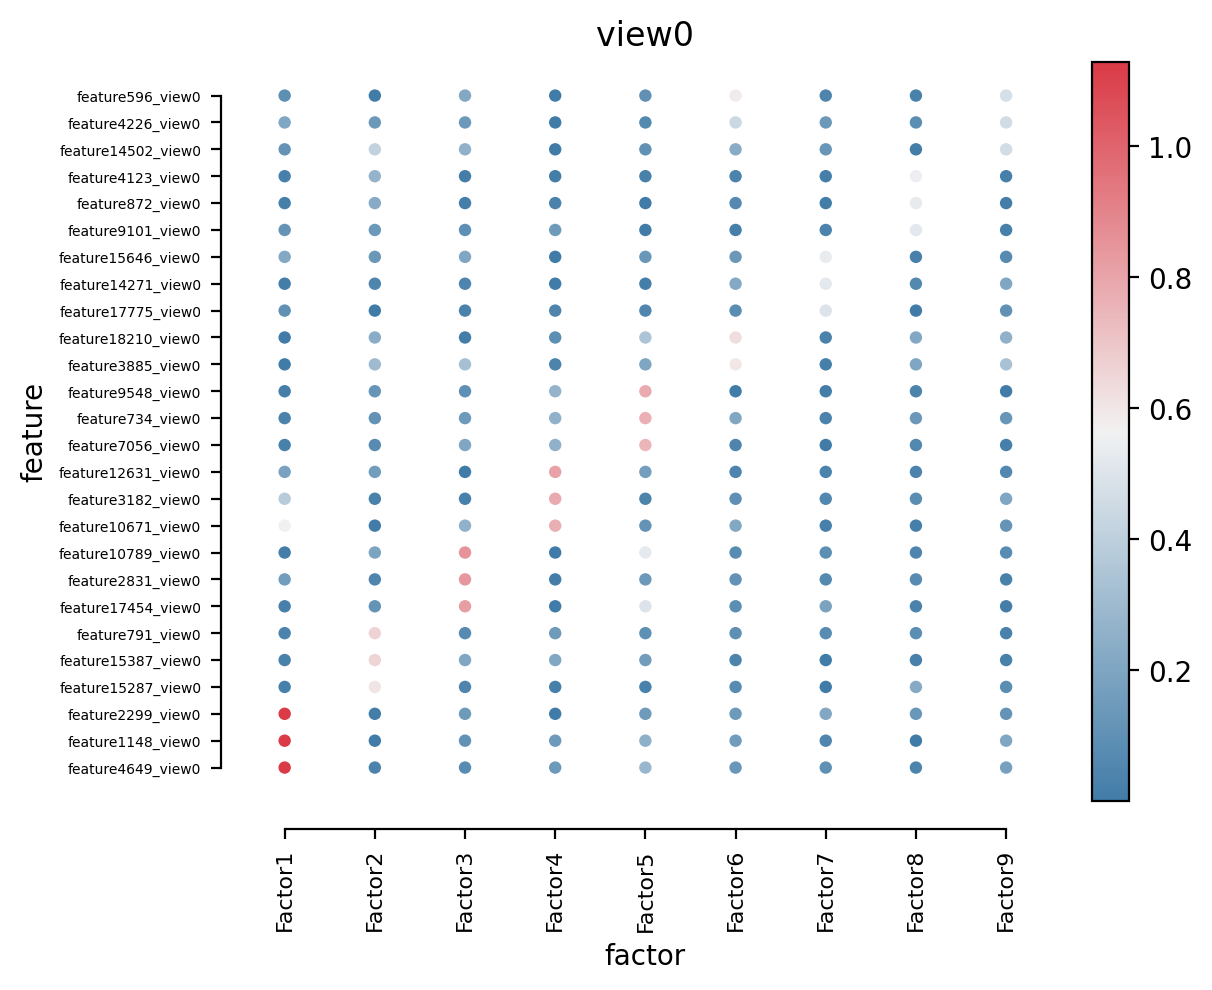

In [36]:
mfx.plot_weights_dotplot(
    m, n_features = 3,
    w_abs = True,
    factors = list(range(9)),
    yticklabels_size = 5
)

In [37]:
new_factor1_genes = [
    'feature2299_view0',
    'feature1148_view0',
    'feature4649_view0'
]

for g in new_factor1_genes:
  if g not in factor1_genes:
    print(f'adding feature {g}')
    factor1_genes.append(g)

print([gene_map[f] for f in factor1_genes])

['MYH11', 'ATP1A2', 'DES', 'C2orf40', 'HSPB6']


In [38]:
new_factor2_genes = [
    'feature791_view0',
    'feature15387_view0',
    'feature15287_view0'
]

for g in new_factor2_genes:
  if g not in factor2_genes:
    print(f'adding feature {g}')
    factor2_genes.append(g)

print([gene_map[f] for f in factor2_genes])

['ATP5G2', 'HPN', 'SLC34A2', 'APOA1', 'SLC5A5']


In [39]:
new_factor3_genes = [
    'feature10789_view0',
    'feature2831_view0',
    'feature17454_view0'
]

for g in new_factor3_genes:
  if g not in factor3_genes:
    print(f'adding feature {g}')
    factor3_genes.append(g)

print([gene_map[f] for f in factor3_genes])

['AGR2', 'CAPN8', 'AGR3', 'MUC17', 'TSPAN8']


#**Weight Dotplot - Mutation View (Very Weak)**

<Axes: title={'center': 'view1'}, xlabel='factor', ylabel='feature'>

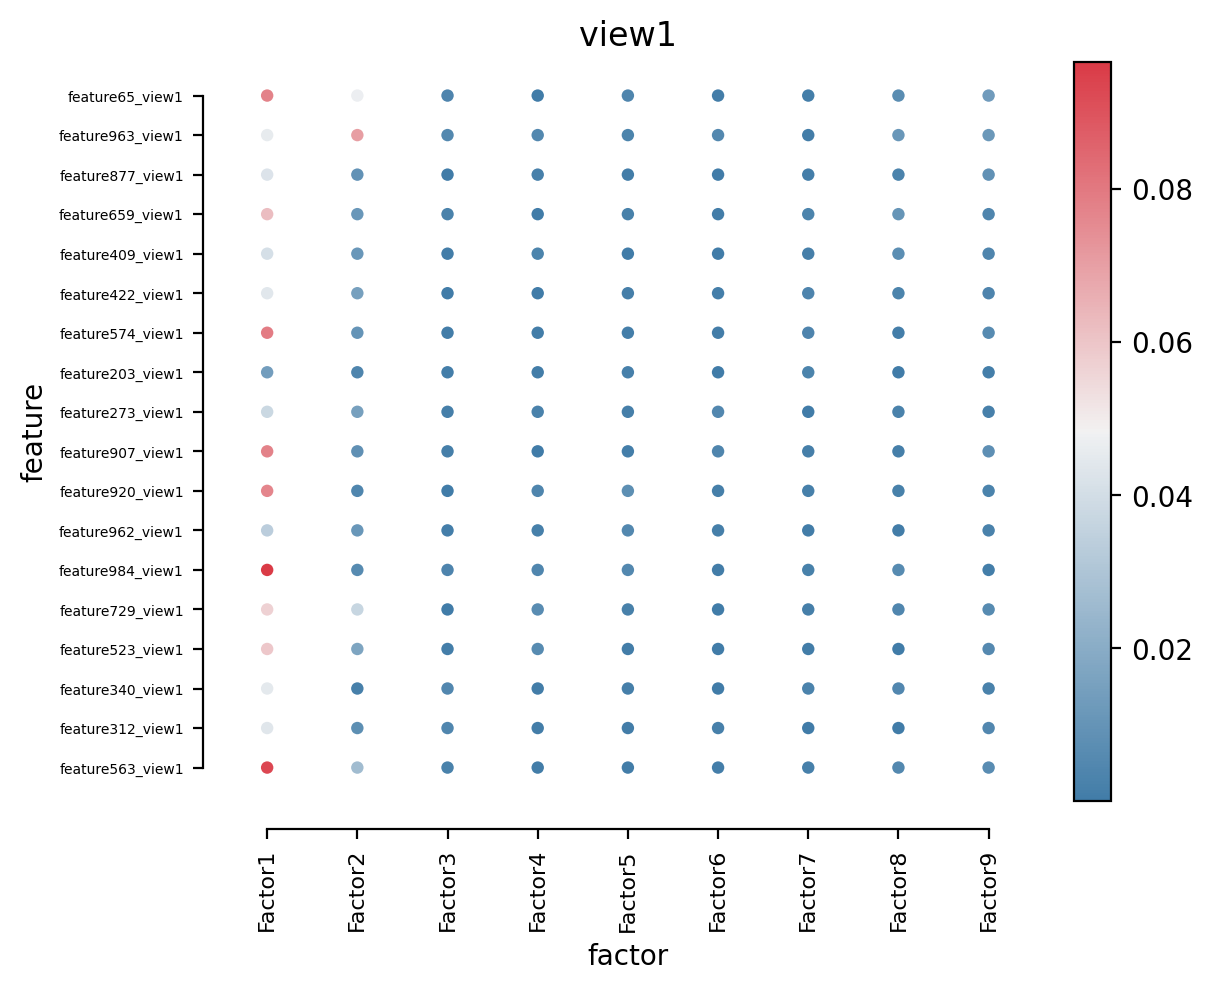

In [40]:
mfx.plot_weights_dotplot(
    m, view = 'view1', n_features = 3,
    w_abs = True,
    factors = list(range(9)),
    yticklabels_size = 5
)

#**Scatterplot, Scaled Weights**

In [41]:
m.get_variance_explained()

Factor   View   Group         R2
0   Factor1  view0  group0  15.550580
1   Factor1  view1  group0   1.663668
2   Factor2  view0  group0   5.791161
3   Factor2  view1  group0   0.414986
4   Factor3  view0  group0   4.560317
5   Factor3  view1  group0   0.030862
6   Factor4  view0  group0   3.943142
7   Factor4  view1  group0   0.039827
8   Factor5  view0  group0   2.953015
9   Factor5  view1  group0   0.035868
10  Factor6  view0  group0   2.910255
11  Factor6  view1  group0   0.027146
12  Factor7  view0  group0   2.585489
13  Factor7  view1  group0   0.023566
14  Factor8  view0  group0   2.193938
15  Factor8  view1  group0   0.074907
16  Factor9  view0  group0   1.589568
17  Factor9  view1  group0   0.059105

In [42]:
# ranking variance -
# 1. factor 1
# 2. factor 2
# 3. factor 3
# 4. factor 4
# 5. factor 5
# 6. factor 6
# 7. factor 7
# 8. factor 8

# ignoring factor 9 bc below threshold of > 2%

# how will we go about the plot?
# > we will compare factor 1 with ALL others bc of its strong R2
# > if good results, same will be strat applied with factors 2 and 3
# > avoiding comparing mid factors with other mid factors
# > including comparisons of 2, 3, and 4 together

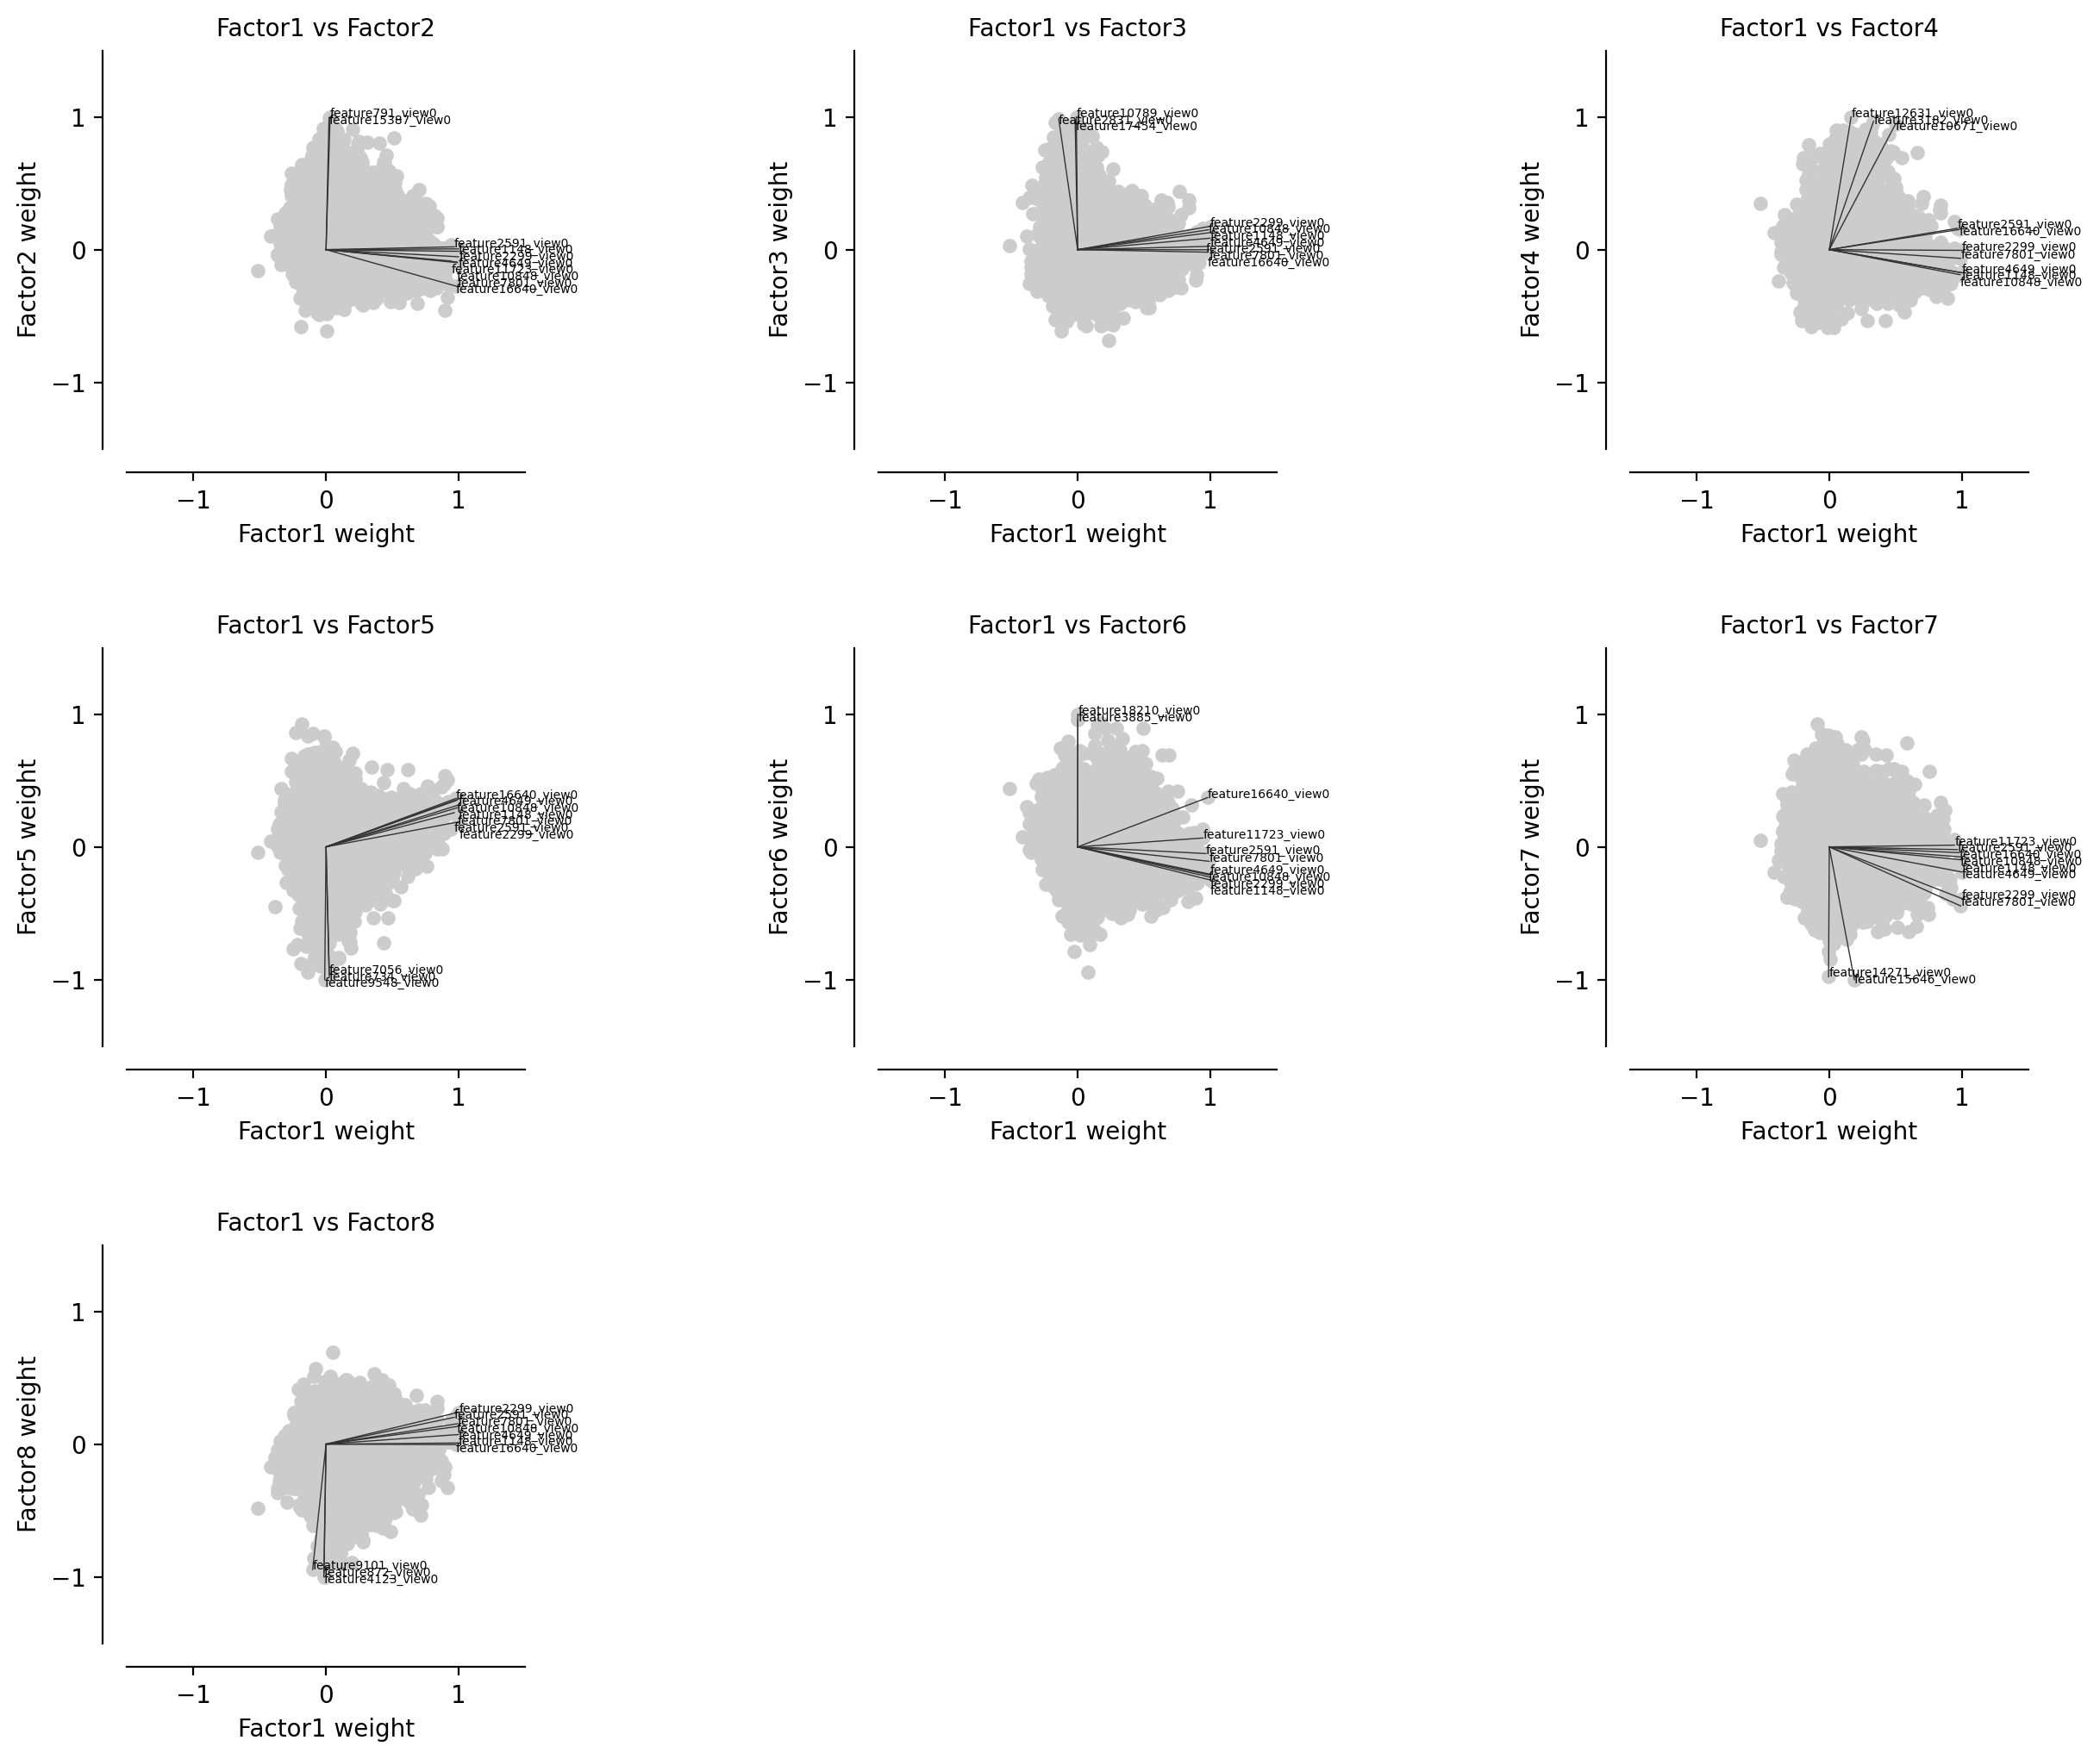

In [43]:
fig, axes = plt.subplots(3, 3, figsize = (15, 12))
axes = axes.flatten()

for i, y in enumerate(range(1, 8)):
    ax = axes[i]
    plt.sca(ax)
    mfx.plot_weights_scaled(m, x = 0, y = y, n_features = 10)
    ax.set_title(f'Factor1 vs Factor{y + 1}', fontsize = 10)

for j in range(7, len(axes)):
  axes[j].set_visible(False)

plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

In [44]:
# kinda strong clusters in factors 2 - 5
# no clusters, greater sparsity in factors 6 - 9 (expected)
# sooo we focus on factors 1 - 5 (as originally thought)
# factor 1 vs. 2 - 5 very orthogonal (unique bio info, we'll see)

In [45]:
factor_pairs = [
    (1, 2), #F2 vs. F3
    (1, 3), #F2 vs. F4
    (1, 4), #F2 vs. F5
    (2, 3), #F3 vs. F4
    (2, 4), #F3 vs. F5
    (3, 4)  #F4 vs. F5
]

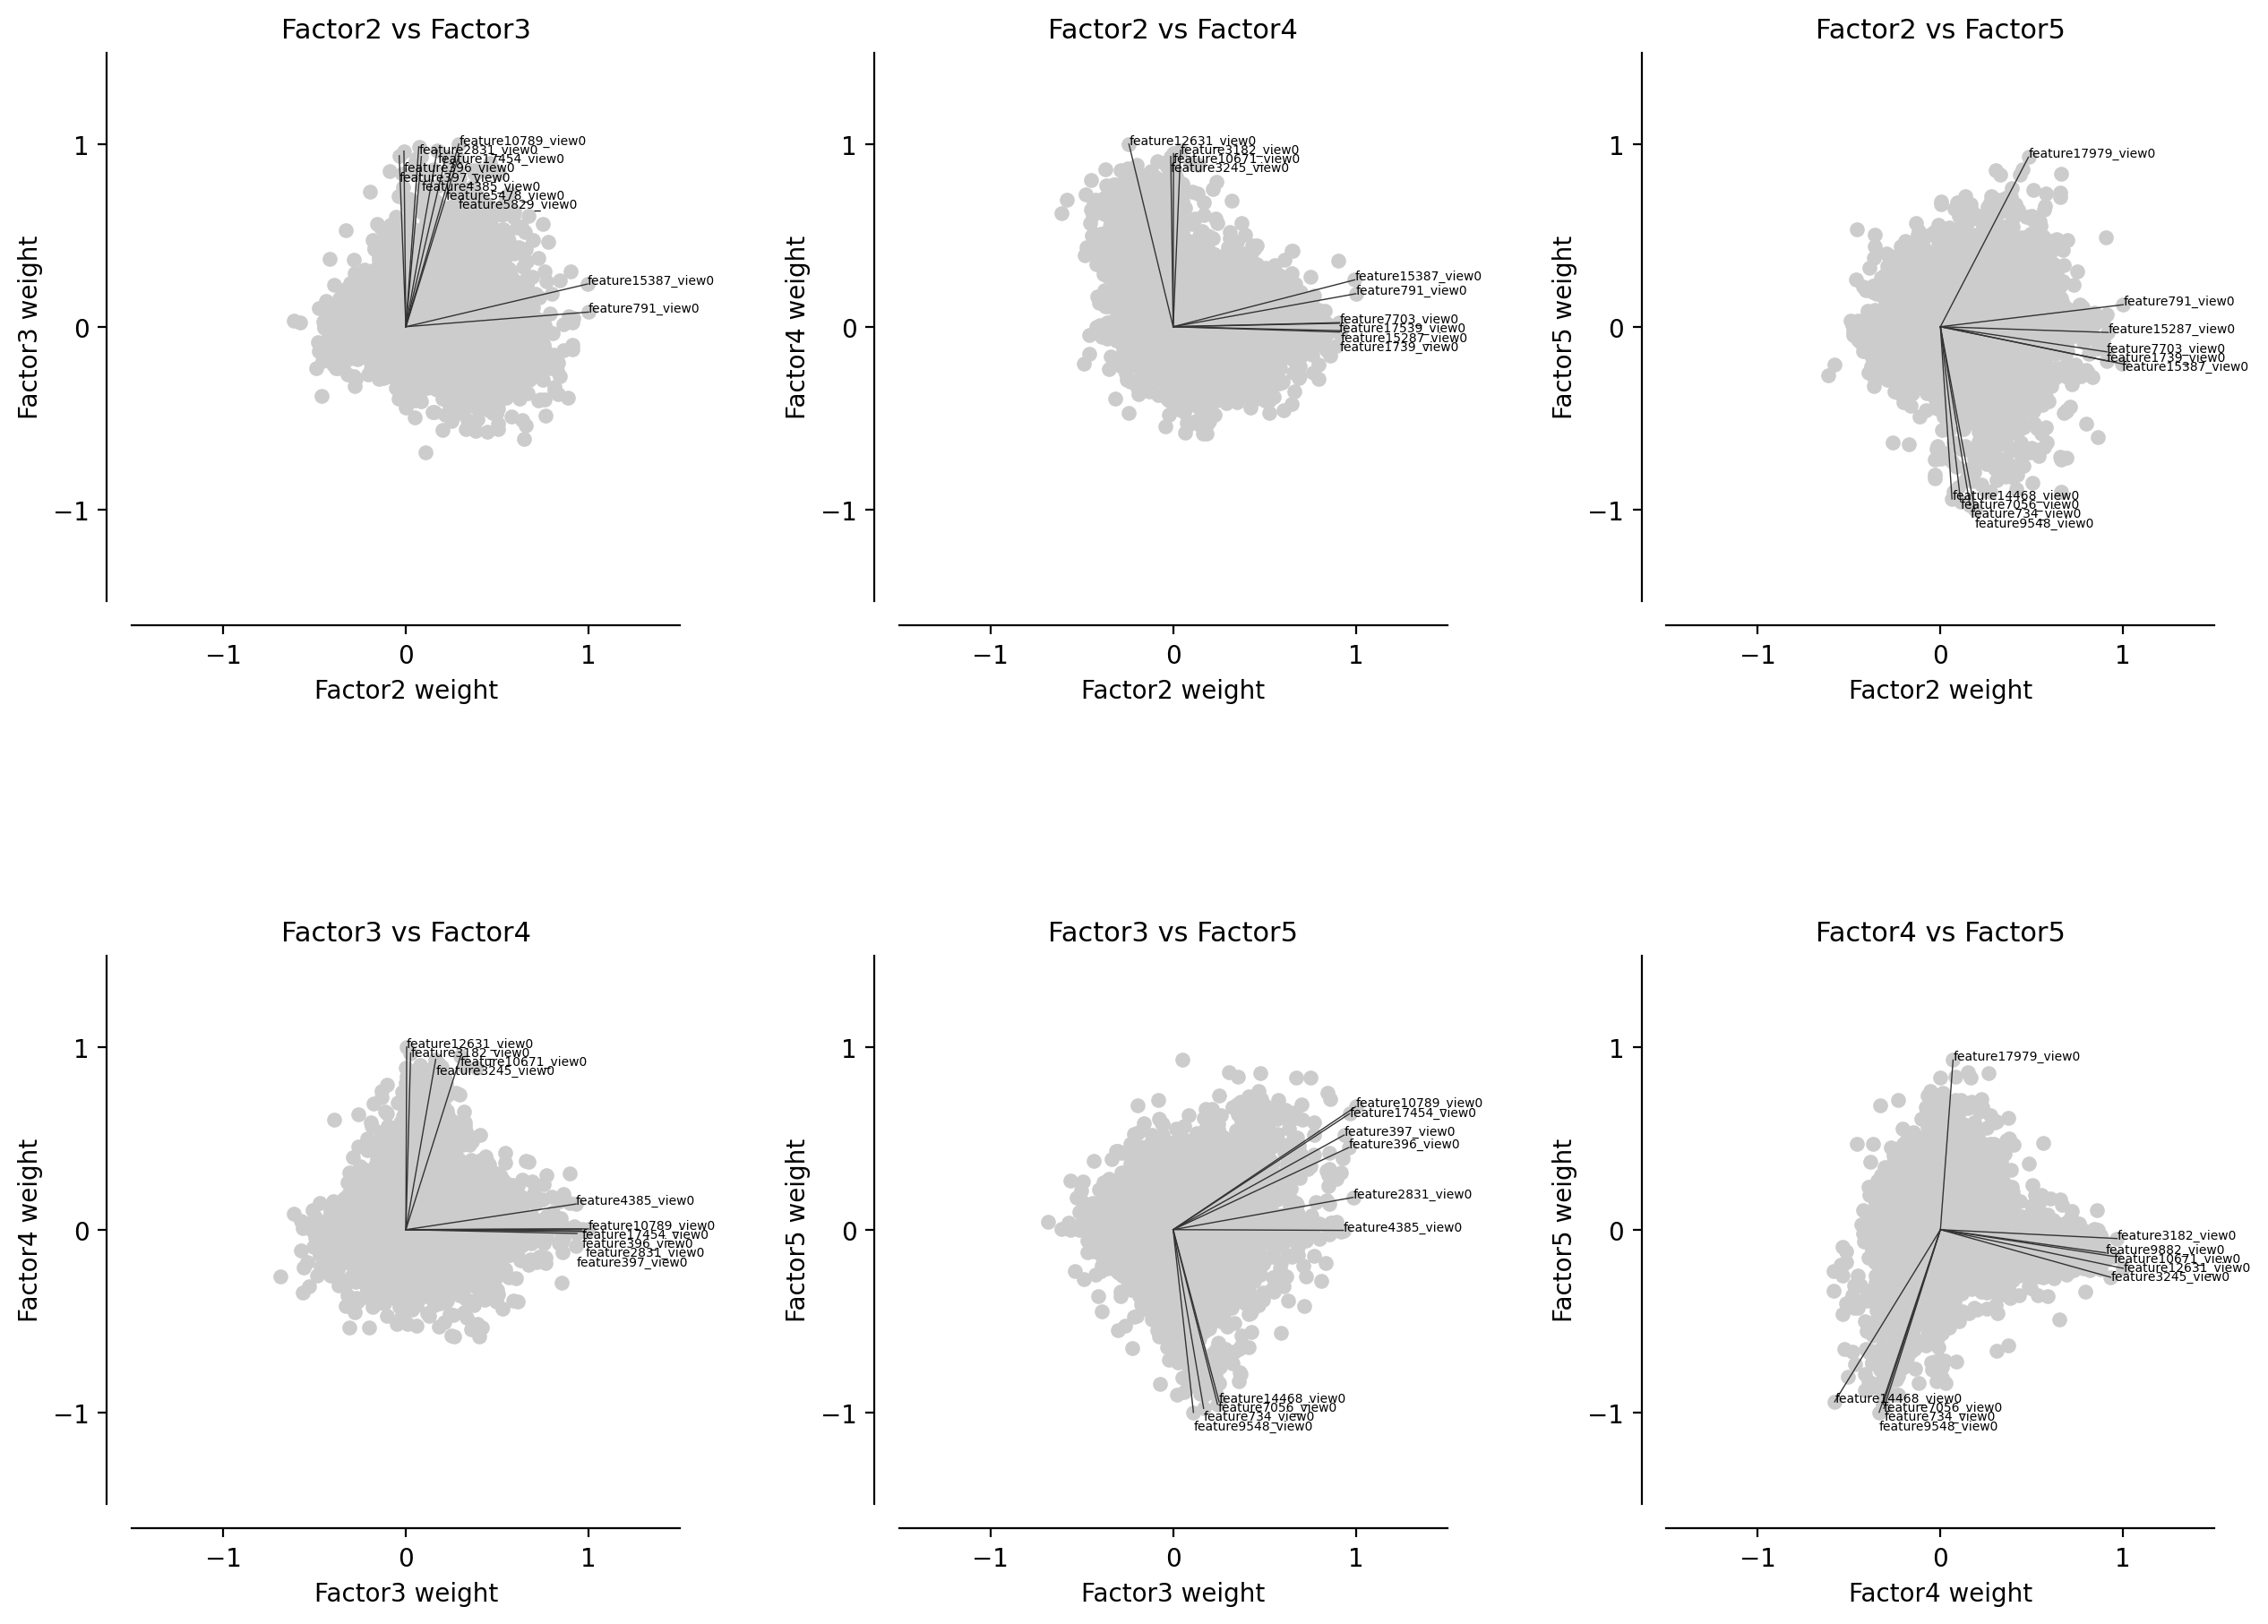

In [46]:
fig, axes = plt.subplots(2, 3, figsize = (15, 12))
axes = axes.flatten()

for i, (x, y) in enumerate(factor_pairs):
    ax = axes[i]
    plt.sca(ax)
    mfx.plot_weights_scaled(m, x = x, y = y, n_features = 10)
    ax.set_title(f'Factor{x + 1} vs Factor{y + 1}', fontsize = 11)

plt.subplots_adjust(wspace = 0.4, hspace = 0.2)
plt.show()

In [47]:
# no strong overlap between factors
# buuuut we do see some overlap in factor 5 comparisons...
# soooo we ignore factor 5 :) 1 - 4 have strong signals already

#**Scatterplot, Scaled Weights With Marginal**

In [48]:
factor_pairs = [
  ('Factor1', 'Factor2'),
  ('Factor1', 'Factor3'),
  ('Factor1', 'Factor4'),
  ('Factor2', 'Factor3'),
  ('Factor2', 'Factor4'),
  ('Factor3', 'Factor4')
]

Factor1 vs Factor2


<Figure size 1000x800 with 0 Axes>

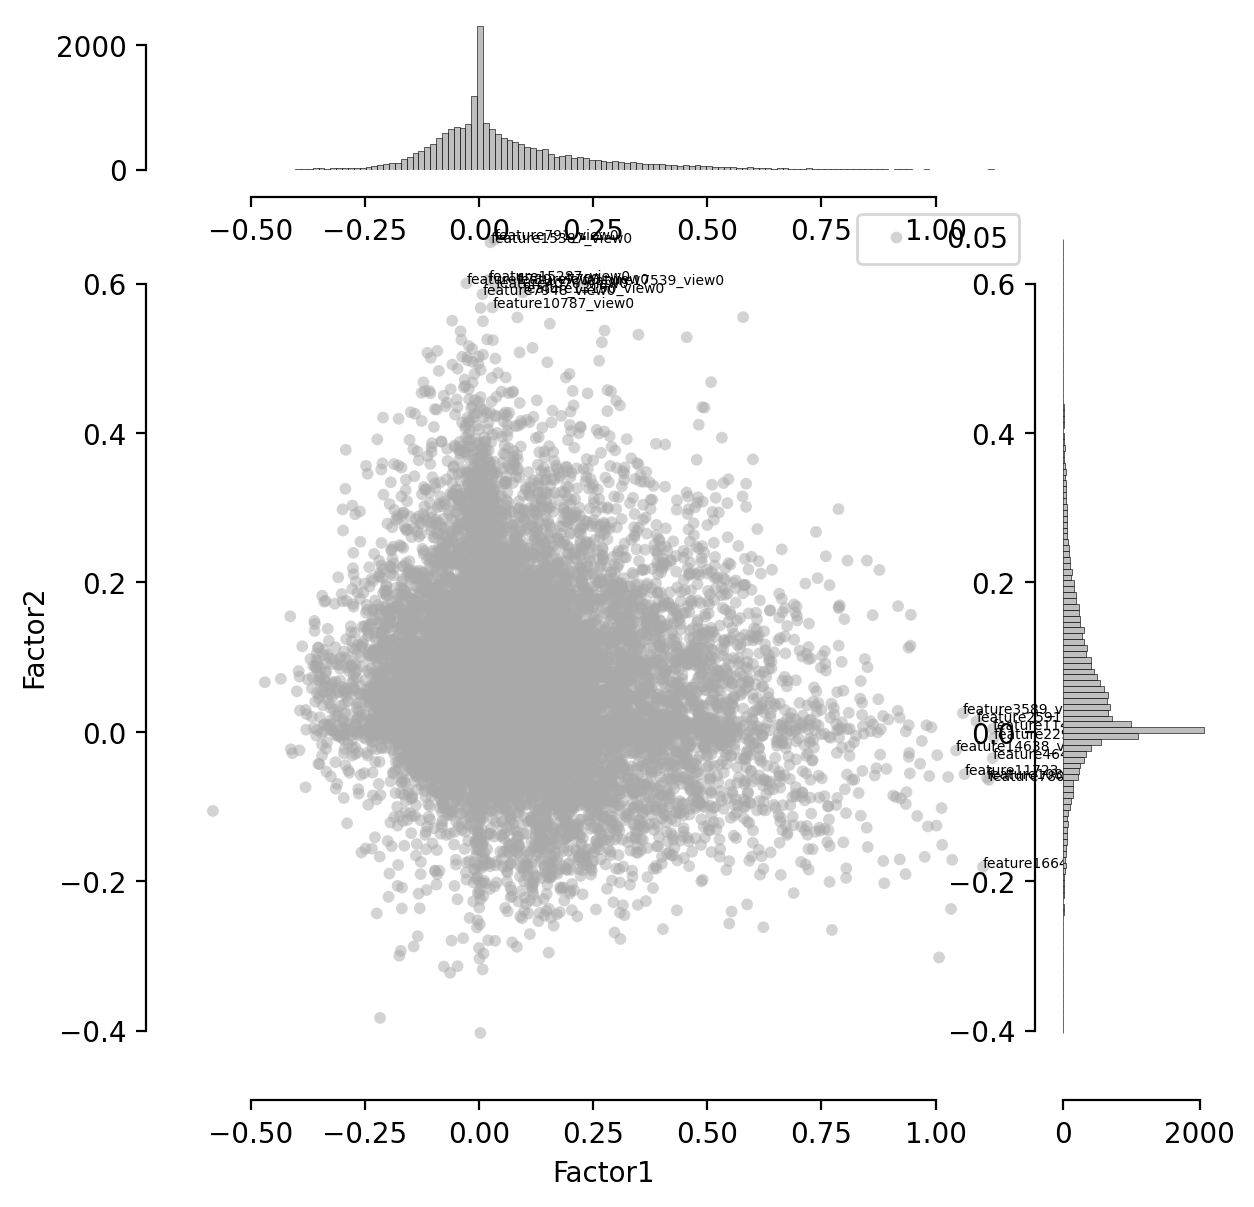



Factor1 vs Factor3


<Figure size 1000x800 with 0 Axes>

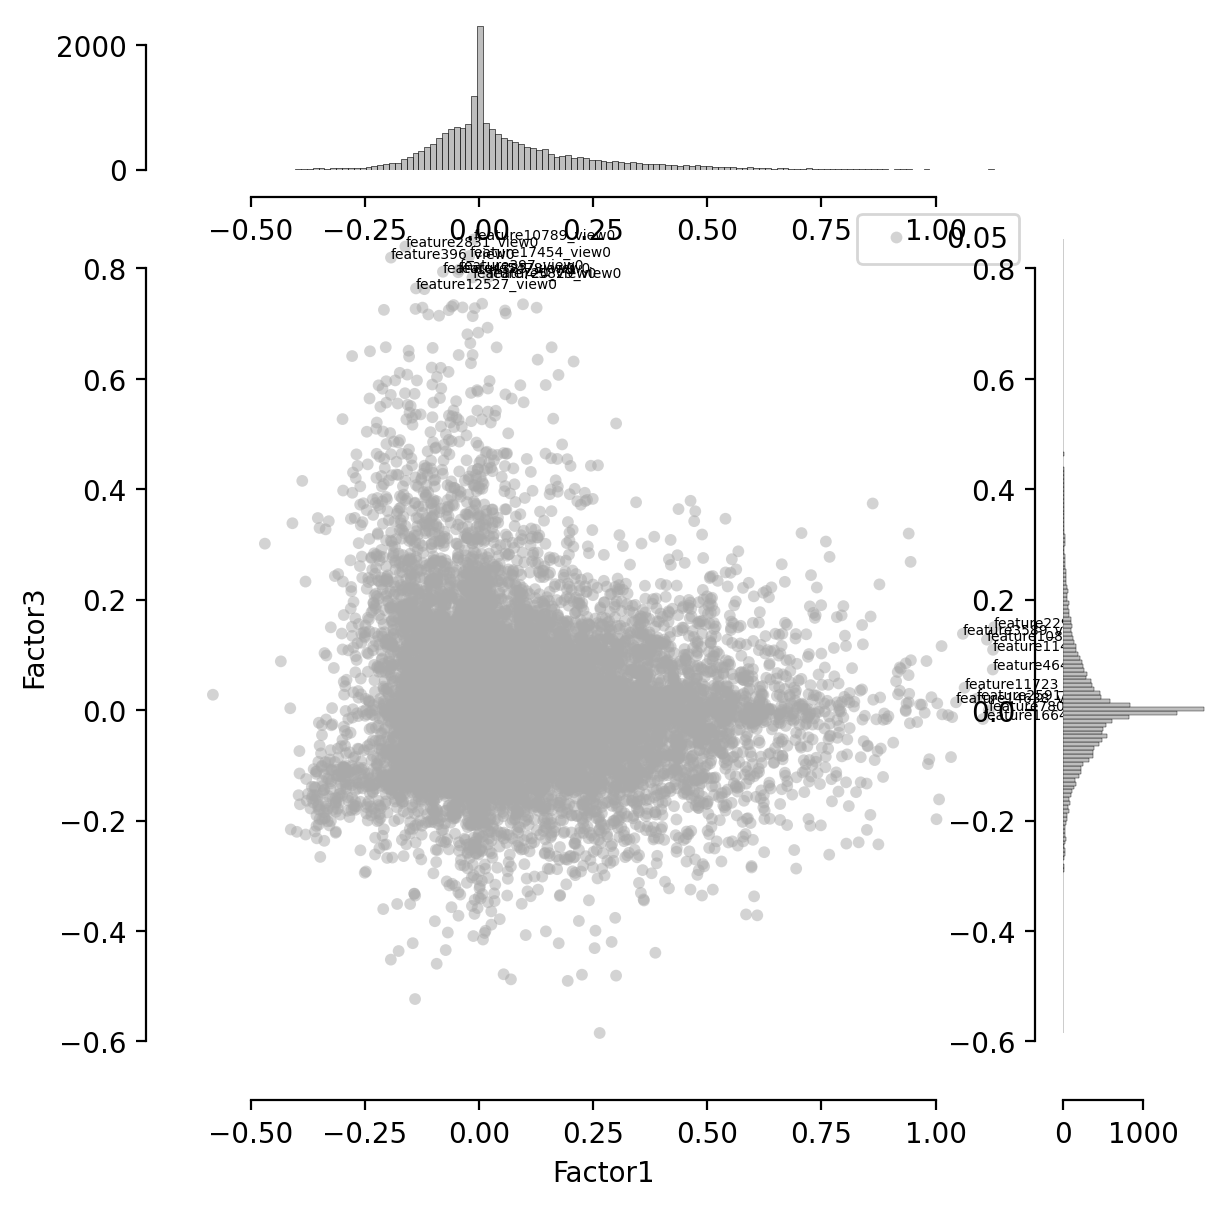



Factor1 vs Factor4


<Figure size 1000x800 with 0 Axes>

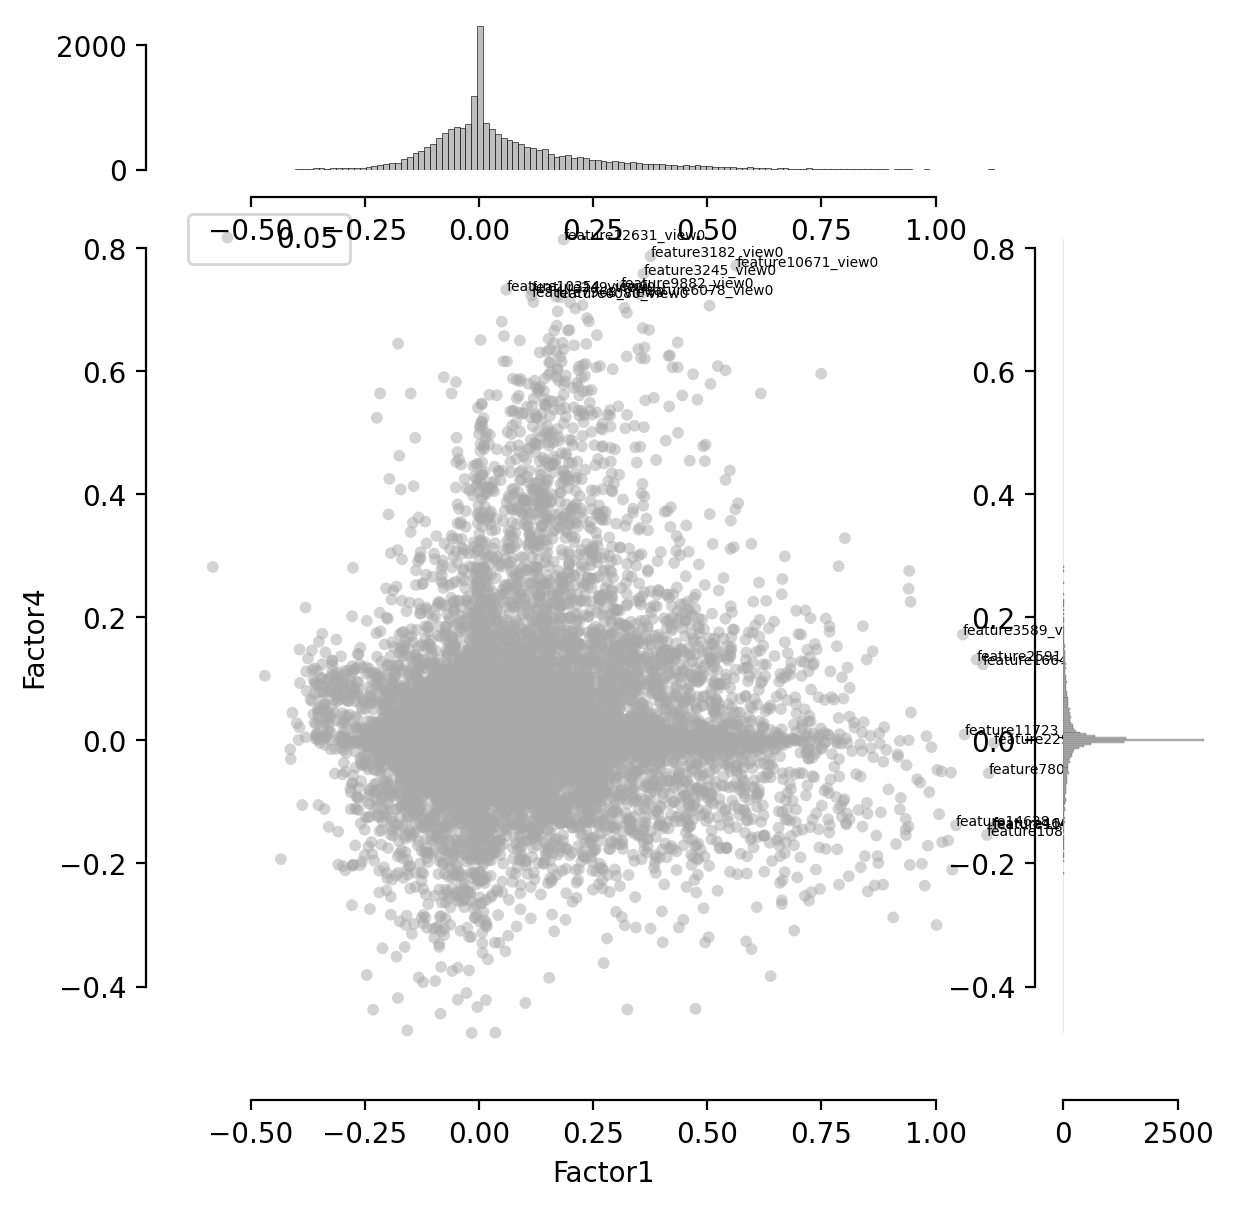



Factor2 vs Factor3


<Figure size 1000x800 with 0 Axes>

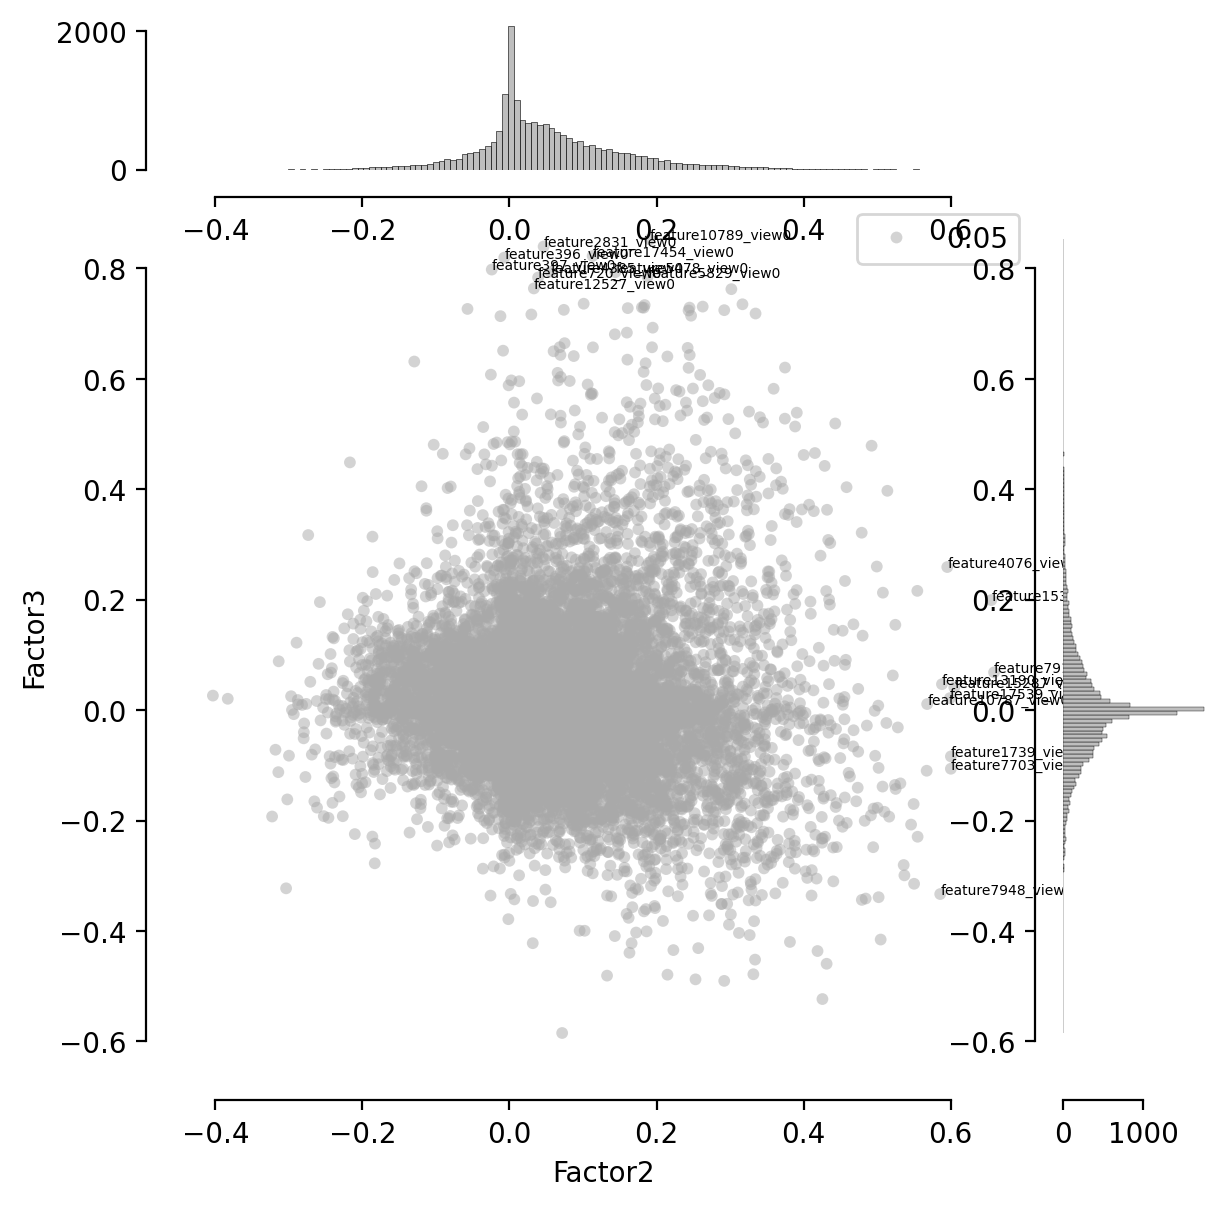



Factor2 vs Factor4


<Figure size 1000x800 with 0 Axes>

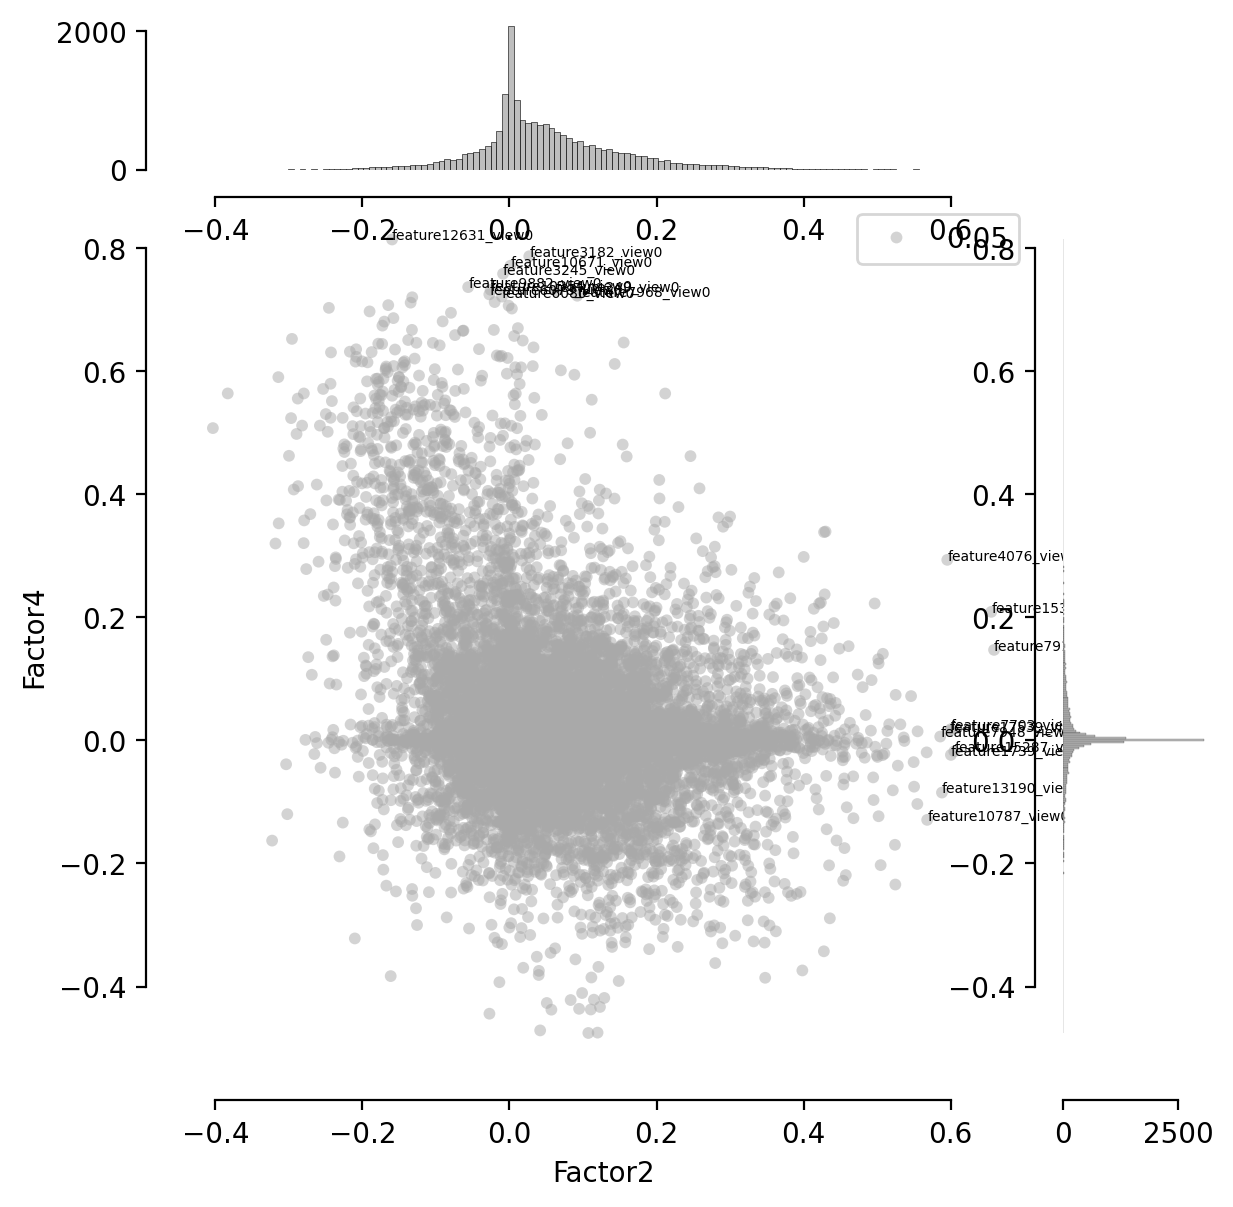



Factor3 vs Factor4


<Figure size 1000x800 with 0 Axes>

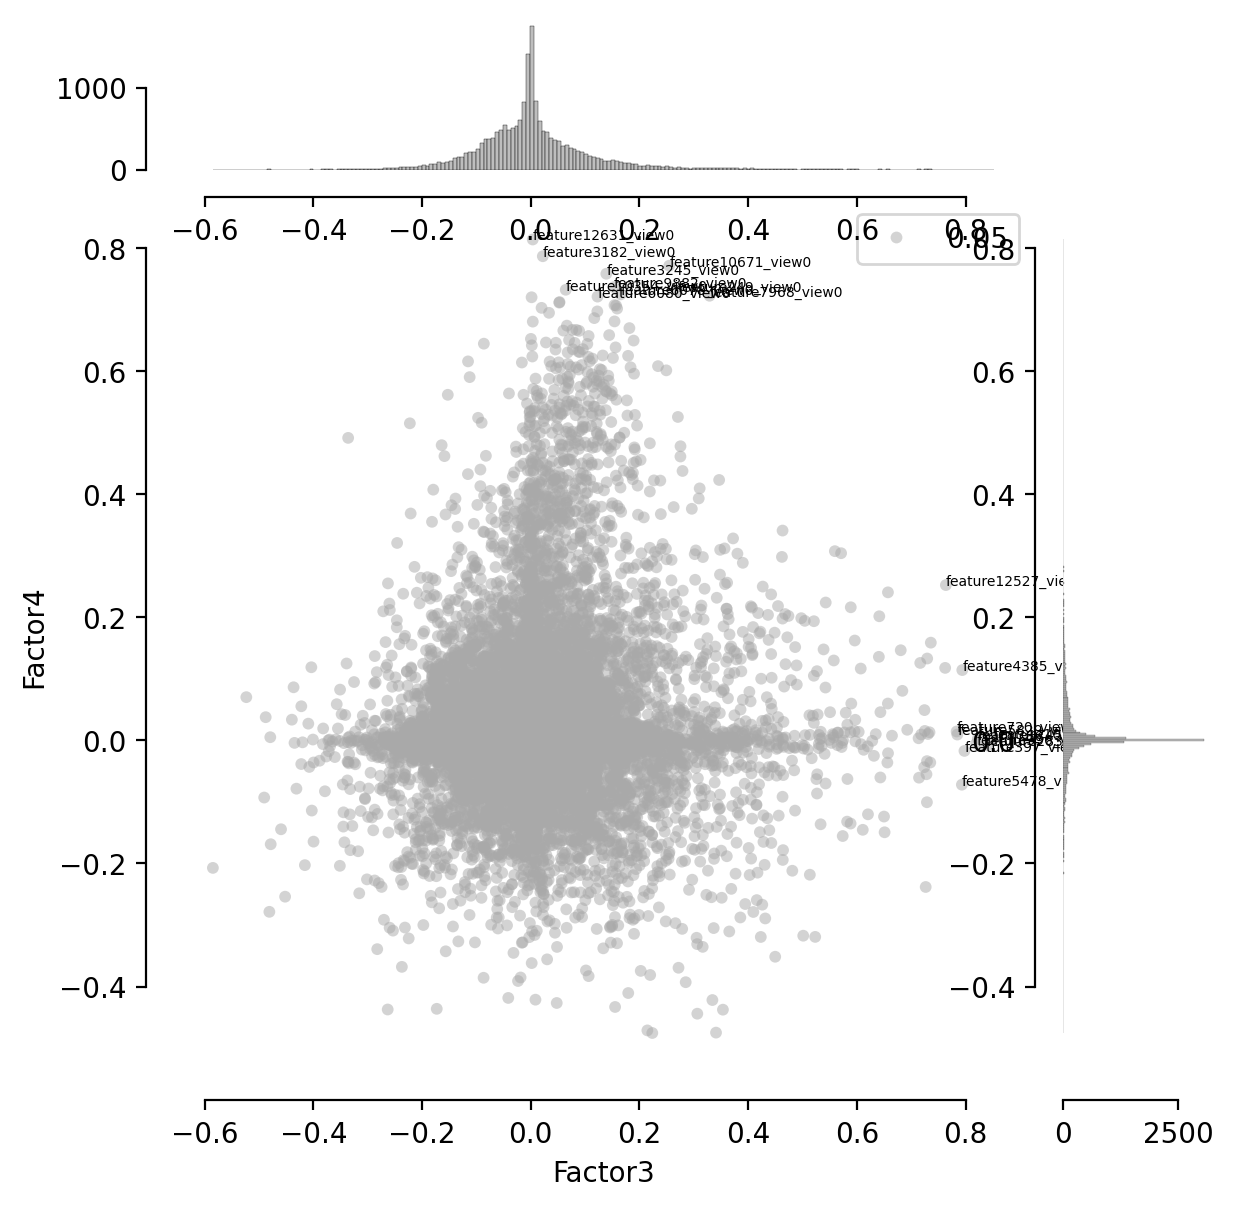

In [49]:
for x, y in factor_pairs:
    print(f'{x} vs {y}')
    plt.figure(figsize = (5, 4))
    mfx.plot_weights_scatter(
        m,
        x = x, y = y,
        hist = True,
        n_features = 10,
        size = 0.05, linewidth = 0, alpha = 0.5
    )

    plt.tight_layout()
    plt.show()
    print('\n')

#**Revisiting Heatmap**

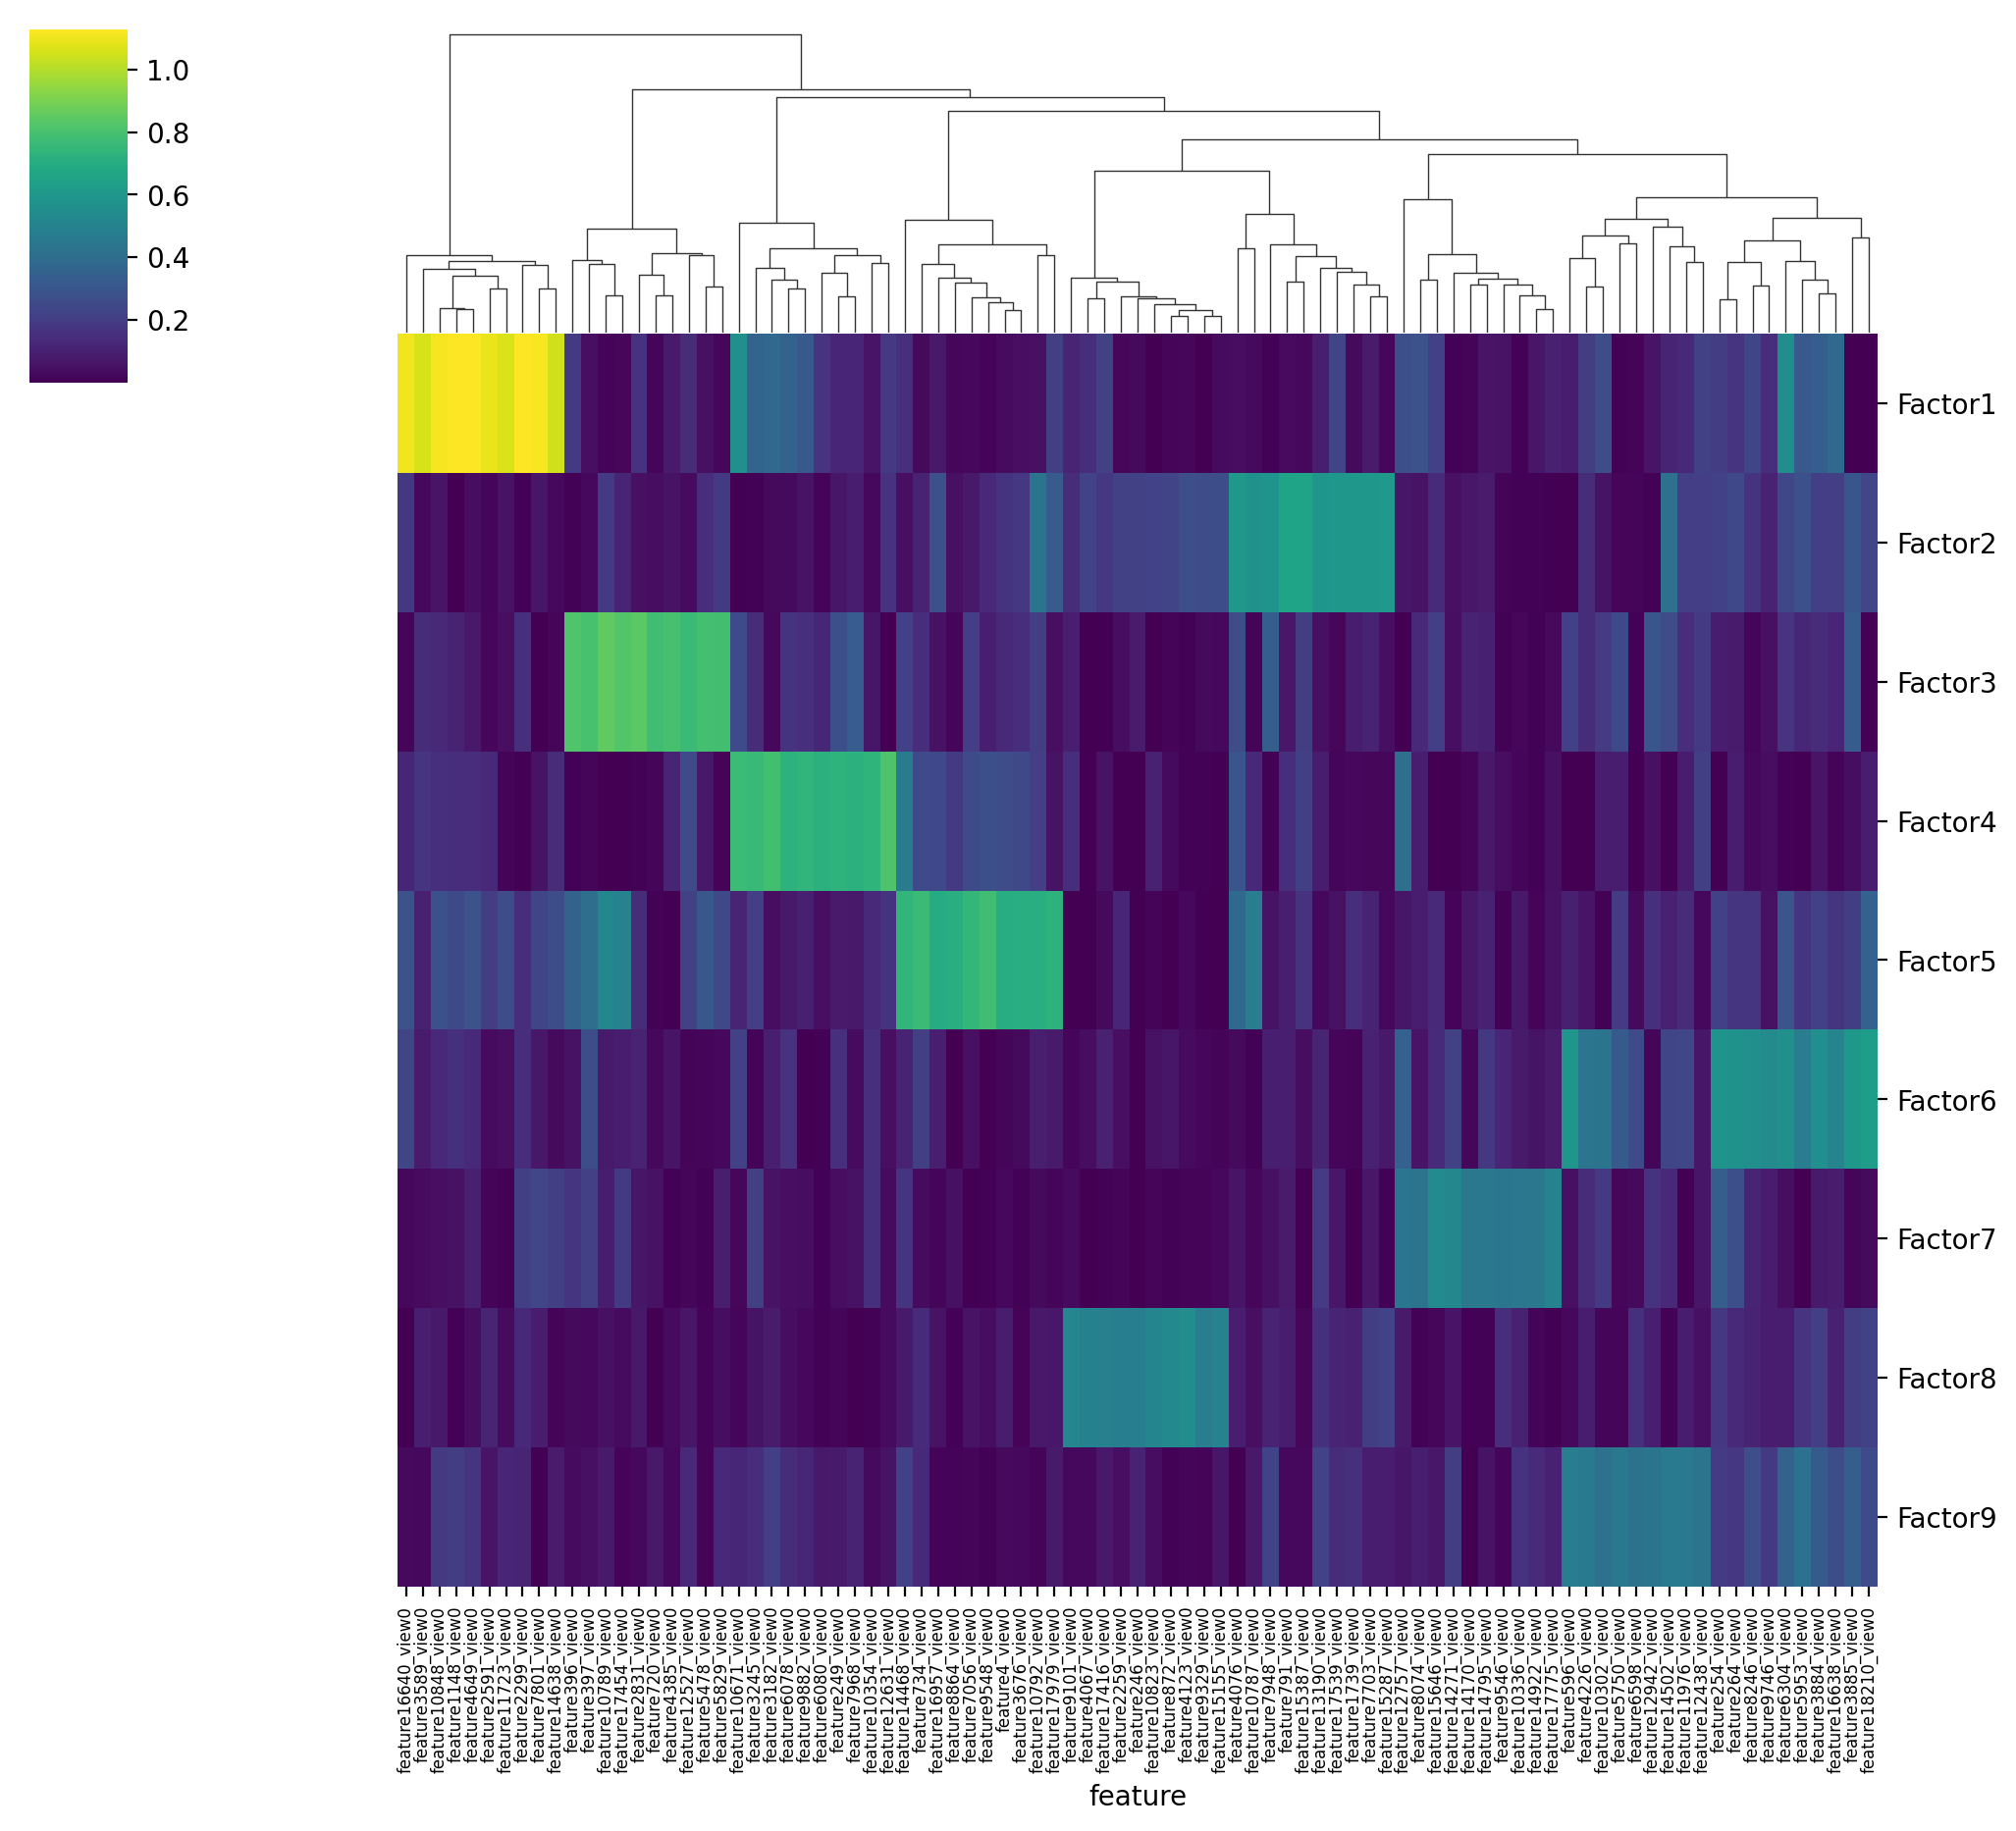

In [50]:
mfx.plot_weights_heatmap(
    m, n_features = 10,
    factors = range(0, 9),
    xticklabels_size = 6, w_abs = True,
    cmap = 'viridis',
    cluster_factors = False)

In [51]:
new_factor1_genes = [
    'feature16640_view0',
    'feature3589_view0',
    'feature10848_view0',
    'feature1148_view0',
    'feature4649_view0',
    'feature2591_view0',
    'feature11723_view0',
    'feature2299_view0',
    'feature7801_view0',
    'feature14638_view0'
]

for g in new_factor1_genes:
  if g not in factor1_genes:
    print(f'adding feature {g}')
    factor1_genes.append(g)

print()
for f in factor1_genes:
  print(gene_map[f])

adding feature feature16640_view0
adding feature feature3589_view0
adding feature feature2591_view0
adding feature feature11723_view0
adding feature feature14638_view0

MYH11
ATP1A2
DES
C2orf40
HSPB6
THBS4
CHRDL1
C7
OGN
SCRG1


In [52]:
new_factor2_genes = [
    'feature4076_view0',
    'feature10787_view0',
    'feature7948_view0',
    'feature791_view0',
    'feature15387_view0',
    'feature13190_view0',
    'feature17539_view0',
    'feature1739_view0',
    'feature7703_view0',
    'feature15287_view0',
]

for g in new_factor2_genes:
  if g not in factor2_genes:
    print(f'adding feature {g}')
    factor2_genes.append(g)

print()
for f in factor2_genes:
  print(gene_map[f])

adding feature feature4076_view0
adding feature feature10787_view0
adding feature feature7948_view0
adding feature feature13190_view0
adding feature feature17539_view0
adding feature feature1739_view0

ATP5G2
HPN
SLC34A2
APOA1
SLC5A5
CREB3L3
MUC15
IGF2BP1
PROC
TTR
C12orf56


In [53]:
new_factor3_genes = [
    'feature396_view0',
    'feature397_view0',
    'feature10789_view0',
    'feature17454_view0',
    'feature2831_view0',
    'feature720_view0',
    'feature4385_view0',
    'feature12527_view0',
    'feature5478_view0',
    'feature5829_view0'
]

for g in new_factor3_genes:
  if g not in factor3_genes:
    print(f'adding feature {g}')
    factor3_genes.append(g)

print()
for f in factor3_genes:
  print(gene_map[f])

adding feature feature720_view0
adding feature feature4385_view0
adding feature feature12527_view0
adding feature feature5478_view0
adding feature feature5829_view0

AGR2
CAPN8
AGR3
MUC17
TSPAN8
ANXA10
CYP2C18
PIGR
ERN2
FAM3D


In [54]:
new_feature4_genes = [
    'feature10671_view0',
    'feature3245_view0',
    'feature3182_view0',
    'feature6078_view0',
    'feature9882_view0',
    'feature6080_view0',
    'feature249_view0',
    'feature7968_view0',
    'feature10354_view0',
    'feature12631_view0',
    'feature14468_view0'
]

for g in new_feature4_genes:
  if g not in factor4_genes:
    print(f'adding feature {g}')
    factor4_genes.append(g)

print()
for f in factor4_genes:
  print(gene_map[f])

adding feature feature6078_view0
adding feature feature6080_view0
adding feature feature249_view0
adding feature feature7968_view0
adding feature feature10354_view0
adding feature feature14468_view0

MS4A1
PLA2G2D
CD19
CD79A
LY9
FCRL3
FCRL5
ADAM6
IGJ
MGC29506
S100A2


#**Processes and Pathways**

In [56]:
pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 8.9 MB/s eta 0:00:00


#**Factor 1 Genes**

In [74]:
for f in factor1_genes:
  print(gene_map[f])

MYH11
ATP1A2
DES
C2orf40
HSPB6
THBS4
CHRDL1
C7
OGN
SCRG1


#**Factor 2 Genes**

In [75]:
for f in factor2_genes:
  print(gene_map[f])

ATP5G2
HPN
SLC34A2
APOA1
SLC5A5
CREB3L3
MUC15
IGF2BP1
PROC
TTR
C12orf56


#**Factor 3 Genes**

In [76]:
for f in factor3_genes:
  print(gene_map[f])

AGR2
CAPN8
AGR3
MUC17
TSPAN8
ANXA10
CYP2C18
PIGR
ERN2
FAM3D


#**Factor 4 Genes**

In [77]:
for f in factor4_genes:
  print(gene_map[f])

MS4A1
PLA2G2D
CD19
CD79A
LY9
FCRL3
FCRL5
ADAM6
IGJ
MGC29506
S100A2
